# Introduction
**By Rajeswari Parasa**

*December 2023*

This notebook was developed as part of the project submission for the Deep Learning course at the University of South Brittany, Vannes, France, for the completion of MSc Copernicus Master in Digital Earth - GeoDSc Track.


In this notebook, I use a subset of the [MiniTimeMatch dataset](https://www.semanticscholar.org/paper/Match-And-Deform%3A-Time-Series-Domain-Adaptation-and-Painblanc-Chapel/2e5a111c55cb603e88a99034ada50dc147e23009#:~:text=The%20Match-And-Deform%20%28MAD%29%20approach%20that%20aims%20at%20finding,than%20state-of-the-art%20deep%20time%20series%20domain%20adaptation%20strategies.), corresponding to Denmark, and apply MLP and LSTM models to it. The first two sections of this notebook are dedicated to understanding the data. They consist of data exploration and data preparation part of the analysis. The rest of the notebook deals with set up and finetuning of the models.

**Briefly about the data**: Each observation in the data consists of a time sequence of 52 observations taken across 10 spectral bands of Sentinel-2. Each observation corresponds to spectral measurements aggregated over a land parcel. The observations are labelled with crop found in the parcel.

## **Experiments**
The following configurations were considered for the model training experiments:
1. **Multi Layer Perceptron (MLP) - Baseline**  
  * 1 layer, 256 hidden units
2. **MLP - Architecture tuning**
  * Hyperparameters tuned:
      * Number of hidden layers
      * Number of hidden units
3. **MLP - Application of BatchNorm & Dropout along with Architecture tuning**
  * Application of batch normalisation
  * Application of dropout
  * Hyperparameters tuned:
      * Dropout rate
      * Number of hidden layers
      * Number of hidden units
4. **MLP - Tuning of the training loop**

  * The best performing (on validation data) model architecture from the above three architectures is chosen to finetune the training loop.
  
  * Hyperparameters tuned:

    * Optimiser
    * Learning Rate
    * Batch-size
    * Patience
    * Epochs
5. **Long Short Term Memory (LSTM) - Baseline**
  * 1 layer, 64 hidden units
6. **LSTM - Weighted Loss**
  * 1 layer, 64 hidden units
  * Use of weighted crossentropy loss (instead of unweighted)
7. **LSTM - Architecture Tuning**
  * Hyperparameters tuned
      * Number of hidden layers
      * Number of hidden units
8. **LSTM - Tuning of the training loop**
  * The best performing (on validation data) LSTM architecture from the previous three experiments is chosen for tuning the training loop
  * Hyperparameters tuned:

    * Optimiser
    * Learning Rate
    * Batch-size
    * Patience
    * Epochs

## **Other details:**
* Early stopping was used during tuning of training loops and model architectures
* Unweighted cross entropy loss was used across models to allow comparability. Except in experiment 6 where weighted loss was tested.
* Experiments where model architectures were tuned, the following settings of the training loop were set as default:
    * Optimiser - Adam
    * Learning Rate - 0.01
    * Batch-size - 64
    * Patience - 5
    * Epochs - 60


Each of these parameters and their relevance with respect to the task is explained in the notebook.

## **Model Evaluation and Reporting**
* Cross entropy loss obtained on the validation data is considered as the main evaluation criteria for choosing a model over the other
* The model's performance is noted for each class using confusion matrix
* Finally, the test accuracy of the models reported for final decision making and model recommendation

## 0. Data Loading

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title **Libraries and Global Random Seeds**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import optuna
from optuna.samplers import TPESampler

# ------------------------Controlling sources of randomness for reproducibility -----------------------
# however it was observed in the PyTorch documentation that randomness is not always guaranteed
seed = 42
torch.manual_seed(seed)
import random
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True  # if using GPU
torch.backends.cudnn.benchmark = False  # if using GPU, set this to False to ensure reproducibility

In [ ]:
root = '/content/drive/TimeseriesClassification/'
file_path = root + 'data_DK1.npz'
# add the path of root directory of the project

In [ ]:
data = np.load(file_path, allow_pickle= True  )
class_names = data['class_names']
dates = data['dates']
labels = data['labels']
series = data['series']
data.close() #for handling the warnings associated with .npz file handling

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# for printing numpy arrays with only 3 decimals

In [ ]:
# print class_names with index
print('Shape:', class_names.shape)
for i in range(len(class_names)):
  print(i, class_names[i])

Shape: (17,)
0 corn
1 horsebeans
2 meadow
3 spring_barley
4 spring_oat
5 spring_peas
6 spring_rapeseed
7 spring_rye
8 spring_triticale
9 spring_wheat
10 unknown
11 winter_barley
12 winter_oat
13 winter_rapeseed
14 winter_rye
15 winter_triticale
16 winter_wheat


In [ ]:
dates.shape, dates

((52,),
 array([datetime.datetime(2017, 1, 13, 0, 0),
        datetime.datetime(2017, 2, 22, 0, 0),
        datetime.datetime(2017, 3, 1, 0, 0),
        datetime.datetime(2017, 3, 11, 0, 0),
        datetime.datetime(2017, 3, 21, 0, 0),
        datetime.datetime(2017, 3, 24, 0, 0),
        datetime.datetime(2017, 4, 3, 0, 0),
        datetime.datetime(2017, 4, 23, 0, 0),
        datetime.datetime(2017, 4, 30, 0, 0),
        datetime.datetime(2017, 5, 3, 0, 0),
        datetime.datetime(2017, 5, 13, 0, 0),
        datetime.datetime(2017, 5, 23, 0, 0),
        datetime.datetime(2017, 6, 2, 0, 0),
        datetime.datetime(2017, 6, 19, 0, 0),
        datetime.datetime(2017, 6, 22, 0, 0),
        datetime.datetime(2017, 7, 2, 0, 0),
        datetime.datetime(2017, 7, 4, 0, 0),
        datetime.datetime(2017, 7, 9, 0, 0),
        datetime.datetime(2017, 7, 12, 0, 0),
        datetime.datetime(2017, 7, 17, 0, 0),
        datetime.datetime(2017, 7, 19, 0, 0),
        datetime.datetime(2017, 8

In [ ]:
labels.shape, labels

((60332,), array([0, 0, 0, ..., 2, 2, 2], dtype=int32))

In [ ]:
series.shape, series
# time series (m,l,d) where m is the number of time series in a given domain,
## l is the length of the time series, and d is the number of channels in the image

((60332, 52, 10),
 array([[[1761.729, 1210.512, 1155.550, ..., 2066.555, 1166.261, 757.849],
         [1558.802, 1145.839, 1040.340, ..., 1466.473, 1185.448, 812.211],
         [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
         ...,
         [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
         [3599.991, 3030.613, 3176.511, ..., 4036.577, 2507.035,
          1706.531],
         [1582.262, 1069.987, 864.686, ..., 1823.683, 1182.273, 653.105]],
 
        [[1851.455, 1289.079, 1272.241, ..., 2103.718, 1130.644, 751.332],
         [1763.868, 1332.838, 1250.792, ..., 1677.104, 1398.893, 989.756],
         [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
         ...,
         [0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000],
         [3605.301, 3037.638, 3185.592, ..., 4068.233, 2486.373,
          1664.614],
         [1583.225, 1072.164, 856.885, ..., 1825.203, 1125.811, 615.118]],
 
        [[1757.325, 1201.672, 1137.162, ..., 1979.980, 1119.478, 727.092],
         [1696.539, 1

In [ ]:
series[0,0]

array([1761.729, 1210.512, 1155.550, 1841.356, 1395.858, 1718.231,
       1883.568, 2066.555, 1166.261, 757.849])

## 1. Data Exploration

Q1. identify the learning task to be solved
**Answer:** Timeseries-based multi-class **classification** task

Q2. determine the number of features in the dataset and their type
**Answer:** If model destroys the temporality, then 52 x 10 = 520 features, for eg MLP. If model considers temporality, then each of the timeseries is one feature so 10 features. Type float or timeseries-float respectively.

Q3. look at the descriptive statistics for quantitative explanatory variables
**Answer:** Plots (mean timeseries - for each class and across bands).

Q4. if you think it is necessary, normalize the data
**Answer:** Yes, because, scale of the values of the different bands varies.

Q5. look at the class distribution
**Answer:** Done

Q6. based on your analysis, choose the cost function you will use to train your deep learning models
**Answer:** Cross entropy loss


In [ ]:
X = series
y = labels

In [ ]:
# descriptive statistics of the dataset
print('Number of time series:', X.shape[0])
print('Number of timesteps per series:', X.shape[1])
print('Number of channels per timestep:', X.shape[2])
print('Number of classes:', len(np.unique(y)))

Number of time series: 60332
Number of timesteps per series: 52
Number of channels per timestep: 10
Number of classes: 17


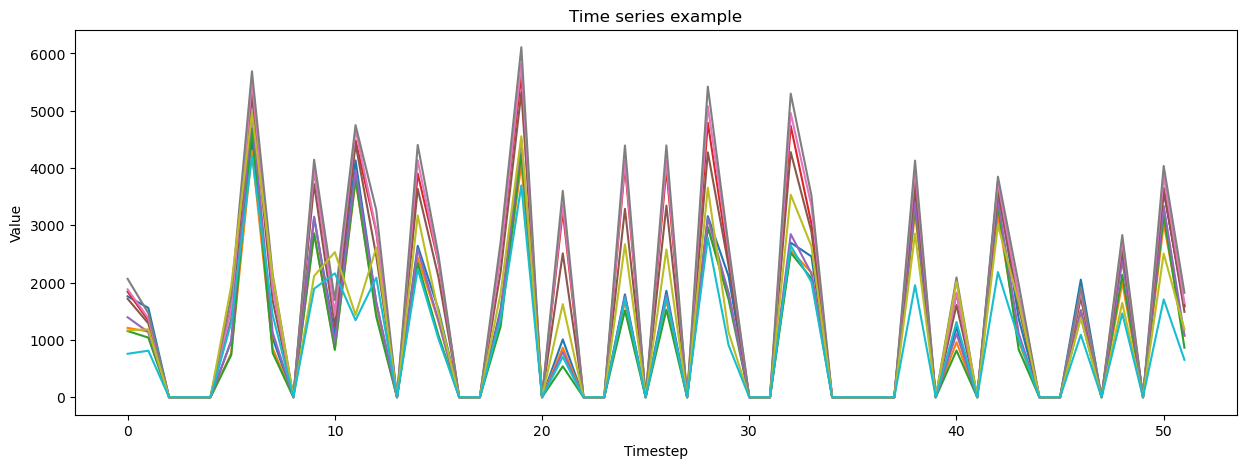

In [ ]:
# plot the time series for one sample to visualise data
plt.figure(figsize=(15, 5))
plt.plot(X[0])
plt.title('Figure: Time series example')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.show()

In the above graph, I visualise a single sample of the dataset to get a sense of the data.

### 1.3. Crop Class Based Analysis

In this section I look at the class distribution present in the dataset. This will help us understand any potential class imbalances present in the data, inform our decisions on whether to drop some classes altogether, combine them, and get hints about stratification.

In [ ]:
# function to return the number of samples and their percentages per class as a dictionary
def UD_class_distribution(y, sorted_by_count = False):
    unique, counts = np.unique(y, return_counts=True)
    percentages = np.array([round((i/sum(counts))*100,3) for i in counts])
    distribution = list(zip(unique, counts, percentages))
    if sorted_by_count:
        distribution = sorted(distribution, key=lambda x: x[1], reverse=True)
    return np.array(distribution)

In [ ]:
array = UD_class_distribution(y)
array

array([[0.000, 4047.000, 6.708],
       [1.000, 318.000, 0.527],
       [2.000, 12676.000, 21.010],
       [3.000, 13838.000, 22.936],
       [4.000, 1534.000, 2.543],
       [5.000, 339.000, 0.562],
       [6.000, 14.000, 0.023],
       [7.000, 45.000, 0.075],
       [8.000, 36.000, 0.060],
       [9.000, 311.000, 0.515],
       [11.000, 6413.000, 10.630],
       [12.000, 3738.000, 6.196],
       [13.000, 1.000, 0.002],
       [15.000, 2917.000, 4.835],
       [16.000, 3856.000, 6.391],
       [17.000, 389.000, 0.645],
       [18.000, 9860.000, 16.343]])

This distribution matrix shows us that class 13 has only 1 observation in the data. Similarly, classes 6, 7, and 8 also have very less number of samples, while class 3 has the highest number of observations.

In [ ]:
print("Shape of X", X.shape)
print("Shape of y",y.shape)

unique= array[:,0]
print("Number of unique classes in y:", unique.shape[0])

Shape of X (60332, 52, 10)
Shape of y (60332,)
Number of unique classes in y: 17



Further, notice that there are two extra classes, with indices 17 and 18 which are not present in 'class_names' list. We will append them to the list as 'NC1', 'NC2'.

In [ ]:
class_names_new = np.append(class_names, ['NC1', 'NC2'])
class_names_new.shape, class_names_new

((19,),
 array(['corn', 'horsebeans', 'meadow', 'spring_barley', 'spring_oat',
        'spring_peas', 'spring_rapeseed', 'spring_rye', 'spring_triticale',
        'spring_wheat', 'unknown', 'winter_barley', 'winter_oat',
        'winter_rapeseed', 'winter_rye', 'winter_triticale',
        'winter_wheat', 'NC1', 'NC2'], dtype='<U16'))

In [ ]:
# obtain class names of our data to check which index belongs to which crop - just for context
class_dict = {}
for i in range(len(unique)):
  class_dict[int(unique[i])] = class_names_new[int(unique[i])]
class_names_data = list(class_dict.values())
class_dict

{0: 'corn',
 1: 'horsebeans',
 2: 'meadow',
 3: 'spring_barley',
 4: 'spring_oat',
 5: 'spring_peas',
 6: 'spring_rapeseed',
 7: 'spring_rye',
 8: 'spring_triticale',
 9: 'spring_wheat',
 11: 'winter_barley',
 12: 'winter_oat',
 13: 'winter_rapeseed',
 15: 'winter_triticale',
 16: 'winter_wheat',
 17: 'NC1',
 18: 'NC2'}

In [ ]:
# from the samples, obtain the mean timeseries of each class for each channel
X_mean = np.zeros((len(unique), X.shape[1], X.shape[2]))
for i in range(len(np.unique(y))):
  X_mean[i] = np.mean(X[y == unique[i]], axis=0)
X_mean.shape

(17, 52, 10)

In order to characterise each class using its timeseries, we plot the mean timeseries for each class. This is shown in the following figure.

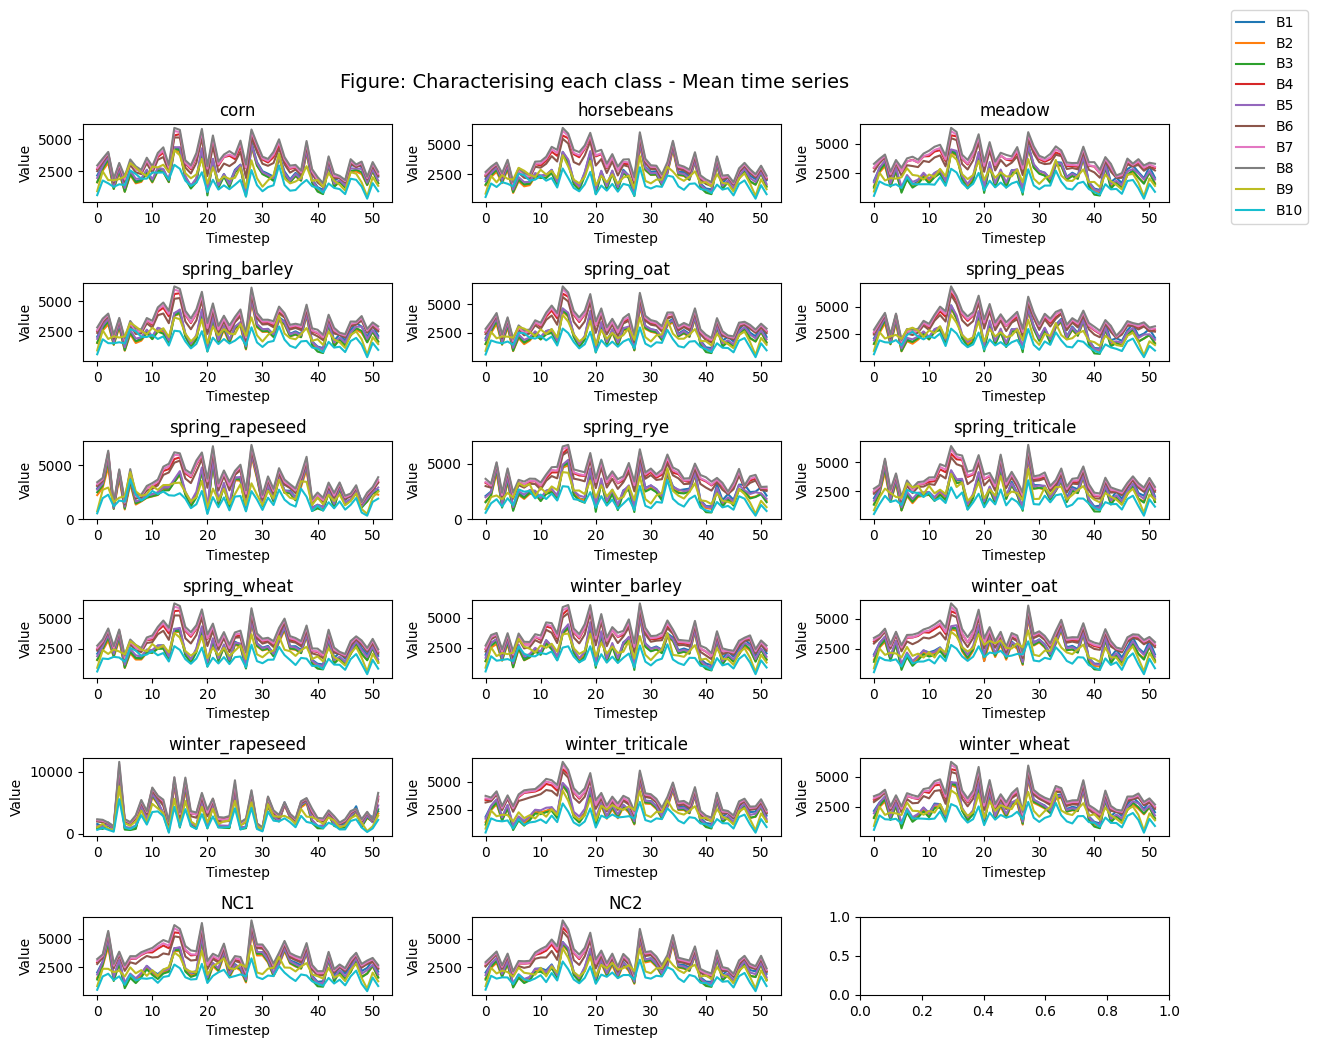

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(12, 10))
axs = axs.ravel()
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10']
for i in range(len(unique)):
  # add band number as legend
  for j in range(X_mean.shape[2]):
    axs[i].plot(X_mean[i, :, j], label=bands[j])
  axs[i].set_title(class_names_data[i])
  axs[i].set_xlabel('Timestep')
  axs[i].set_ylabel('Value')
fig.legend(bands, loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.suptitle('Figure: Characterising each class - Mean time series', fontsize=14)
plt.tight_layout()
plt.show()

The above figure characterises each crop class using the behavior of the 10 bands over a period of 52 timeseteps. From the above figure we can see that only some classes have visibly distinct behavior. For example corn and spring triticale have visible distinct timeseries. However, overall, the timeseries of the classes are more similar than different. This is because, across all bands, the classes seem to show a 'visually' similar behavior for over timestamps. This seems like a great use case for using a deep learning model to identify the patterns among the timeseries across bands and distinguish the classes.

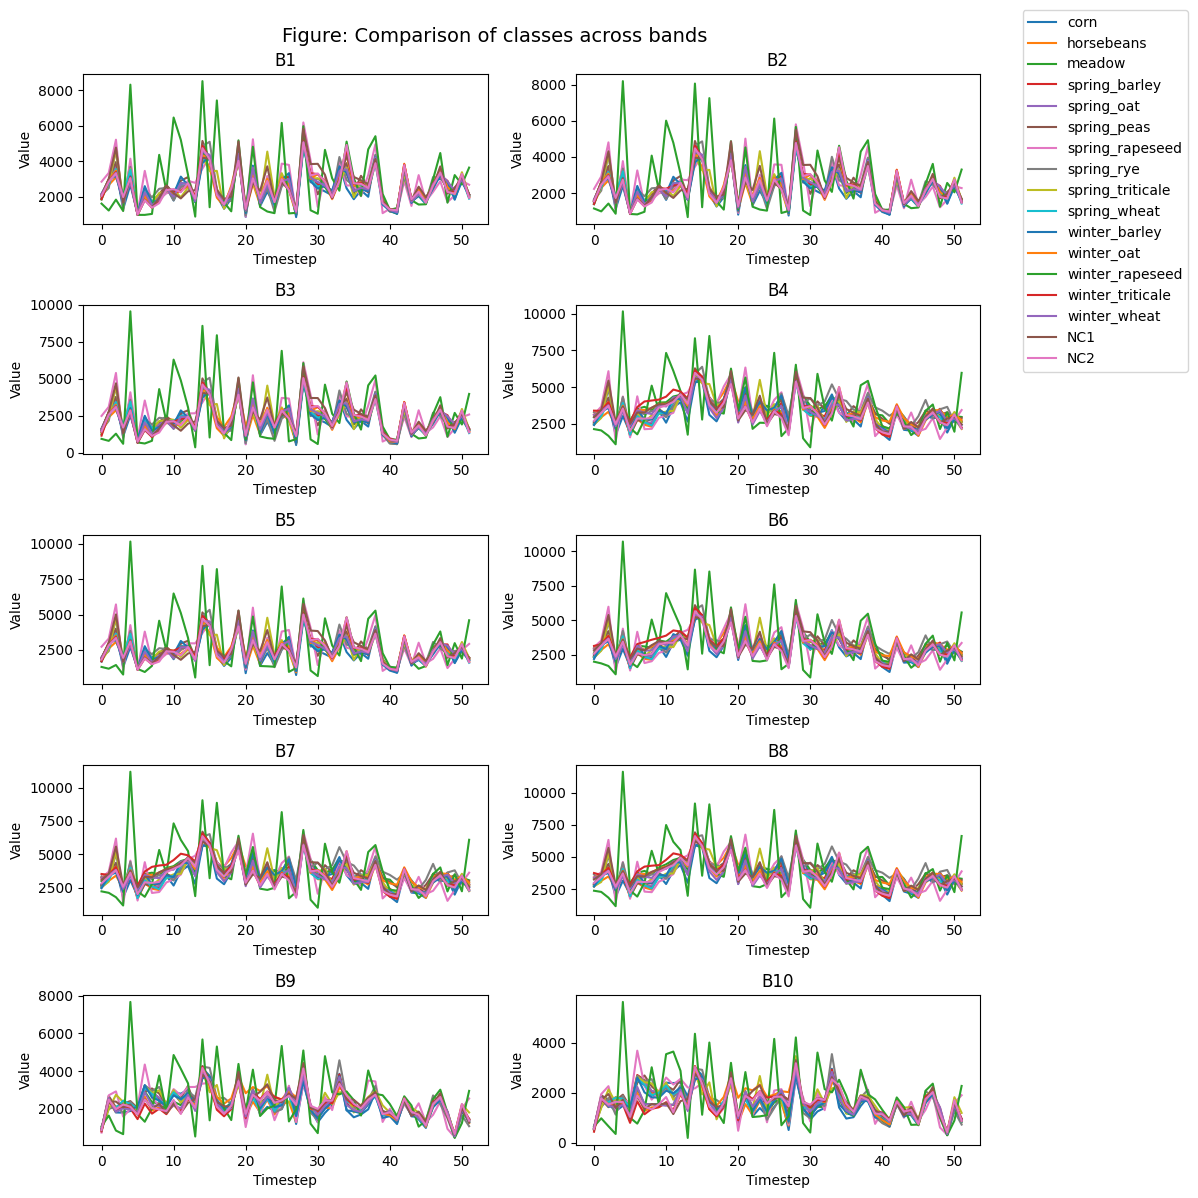

In [ ]:
# comparing the mean time series of the classes
fig, axs = plt.subplots(5,2, figsize=(10, 12))
axs = axs.ravel()
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10']
for i in range(len(bands)):
  # add band number as legend
  for j in range(len(class_names_data)):
    axs[i].plot(X_mean[j,:,i], label=class_names_data[j])
  axs[i].set_title(bands[i])
  axs[i].set_xlabel('Timestep')
  axs[i].set_ylabel('Value')

fig.legend(class_names_data, loc='upper right', bbox_to_anchor=(1.2, 1))
plt.suptitle('Figure: Comparison of classes across bands', fontsize=14)
plt.tight_layout()
plt.show()

The above figure is another view of the mean timeseries. In this figure I try to individually compare each band of each class and see if there are any striking differences in the behavior. Since in the earlier figure, the differences between the bands weren't easily apparent due to the differences in the scales of the different bands.

## 2. Data Preparation

In this section, based on my understanding of the class/label distribution, I write a few important functions to manipulate the data to handle class imbalance and class renumbering. I also derive key data metrics: the minimum and maximum of the data that I will later use to transform the data.

I then write a custom data class that performs the following:
* reads the data
* preprocesses the data
  * deleting classes whose total number of samples are less than a given threshold (<200)
  * relabeling the classes to adjust their numbering
* contains a method to split the data into train, test and validation splits

I then write two transform classes to perform:
* flattening of the matrix
* scaling based on minimum and maximum scaling

Finally, I perform a few checks to ensure that the dataset class and the loader are performing in the expected manner.

### 2.1. Handling Class Imbalance

One way to handle class imbalance is to club the minority classes. But as we can see, even after clubbing these four classes (6,7,8, and 13), they do not yield even a hundred observations. I decide to drop these classes.

In [ ]:
# get labels whose count is less than 200
class_dist = UD_class_distribution(y)
low_sample_classes_dist = class_dist[np.where(class_dist[:,1]<200)]
print("Classes with very low samples: ", low_sample_classes_dist[:,0])
print("Their combined number of samples", np.sum(low_sample_classes_dist[:,1]))
print("\nSince the combined number of samples is also less than 200, it is best we drop them")

# create a filter to drop classes with low samples
filter_condition = np.all([y != i for i in low_sample_classes_dist[:,0]], axis=0)
print("\nShape of X and y before dropping: ", X.shape, y.shape)
X, y = X[filter_condition], y[filter_condition]
print("Shape of X and y after dropping: ", X.shape, y.shape)

Classes with very low samples:  [6.000 7.000 8.000 13.000]
Their combined number of samples 96.0

Since the combined number of samples is also less than 200, it is best we drop them

Shape of X and y before dropping:  (60332, 52, 10) (60332,)
Shape of X and y after dropping:  (60236, 52, 10) (60236,)


In [ ]:
new_class_dist= UD_class_distribution(y)
new_class_dist
#check new class distribution

array([[0.000, 4047.000, 6.719],
       [1.000, 318.000, 0.528],
       [2.000, 12676.000, 21.044],
       [3.000, 13838.000, 22.973],
       [4.000, 1534.000, 2.547],
       [5.000, 339.000, 0.563],
       [9.000, 311.000, 0.516],
       [11.000, 6413.000, 10.646],
       [12.000, 3738.000, 6.206],
       [15.000, 2917.000, 4.843],
       [16.000, 3856.000, 6.401],
       [17.000, 389.000, 0.646],
       [18.000, 9860.000, 16.369]])

Since we apply MLP to our dataset, it's necessary that we renumber our class indices as consecutive integers starting from 0. However, it's useful to retain the mapping so that we can map back to our original classes after predictions.

In [ ]:
# renumbering of classes
unq_arr, unq_tags = np.unique(y), range(0,len(np.unique(y)))
mapping_dict = dict(zip(unq_arr, unq_tags))
mapping_dict # Old class: New class

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 9: 6,
 11: 7,
 12: 8,
 15: 9,
 16: 10,
 17: 11,
 18: 12}

In [ ]:
# rename class labels in y as consecutive integers
y = np.array(pd.Series(y).map(mapping_dict))
UD_class_distribution(y)

array([[0.000, 4047.000, 6.719],
       [1.000, 318.000, 0.528],
       [2.000, 12676.000, 21.044],
       [3.000, 13838.000, 22.973],
       [4.000, 1534.000, 2.547],
       [5.000, 339.000, 0.563],
       [6.000, 311.000, 0.516],
       [7.000, 6413.000, 10.646],
       [8.000, 3738.000, 6.206],
       [9.000, 2917.000, 4.843],
       [10.000, 3856.000, 6.401],
       [11.000, 389.000, 0.646],
       [12.000, 9860.000, 16.369]])

In [ ]:
# we pack the above code into a functions for reusability
def drop_lowsampleclasses(X, y, min_samples=200):
  class_dist = UD_class_distribution(y)
  low_sample_classes_dist = class_dist[np.where(class_dist[:,1]<min_samples)]
  filter_condition = np.all([y != i for i in low_sample_classes_dist[:,0]], axis=0)
  X_, y_ = X[filter_condition], y[filter_condition]
  return low_sample_classes_dist,X_,y_

def relabel_consecutively(y):
  unique_vals = np.unique(y)
  unq_arr, unq_tags = unique_vals, range(0,unique_vals)
  mapping_dict = dict(zip(unq_arr, unq_tags))
  y_ = np.array(pd.Series(y).map(mapping_dict))
  return mapping_dict,y_

In [ ]:
# test functionality
X,y = series,labels #reload X and y since they have been edited in previous blocks
X,y = drop_lowsampleclasses(X, y, min_samples=200)[1:] # drop the observations of classes with less than 200 samples
mapping, y = relabel_consecutively(y) # relabel the classes consecutively
print(X.shape, y.shape, np.unique(y))
print("Class reballeing map", mapping)
# the output matches with the ones achieved previously

(60236, 52, 10) (60236,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Class reballeing map {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 9: 6, 11: 7, 12: 8, 15: 9, 16: 10, 17: 11, 18: 12}


### 2.1. Data Splitting
Startify by class labels

In [ ]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.6,
                                                    random_state=42,
                                                    stratify=y)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (36141, 52, 10)
Shape of y_train: (36141,)
Shape of X_test: (24095, 52, 10)
Shape of y_test: (24095,)


In [ ]:
# check distribution of classes in train and test sets
import pandas as pd
dist_y_train = UD_class_distribution(y_train)
dist_y_test = UD_class_distribution(y_test)

df_train = pd.DataFrame(dist_y_train, columns=['class', 'count_train', 'percentage_train'])
df_test = pd.DataFrame(dist_y_test, columns=['class', 'count_test', 'percentage_test'])

df = pd.merge(df_train, df_test, on='class')
df.sort_values(by=['count_train'], inplace=True, ascending=False)
df.head(20)

class  count_train  percentage_train  count_test  percentage_test
3     3.0       8303.0            22.974      5535.0           22.972
2     2.0       7605.0            21.043      5071.0           21.046
12   12.0       5916.0            16.369      3944.0           16.369
7     7.0       3848.0            10.647      2565.0           10.645
0     0.0       2428.0             6.718      1619.0            6.719
10   10.0       2314.0             6.403      1542.0            6.400
8     8.0       2243.0             6.206      1495.0            6.205
9     9.0       1750.0             4.842      1167.0            4.843
4     4.0        920.0             2.546       614.0            2.548
11   11.0        233.0             0.645       156.0            0.647
5     5.0        203.0             0.562       136.0            0.564
1     1.0        191.0             0.528       127.0            0.527
6     6.0        187.0             0.517       124.0            0.515

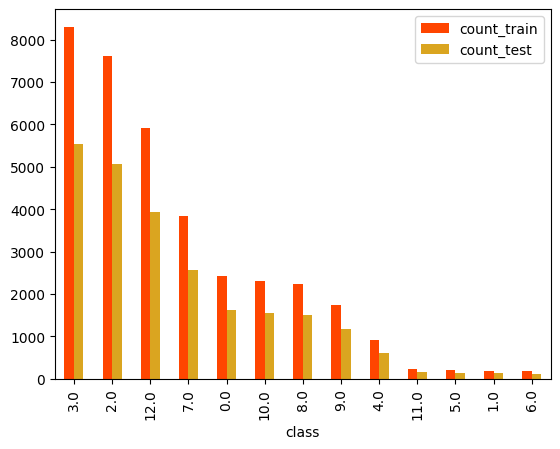

In [ ]:
# visualising the combined plots of train and test
df= df[['class', 'count_train', 'count_test']]
df.plot(x='class', kind= 'bar', color=['orangered', 'goldenrod'])
plt.show()

This graph shows us the relative distribution of each class after splitting the train and test datasets with stratification based on class. I later split the test split obtained above further into val and test.

### 2.2. Data Normalization

In [ ]:
# flatten the time series
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.6,
                                                    random_state=42,
                                                    stratify=y)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (36141, 520)
Shape of X_test: (24095, 520)


In [ ]:
# MinMax scaling setup - obtain min max values to be used in scaling later
minimum = X_train.min(axis=0)
maximum = X_train.max(axis=0)
print(minimum.shape)

(520,)


In [ ]:
# without flattening for LSTM
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.6,
                                                    random_state=42,
                                                    stratify=y)
minimum_2D = X_train.min(axis=0)
maximum_2D= X_train.max(axis=0)
print(minimum_2D.shape)

(52, 10)


### 2.3. Custom Dataset Class for Data Preparation

Custom Dataset classes allow us to load and prepare our data so that the DataLoader can then read this data as batches during the train, validation and test processes. This is important because for large datasets, it is not desirable to load the entire into the memory once. Hence, batches of data are passed.

(Personal note: I found this task to be the most challenging of all. As it initially seemed difficult to both load and preprocess the dataset within the class and also perform the splits. I was only able to perform only one of those tasks fully and the rest would clash either with the Transforms or with the DataLoader. Thanks to the [discuss](https://discuss.pytorch.org/) page on PyTorch, I was able to get some tips from experiences of other users and write my own class. However, there is still a limitation in my approach that I highlight at the end of this section.)

In [ ]:
#@title **Custom Data Class**
class CustomDataset(Dataset):
    def __init__(self, npz_file, transform=None):
        data = np.load(npz_file, allow_pickle= True)
        self.X = data['series']
        self.y = data['labels']
        self.transform = transform
        # drop samples and relabel the classes as consecutive integers
        self.X, self.y = drop_lowsampleclasses(self.X, self.y, min_samples=200)[1:] # drop the observations of classes with less than 200 samples
        self.mapping, self.y = relabel_consecutively(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx]
        labels = self.y[idx]
        # apply necessary transforms
        if self.transform:
            features = self.transform(features)
        # convert into tensors
        features = torch.tensor(features)
        labels =torch.tensor(labels)
        return features, labels

    def train_test_val_splits(self, train_size, test_size):
        train_indices, temp_indices,_,_ = train_test_split(range(len(self)), self.y,
                                          stratify=self.y, train_size=train_size, random_state=42)
        train = Subset(self, train_indices)
        temp = Subset(self, temp_indices)
        targets_temp = [i[1] for i in temp] # list of targets to be used for stratification
        test_size = test_size/(1-train_size)
        val_indices, test_indices, _,_= train_test_split(range(len(temp)), targets_temp,
                                        stratify=targets_temp, test_size=test_size, random_state=42)
        val = Subset(temp, val_indices)
        test = Subset(temp, test_indices)
        print("Order of output splits: Train, Validation, Test")
        return(train, val, test)

In [ ]:
#@title **Custom Transforms**
class Flatten:
    def __call__(self, sample):
        #print(sample.shape)
        reshaped_sample = sample.reshape(sample.shape[0]*sample.shape[1])
        return reshaped_sample

class MinMaxScale:
    def __init__(self, minimum, maximum):
      self.minimum = minimum
      self.maximum = maximum
    def __call__(self, sample):
        features = sample
        features_scaled = (features - self.minimum)/(self.maximum-self.minimum)
        return features_scaled

In [ ]:
#@title **Data Loader**
def generate_loaders(train_split, val_split,test_split,batch_size):
  train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_split, batch_size =batch_size)
  test_loader = DataLoader(test_split, batch_size=batch_size)
  return train_loader, val_loader, test_loader

In [ ]:
transform = transforms.Compose([Flatten(), MinMaxScale(minimum,maximum)]) #minimum, maximum of each feature is calculated and saved during EDA
dataset = CustomDataset(npz_file='/content/drive/MyDrive/MasterCDE/DeepLearning/FinalProject/data_DK1.npz', transform=transform)

In [ ]:
splits = dataset.train_test_val_splits(0.6,0.2) # remaining fraction will be validation
train_loader, val_loader, test_loader = generate_loaders(splits[0], splits[1], splits[2], batch_size=64)

Order of output splits: Train, Validation, Test


In [ ]:
#@title **Sanity Checks**
# Checks to ensure that the custom data class and the loader are behaving in the desired manner

from pprint import pprint
# Class and DataLoader Behavior
# Check 1. Are all the classes with samples < 200 dropped?
print("Check 1: Class distribution: ")
pprint(dict(zip(np.unique(dataset.y, return_counts=True)[0], np.unique(dataset.y, return_counts=True)[1])))
# Check 2. Have the classes been renumbered consecutively?
print("Check 2: Consecutive renumbering of classes (mapping: old_class: new_class): ")
pprint(dataset.mapping )
# Check 3. Is the random seed used for train-test splitting yielding consistent result (as during EDA) for training data?
# This is important because we want to make sure that our constants 'minimum' and 'maximum' passed to
# the Scaling Transform are apt for the val and test splits generated by the class method train_test_val_splits()
# (i.e. are the min and max values applicable to the new splits as well?)
scaled_data = torch.tensor((X_train-minimum)/(maximum-minimum))
transform_data = torch.tensor(np.array([i[0].numpy() for i in splits[0]]))
difference = torch.norm(transform_data-scaled_data)
print("Check 3: Scaling: Norm value of the difference tensor (Zero would imply consistence of splits with and without Dataset class)= ", difference)

# Transform Behavior
# Check 4: Have the input features been flattened?
print("Check 4: Flattening: Shape of X:", splits[0][0][0].shape)
# Check 5: Have the inputs been scaled? This is verified as part of Check 3

# Other Methods
# Check 6: Is the splitting method defined inside the class working?
print("Check 6: Splits: Lengths of Train, Val and Test ", len(splits[0]), len(splits[1]), len(splits[2]))

Check 1: Class distribution: 
{0: 4047,
 1: 318,
 2: 12676,
 3: 13838,
 4: 1534,
 5: 339,
 6: 311,
 7: 6413,
 8: 3738,
 9: 2917,
 10: 3856,
 11: 389,
 12: 9860}
Check 2: Consecutive renumbering of classes (mapping: old_class: new_class): 
{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 9: 6,
 11: 7,
 12: 8,
 15: 9,
 16: 10,
 17: 11,
 18: 12}
Check 3: Scaling: Norm value of the difference tensor (Zero would imply consistence of splits with and without Dataset class)=  tensor(0., dtype=torch.float64)
Check 4: Flattening: Shape of X: torch.Size([520])
Check 6: Splits: Lengths of Train, Val and Test  36141 12047 12048


Above tests confirm that our class and transforms are behaving in a desirable manner.

**Limitation of above approach**

In the current set up, I am having to calculate 'minimum' and 'maximum' of the `X_train` during the EDA section and then pass them as arguments to my MinMaxScale Transform. The limitation with this approach is that I am already loading the entire dataset into memory in order to calculate the min and max. I could not find a way to calculate them from within the class. This is because, the minimum and maximum need to be calculated on the '`X_Train`' and then used on all the three - Train, Test and Validation. But from the class, I was not able to figure out how to calculate these values. Perhaps one way was to add a method within the class to do so and pass only the train split after calling the `train_test_val_splits()` method - but I didn't explore this further.

One way I am ensuring that the X_train generated while obtaining 'min' and 'max' is same as the X_train generated through the `train_test_val_splits()` method of the dataset class is by fixing the random seed - this ensures both splits are same and **hence the min and max are valid.**

## 3. Deep Learning Models

### 3.1. Ancilliary functions

In [ ]:
#@title **Plot Metrics**
def plot_eval(epochs,train_loader,train_loss,val_loss,train_accuracy, val_accuracy):
  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Loss')
  plt.plot(list(range(epochs*len(train_loader))),train_loss, label="train")
  plt.plot(list(range(0, epochs*len(train_loader),len(train_loader))), val_loss, label="val")
  plt.xlabel('Iterations')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Accuracy')
  plt.plot(list(range(epochs)), train_accuracy, label="train")
  plt.plot(list(range(epochs)),val_accuracy, label="val")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
#@title **Plot Metrics - Early stop**

def plot_estop_eval(stop_e, train_loader,train_loss,val_loss,train_accuracy, val_accuracy):

  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Loss')
  plt.plot(list(range((stop_e+1)*len(train_loader))),train_loss, label="train")
  plt.plot(list(range(0, (stop_e+1)*len(train_loader),len(train_loader))), val_loss, label="val")
  plt.xlabel('Iterations')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Accuracy')
  plt.plot(list(range(stop_e+1)), train_accuracy, label="train")
  plt.plot(list(range(stop_e+1)),val_accuracy, label="val")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()


In [ ]:
#@title **Loss function**
def loss_func(logits, y):
    return nn.CrossEntropyLoss()(logits, y)

In [ ]:
#@title **Train Epoch and Val Epoch**
def train_epoch(model, optimizer, loss_func, dataloader, device):
  model.train()
  train_correct = 0
  train_loss = []
  for x_train_batch, y_train_batch in dataloader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)

    y_hat = model(x_train_batch) # forward pass

    loss = loss_func(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat.detach().cpu(), axis=1) # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch.cpu())
    train_loss.append(loss.item()/len(x_train_batch))
  train_accuracy = train_correct/len(dataloader.dataset)
  return train_loss, train_accuracy

def val_epoch(model, loss_func, dataloader, device):
  model.eval()
  tmp_val_loss = 0
  val_correct = 0
  with torch.no_grad():
    for x_val_batch, y_val_batch in dataloader:
      x_val_batch = x_val_batch.to(device)
      y_val_batch = y_val_batch.to(device)
      y_val_hat = model(x_val_batch) # forward pass
      tmp_val_loss += loss_func(y_val_hat, y_val_batch).item() # compute the loss
      y_val_hat_class = torch.argmax(y_val_hat.detach().cpu(), axis=1) # we assign an appropriate label based on the network's prediction
      val_correct += torch.sum(y_val_hat_class==y_val_batch.cpu())
  val_loss = tmp_val_loss/len(dataloader.dataset) # compute the average loss
  val_accuracy = val_correct/len(dataloader.dataset)
  return val_loss, val_accuracy


In [ ]:
#@title **Train Loop**
def train_and_validate(model, optimizer, loss_func, train_loader, val_loader, save_path, epochs=40):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss = []       # where we keep track of the training loss
    train_accuracy = []   # where we keep track of the training accuracy of the model
    val_loss = []         # where we keep track of the validation loss
    val_accuracy = []     # where we keep track of the validation accuracy of the model

    model.to(device)
    min_val_loss = np.Inf

    for e in range(epochs):
        epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_loader, device)
        epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, val_loader, device)

        train_loss.extend(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)
        print(f'Epoch {e + 1}/{epochs}, Epoch validation loss: {epoch_val_loss:.4f}, Train acc.: {epoch_train_accuracy:.4f}, Validation acc.: {epoch_val_accuracy:.4f}')
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'e_loss': epoch_val_loss,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss':val_loss,
                'val_accuracy':val_accuracy
            }, save_path)

    print('Training finished.')
    return train_loss, train_accuracy, val_loss, val_accuracy


In [ ]:
#@title **Test Model**
def test_model(model, test_loader, loss_func, title):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_samples = len(test_loader.dataset)

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # print(outputs.shape)
            loss = loss_func(outputs, labels.long())
            test_loss += loss.item()
            _, predicted = outputs.max(1) # gets predicted class, discards max values obtained across 13 classes
            # print(outputs.max(1))
            correct_predictions += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    unique_labels = sorted(set(all_labels + all_preds))

    fig, ax = plt.subplots(figsize=(8,8))
    cm  = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)  # Adjust display_labels as needed
    disp.plot(ax=ax)
    plt.title(title)
    plt.show()

    avg_loss = test_loss / len(test_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

### 3.2. Multi-Layer Perceptron (MLP)

An MLP is a feedforward artificial neural network that has fully connected neurons with a nonlinear activation function. It requires the input to be a flat array - requiring us to squash the temporal dimension and flattening the data. In the architecture for the Basic MLP I have chosen a relu activation function.

#### 3.2.1. Baseline MLP

In [ ]:
num_features_mlp = 520 #obtaines after flattening
num_classes = len(np.unique(dataset.y))
num_features_mlp, num_classes

(520, 13)

In [ ]:
# develop the MLP architecture
class BasicMLP(nn.Module):
    def __init__(self, in_size, hidden_units, out_size):
        super(BasicMLP, self).__init__()
        # Let us now define the linear layers we need:
        self.fc1 = nn.Linear(in_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units) #fully connected layer
        self.fc3 = nn.Linear(hidden_units, out_size)
        self.double()

    # We have also to define what is the forward of this module:
    def forward(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        h2 = nn.functional.relu(self.fc2(h1))
        logits = self.fc3(h2)
        return logits

In [ ]:
input_size = num_features_mlp
output_size = num_classes
hidden_size = 256

In [ ]:
# Define the input size, hidden size, and output size
mlp_model = BasicMLP(input_size, hidden_size, output_size)
print(mlp_model)

BasicMLP(
  (fc1): Linear(in_features=520, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=13, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01,)
save_path = root+ 'best_basicMLP.pth'

# perform training, save the model at the best epoch val_loss
train_loss,train_accuracy, val_loss, val_accuracy=train_and_validate(mlp_model,optimizer, loss_func,
                                                                     train_loader, val_loader , save_path, epochs=60)

Epoch 1/60, Epoch validation loss: 0.0133, Train acc.: 0.6261, Validation acc.: 0.7281
Epoch 2/60, Epoch validation loss: 0.0109, Train acc.: 0.7355, Validation acc.: 0.7793
Epoch 3/60, Epoch validation loss: 0.0131, Train acc.: 0.7622, Validation acc.: 0.7291
Epoch 4/60, Epoch validation loss: 0.0104, Train acc.: 0.7758, Validation acc.: 0.7926
Epoch 5/60, Epoch validation loss: 0.0108, Train acc.: 0.7869, Validation acc.: 0.7897
Epoch 6/60, Epoch validation loss: 0.0149, Train acc.: 0.7887, Validation acc.: 0.7198
Epoch 7/60, Epoch validation loss: 0.0104, Train acc.: 0.7922, Validation acc.: 0.7932
Epoch 8/60, Epoch validation loss: 0.0107, Train acc.: 0.7992, Validation acc.: 0.7846
Epoch 9/60, Epoch validation loss: 0.0107, Train acc.: 0.8012, Validation acc.: 0.7853
Epoch 10/60, Epoch validation loss: 0.0094, Train acc.: 0.8112, Validation acc.: 0.8091
Epoch 11/60, Epoch validation loss: 0.0095, Train acc.: 0.8102, Validation acc.: 0.8098
Epoch 12/60, Epoch validation loss: 0.009

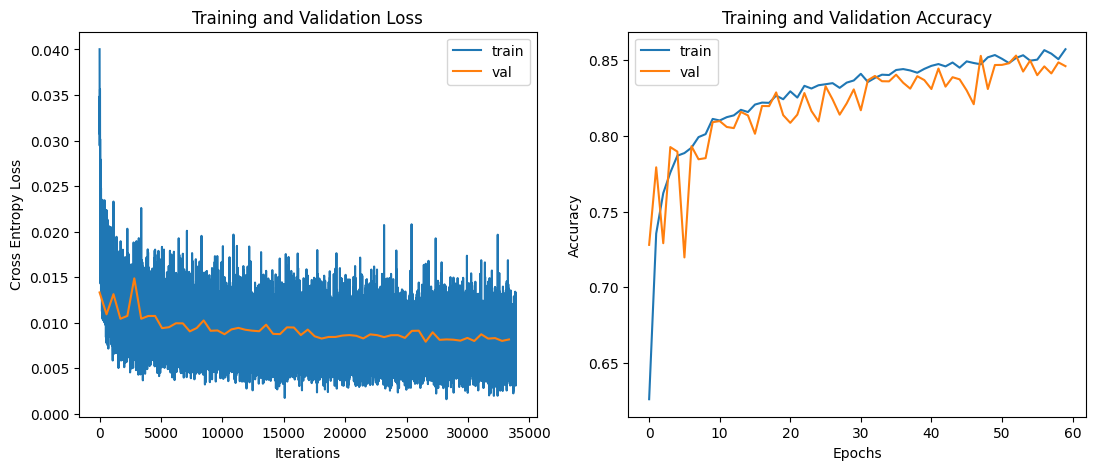

In [ ]:
plot_eval(60,train_loader,train_loss,val_loss,train_accuracy, val_accuracy)

In the above graph we see that the learning curves for both train and validation data follow closely. This means that the model that has been trained fits the data reasonably. However, the ruggedness or the zig zag in the validation accuracy reveals that the modern can learn better.

In [ ]:
# reconstruct path of the best trial
path = root+'best_basicMLP.pth'
state_dict = torch.load(path)
print(f"Best validation epoch loss Obtained in Basic MLP: {state_dict['loss']:.4f}")

model_1 = BasicMLP(input_size, hidden_size, output_size) # to be used later for testing
model_1.load_state_dict(state_dict['model_state_dict'])

Best validation epoch loss Obtained in Basic MLP: 0.0079


<All keys matched successfully>

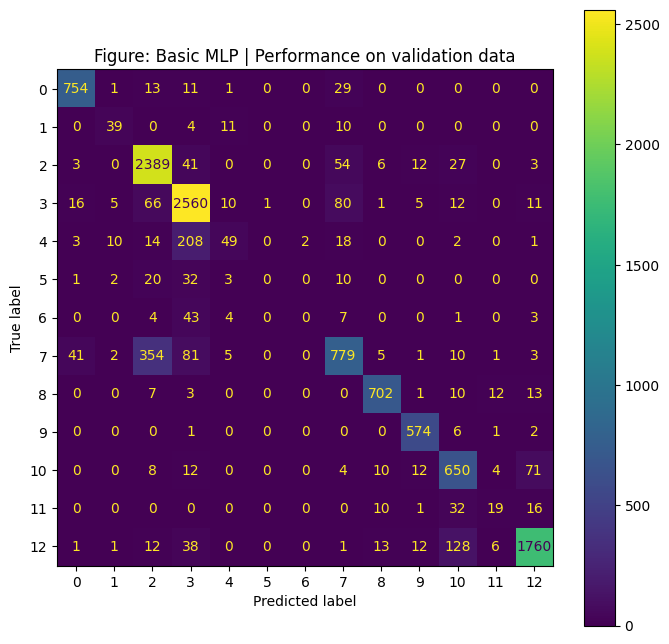

Loss: 0.5050, Accuracy: 85.29%


(0.5050307956737413, 85.29094380343653)

In [ ]:
#@title **Val Performance**
# performance on validation data
test_model(model_1, val_loader, loss_func, 'Figure: Basic MLP | Performance on validation data')

We can see from the confusion matrix above of the validation data that the Basic MLP performs poorly on minority classes. Further, class 7 is also heavily misclassified.

#### 3.2.2. Finetuning architecture

In order to improve our model, I finetune the architecture of the MLP. I do this by tuning the number of layers, number of hidden units in the architecture. For this I create a new MLP class that loops over the number of the layers to combine them sequentially to form the full network.

It is crucial to tune the number of hidden layers and hidden units so that model generalises desirably well, but also doesn't overfit. Increasing number of layers or hidden units can cause overfitting.

I also modify train loop to add early stopping so that the model does not overfit while finding optimal parameters and also because it is computationally efficient as it stops the training loop if the validation loss is not dropped in subsequent steps.

In [ ]:
#@title **Modified Train loop**

# add early stopping
def mod_train_and_validate(model, optimizer, loss_func, train_loader, val_loader, save_path, epochs=40, patience= 5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss = []       # where we keep track of the training loss
    train_accuracy = []   # where we keep track of the training accuracy of the model
    val_loss = []         # where we keep track of the validation loss
    val_accuracy = []     # where we keep track of the validation accuracy of the model

    model.to(device)
    min_val_loss = np.Inf
    counter = 0
    delta_p = 0 #-- minimum change required in the monitored quantity (e.g. validation loss) to qualify as an improvement


    for e in range(epochs):
        epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_loader, device)
        epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, val_loader, device)

        train_loss.extend(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)
        print(f'Epoch {e + 1}/{epochs}, Epoch validation loss: {epoch_val_loss:.4f}, Train acc: {epoch_train_accuracy:.4f}, Validation acc: {epoch_val_accuracy:.4f}')
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'e_loss': epoch_val_loss,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss':val_loss,
                'val_accuracy':val_accuracy
            }, save_path)
        elif epoch_val_loss-min_val_loss > delta_p:
          counter = counter + 1
        if counter == patience:
          break

    print('Training finished.')
    return train_loss, train_accuracy, val_loss, val_accuracy, e


In [ ]:
#@title **Modified MLP 1**
# Rewrite the class to dynamically input hidden size and layers
class ModMLP(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_units):
        super(ModMLP, self).__init__()

        # Input layer
        layers = [nn.Linear(input_size, hidden_units)]

        # Hidden layers with ReLU activation
        for _ in range(num_layers - 2):  # -2 because we already added one layer above and no ReLU after the last layer
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.ReLU(inplace=True))
        # Output
        layers.append(nn.Linear(hidden_units, output_size))

        # Combine all layers into the model
        self.mlp = nn.Sequential(*layers)
        self.double()

    def forward(self, x):
        return self.mlp(x)

In [ ]:
def objective(trial):
    params = {
        'input_size':num_features,
        'output_size': num_classes,
        'num_layers': trial.suggest_categorical('num_layers', [1,2,3,4]),
        'hidden_units': trial.suggest_categorical('num_hidden_units', [32,64,128,256])
        }
    trial_number = trial.number
    # define the model with the given parameters, make predictions
    model = ModMLP(**params)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # create a new path for saving the best epoch model for each trial
    # since we do not know in advance which trial will the best, we will have to save all
    # and then read the best epoch of the best trial at the end
    save_path = root + f'trial_{trial_number}' + 'best_ModMLP.pth'
    train_loss,train_accuracy, val_loss, val_accuracy,e=mod_train_and_validate(model,optimizer, loss_func,
                                                                             train_loader, val_loader,save_path=save_path,
                                                                             epochs=60)
    return val_loss[-1]

In [ ]:
%%time
sampler = TPESampler(seed=123)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2024-01-06 14:44:19,841] A new study created in memory with name: no-name-bcecbcfe-17b7-48db-81b4-533ae7654095


Epoch 1/60, Epoch validation loss: 0.0157, Train acc: 0.6422, Validation acc: 0.6847
Epoch 2/60, Epoch validation loss: 0.0128, Train acc: 0.7283, Validation acc: 0.7477
Epoch 3/60, Epoch validation loss: 0.0117, Train acc: 0.7467, Validation acc: 0.7734
Epoch 4/60, Epoch validation loss: 0.0126, Train acc: 0.7533, Validation acc: 0.7432
Epoch 5/60, Epoch validation loss: 0.0121, Train acc: 0.7630, Validation acc: 0.7605
Epoch 6/60, Epoch validation loss: 0.0125, Train acc: 0.7662, Validation acc: 0.7579
Epoch 7/60, Epoch validation loss: 0.0115, Train acc: 0.7817, Validation acc: 0.7745
Epoch 8/60, Epoch validation loss: 0.0117, Train acc: 0.7814, Validation acc: 0.7675
Epoch 9/60, Epoch validation loss: 0.0111, Train acc: 0.7846, Validation acc: 0.8012
Epoch 10/60, Epoch validation loss: 0.0110, Train acc: 0.7885, Validation acc: 0.7951
Epoch 11/60, Epoch validation loss: 0.0102, Train acc: 0.7885, Validation acc: 0.8148


[I 2024-01-06 14:44:52,872] Trial 0 finished with value: 0.011484318141464143 and parameters: {'num_layers': 1, 'num_hidden_units': 128}. Best is trial 0 with value: 0.011484318141464143.


Epoch 12/60, Epoch validation loss: 0.0115, Train acc: 0.7944, Validation acc: 0.7768
Training finished.
Epoch 1/60, Epoch validation loss: 0.0186, Train acc: 0.5834, Validation acc: 0.6465
Epoch 2/60, Epoch validation loss: 0.0137, Train acc: 0.7038, Validation acc: 0.7214
Epoch 3/60, Epoch validation loss: 0.0144, Train acc: 0.7269, Validation acc: 0.7130
Epoch 4/60, Epoch validation loss: 0.0135, Train acc: 0.7326, Validation acc: 0.7280
Epoch 5/60, Epoch validation loss: 0.0119, Train acc: 0.7430, Validation acc: 0.7587
Epoch 6/60, Epoch validation loss: 0.0138, Train acc: 0.7397, Validation acc: 0.7253
Epoch 7/60, Epoch validation loss: 0.0126, Train acc: 0.7474, Validation acc: 0.7595
Epoch 8/60, Epoch validation loss: 0.0121, Train acc: 0.7632, Validation acc: 0.7575
Epoch 9/60, Epoch validation loss: 0.0118, Train acc: 0.7607, Validation acc: 0.7687


[I 2024-01-06 14:45:24,685] Trial 1 finished with value: 0.01306929189733038 and parameters: {'num_layers': 4, 'num_hidden_units': 256}. Best is trial 0 with value: 0.011484318141464143.


Epoch 10/60, Epoch validation loss: 0.0131, Train acc: 0.7628, Validation acc: 0.7311
Training finished.
Epoch 1/60, Epoch validation loss: 0.0135, Train acc: 0.6139, Validation acc: 0.7203
Epoch 2/60, Epoch validation loss: 0.0125, Train acc: 0.7291, Validation acc: 0.7443
Epoch 3/60, Epoch validation loss: 0.0113, Train acc: 0.7559, Validation acc: 0.7676
Epoch 4/60, Epoch validation loss: 0.0116, Train acc: 0.7697, Validation acc: 0.7611
Epoch 5/60, Epoch validation loss: 0.0111, Train acc: 0.7785, Validation acc: 0.7832
Epoch 6/60, Epoch validation loss: 0.0104, Train acc: 0.7801, Validation acc: 0.7960
Epoch 7/60, Epoch validation loss: 0.0107, Train acc: 0.7820, Validation acc: 0.7892
Epoch 8/60, Epoch validation loss: 0.0104, Train acc: 0.7915, Validation acc: 0.7936
Epoch 9/60, Epoch validation loss: 0.0099, Train acc: 0.7918, Validation acc: 0.8078
Epoch 10/60, Epoch validation loss: 0.0101, Train acc: 0.7945, Validation acc: 0.8040


[I 2024-01-06 14:45:54,116] Trial 2 finished with value: 0.01009797687713828 and parameters: {'num_layers': 4, 'num_hidden_units': 64}. Best is trial 2 with value: 0.01009797687713828.


Epoch 11/60, Epoch validation loss: 0.0101, Train acc: 0.7960, Validation acc: 0.8017
Training finished.
Epoch 1/60, Epoch validation loss: 0.0148, Train acc: 0.6565, Validation acc: 0.6868
Epoch 2/60, Epoch validation loss: 0.0123, Train acc: 0.7390, Validation acc: 0.7513
Epoch 3/60, Epoch validation loss: 0.0119, Train acc: 0.7530, Validation acc: 0.7646
Epoch 4/60, Epoch validation loss: 0.0142, Train acc: 0.7617, Validation acc: 0.7228
Epoch 5/60, Epoch validation loss: 0.0114, Train acc: 0.7713, Validation acc: 0.7770
Epoch 6/60, Epoch validation loss: 0.0121, Train acc: 0.7767, Validation acc: 0.7663
Epoch 7/60, Epoch validation loss: 0.0115, Train acc: 0.7809, Validation acc: 0.7912
Epoch 8/60, Epoch validation loss: 0.0117, Train acc: 0.7890, Validation acc: 0.7746
Epoch 9/60, Epoch validation loss: 0.0111, Train acc: 0.7884, Validation acc: 0.7915


[I 2024-01-06 14:46:20,267] Trial 3 finished with value: 0.012387776486508588 and parameters: {'num_layers': 1, 'num_hidden_units': 64}. Best is trial 2 with value: 0.01009797687713828.


Epoch 10/60, Epoch validation loss: 0.0124, Train acc: 0.7950, Validation acc: 0.7726
Training finished.
Epoch 1/60, Epoch validation loss: 0.0134, Train acc: 0.6529, Validation acc: 0.7375
Epoch 2/60, Epoch validation loss: 0.0118, Train acc: 0.7303, Validation acc: 0.7766
Epoch 3/60, Epoch validation loss: 0.0143, Train acc: 0.7424, Validation acc: 0.7132
Epoch 4/60, Epoch validation loss: 0.0114, Train acc: 0.7547, Validation acc: 0.7799
Epoch 5/60, Epoch validation loss: 0.0129, Train acc: 0.7661, Validation acc: 0.7378
Epoch 6/60, Epoch validation loss: 0.0112, Train acc: 0.7701, Validation acc: 0.7919
Epoch 7/60, Epoch validation loss: 0.0130, Train acc: 0.7756, Validation acc: 0.7731
Epoch 8/60, Epoch validation loss: 0.0121, Train acc: 0.7804, Validation acc: 0.7741
Epoch 9/60, Epoch validation loss: 0.0104, Train acc: 0.7857, Validation acc: 0.8021
Epoch 10/60, Epoch validation loss: 0.0100, Train acc: 0.7908, Validation acc: 0.8098


[I 2024-01-06 14:46:50,646] Trial 4 finished with value: 0.011170688192904744 and parameters: {'num_layers': 2, 'num_hidden_units': 128}. Best is trial 2 with value: 0.01009797687713828.


Epoch 11/60, Epoch validation loss: 0.0112, Train acc: 0.7894, Validation acc: 0.7954
Training finished.
Epoch 1/60, Epoch validation loss: 0.0136, Train acc: 0.6414, Validation acc: 0.7296
Epoch 2/60, Epoch validation loss: 0.0139, Train acc: 0.7175, Validation acc: 0.7133
Epoch 3/60, Epoch validation loss: 0.0142, Train acc: 0.7342, Validation acc: 0.7337
Epoch 4/60, Epoch validation loss: 0.0130, Train acc: 0.7479, Validation acc: 0.7546
Epoch 5/60, Epoch validation loss: 0.0140, Train acc: 0.7498, Validation acc: 0.7394
Epoch 6/60, Epoch validation loss: 0.0165, Train acc: 0.7574, Validation acc: 0.6426
Epoch 7/60, Epoch validation loss: 0.0118, Train acc: 0.7586, Validation acc: 0.7776
Epoch 8/60, Epoch validation loss: 0.0115, Train acc: 0.7737, Validation acc: 0.7799


[I 2024-01-06 14:47:15,653] Trial 5 finished with value: 0.011556201315530446 and parameters: {'num_layers': 1, 'num_hidden_units': 256}. Best is trial 2 with value: 0.01009797687713828.


Epoch 9/60, Epoch validation loss: 0.0116, Train acc: 0.7694, Validation acc: 0.7954
Training finished.
Epoch 1/60, Epoch validation loss: 0.0138, Train acc: 0.6103, Validation acc: 0.7046
Epoch 2/60, Epoch validation loss: 0.0134, Train acc: 0.7273, Validation acc: 0.7325
Epoch 3/60, Epoch validation loss: 0.0112, Train acc: 0.7576, Validation acc: 0.7726
Epoch 4/60, Epoch validation loss: 0.0117, Train acc: 0.7703, Validation acc: 0.7573
Epoch 5/60, Epoch validation loss: 0.0128, Train acc: 0.7811, Validation acc: 0.7145
Epoch 6/60, Epoch validation loss: 0.0114, Train acc: 0.7902, Validation acc: 0.7732
Epoch 7/60, Epoch validation loss: 0.0100, Train acc: 0.7932, Validation acc: 0.8018
Epoch 8/60, Epoch validation loss: 0.0103, Train acc: 0.7936, Validation acc: 0.7970
Epoch 9/60, Epoch validation loss: 0.0100, Train acc: 0.7983, Validation acc: 0.7976


[I 2024-01-06 14:47:42,453] Trial 6 finished with value: 0.010012934124250219 and parameters: {'num_layers': 4, 'num_hidden_units': 32}. Best is trial 6 with value: 0.010012934124250219.


Epoch 10/60, Epoch validation loss: 0.0100, Train acc: 0.8057, Validation acc: 0.8039
Training finished.
Epoch 1/60, Epoch validation loss: 0.0148, Train acc: 0.5655, Validation acc: 0.6985
Epoch 2/60, Epoch validation loss: 0.0143, Train acc: 0.6955, Validation acc: 0.7027
Epoch 3/60, Epoch validation loss: 0.0151, Train acc: 0.7048, Validation acc: 0.6873
Epoch 4/60, Epoch validation loss: 0.0153, Train acc: 0.7147, Validation acc: 0.6897
Epoch 5/60, Epoch validation loss: 0.0256, Train acc: 0.4653, Validation acc: 0.4199
Epoch 6/60, Epoch validation loss: 0.0246, Train acc: 0.4201, Validation acc: 0.4325


[I 2024-01-06 14:48:01,641] Trial 7 finished with value: 0.02497648086138465 and parameters: {'num_layers': 3, 'num_hidden_units': 256}. Best is trial 6 with value: 0.010012934124250219.


Epoch 7/60, Epoch validation loss: 0.0250, Train acc: 0.4199, Validation acc: 0.4204
Training finished.
Epoch 1/60, Epoch validation loss: 0.0213, Train acc: 0.6349, Validation acc: 0.5808
Epoch 2/60, Epoch validation loss: 0.0128, Train acc: 0.7122, Validation acc: 0.7529
Epoch 3/60, Epoch validation loss: 0.0153, Train acc: 0.7308, Validation acc: 0.7263
Epoch 4/60, Epoch validation loss: 0.0134, Train acc: 0.7435, Validation acc: 0.7448
Epoch 5/60, Epoch validation loss: 0.0138, Train acc: 0.7506, Validation acc: 0.7523
Epoch 6/60, Epoch validation loss: 0.0145, Train acc: 0.7531, Validation acc: 0.7360
Epoch 7/60, Epoch validation loss: 0.0117, Train acc: 0.7708, Validation acc: 0.7765


[I 2024-01-06 14:48:24,149] Trial 8 finished with value: 0.012317386565775414 and parameters: {'num_layers': 1, 'num_hidden_units': 256}. Best is trial 6 with value: 0.010012934124250219.


Epoch 8/60, Epoch validation loss: 0.0123, Train acc: 0.7757, Validation acc: 0.7727
Training finished.
Epoch 1/60, Epoch validation loss: 0.0164, Train acc: 0.6432, Validation acc: 0.6782
Epoch 2/60, Epoch validation loss: 0.0133, Train acc: 0.7194, Validation acc: 0.7396
Epoch 3/60, Epoch validation loss: 0.0134, Train acc: 0.7305, Validation acc: 0.7526
Epoch 4/60, Epoch validation loss: 0.0133, Train acc: 0.7478, Validation acc: 0.7483
Epoch 5/60, Epoch validation loss: 0.0130, Train acc: 0.7529, Validation acc: 0.7622
Epoch 6/60, Epoch validation loss: 0.0121, Train acc: 0.7574, Validation acc: 0.7875
Epoch 7/60, Epoch validation loss: 0.0126, Train acc: 0.7668, Validation acc: 0.7607
Epoch 8/60, Epoch validation loss: 0.0126, Train acc: 0.7743, Validation acc: 0.7415
Epoch 9/60, Epoch validation loss: 0.0138, Train acc: 0.7710, Validation acc: 0.7355


[I 2024-01-06 14:48:52,276] Trial 9 finished with value: 0.012344579770356029 and parameters: {'num_layers': 2, 'num_hidden_units': 256}. Best is trial 6 with value: 0.010012934124250219.


Epoch 10/60, Epoch validation loss: 0.0123, Train acc: 0.7764, Validation acc: 0.7655
Training finished.
Epoch 1/60, Epoch validation loss: 0.0144, Train acc: 0.6199, Validation acc: 0.6892
Epoch 2/60, Epoch validation loss: 0.0134, Train acc: 0.7272, Validation acc: 0.7242
Epoch 3/60, Epoch validation loss: 0.0111, Train acc: 0.7569, Validation acc: 0.7743
Epoch 4/60, Epoch validation loss: 0.0103, Train acc: 0.7690, Validation acc: 0.7904
Epoch 5/60, Epoch validation loss: 0.0101, Train acc: 0.7775, Validation acc: 0.7965
Epoch 6/60, Epoch validation loss: 0.0102, Train acc: 0.7856, Validation acc: 0.7961
Epoch 7/60, Epoch validation loss: 0.0108, Train acc: 0.7905, Validation acc: 0.7848
Epoch 8/60, Epoch validation loss: 0.0102, Train acc: 0.7949, Validation acc: 0.7961
Epoch 9/60, Epoch validation loss: 0.0107, Train acc: 0.7951, Validation acc: 0.7985


[I 2024-01-06 14:49:19,485] Trial 10 finished with value: 0.010772726246667147 and parameters: {'num_layers': 4, 'num_hidden_units': 32}. Best is trial 6 with value: 0.010012934124250219.


Epoch 10/60, Epoch validation loss: 0.0108, Train acc: 0.8004, Validation acc: 0.7926
Training finished.
Epoch 1/60, Epoch validation loss: 0.0138, Train acc: 0.5949, Validation acc: 0.7147
Epoch 2/60, Epoch validation loss: 0.0127, Train acc: 0.7130, Validation acc: 0.7405
Epoch 3/60, Epoch validation loss: 0.0128, Train acc: 0.7440, Validation acc: 0.7384
Epoch 4/60, Epoch validation loss: 0.0108, Train acc: 0.7585, Validation acc: 0.7776
Epoch 5/60, Epoch validation loss: 0.0108, Train acc: 0.7727, Validation acc: 0.7887
Epoch 6/60, Epoch validation loss: 0.0106, Train acc: 0.7775, Validation acc: 0.7869
Epoch 7/60, Epoch validation loss: 0.0105, Train acc: 0.7827, Validation acc: 0.7905
Epoch 8/60, Epoch validation loss: 0.0099, Train acc: 0.7905, Validation acc: 0.7994
Epoch 9/60, Epoch validation loss: 0.0096, Train acc: 0.7930, Validation acc: 0.8086
Epoch 10/60, Epoch validation loss: 0.0099, Train acc: 0.7952, Validation acc: 0.8017
Epoch 11/60, Epoch validation loss: 0.0097, 

[I 2024-01-06 14:49:59,945] Trial 11 finished with value: 0.009800865682475846 and parameters: {'num_layers': 4, 'num_hidden_units': 32}. Best is trial 11 with value: 0.009800865682475846.


Epoch 15/60, Epoch validation loss: 0.0098, Train acc: 0.8148, Validation acc: 0.8122
Training finished.
Epoch 1/60, Epoch validation loss: 0.0142, Train acc: 0.6064, Validation acc: 0.6993
Epoch 2/60, Epoch validation loss: 0.0138, Train acc: 0.7142, Validation acc: 0.7090
Epoch 3/60, Epoch validation loss: 0.0121, Train acc: 0.7395, Validation acc: 0.7490
Epoch 4/60, Epoch validation loss: 0.0120, Train acc: 0.7674, Validation acc: 0.7530
Epoch 5/60, Epoch validation loss: 0.0117, Train acc: 0.7688, Validation acc: 0.7651
Epoch 6/60, Epoch validation loss: 0.0108, Train acc: 0.7837, Validation acc: 0.7892
Epoch 7/60, Epoch validation loss: 0.0103, Train acc: 0.7842, Validation acc: 0.7956
Epoch 8/60, Epoch validation loss: 0.0099, Train acc: 0.7914, Validation acc: 0.8043
Epoch 9/60, Epoch validation loss: 0.0099, Train acc: 0.7931, Validation acc: 0.8039
Epoch 10/60, Epoch validation loss: 0.0103, Train acc: 0.7959, Validation acc: 0.7970
Epoch 11/60, Epoch validation loss: 0.0095, 

[I 2024-01-06 14:50:45,228] Trial 12 finished with value: 0.009989606636972482 and parameters: {'num_layers': 4, 'num_hidden_units': 32}. Best is trial 11 with value: 0.009800865682475846.


Epoch 17/60, Epoch validation loss: 0.0100, Train acc: 0.8154, Validation acc: 0.8067
Training finished.
Epoch 1/60, Epoch validation loss: 0.0138, Train acc: 0.5949, Validation acc: 0.7060
Epoch 2/60, Epoch validation loss: 0.0124, Train acc: 0.7293, Validation acc: 0.7499
Epoch 3/60, Epoch validation loss: 0.0112, Train acc: 0.7475, Validation acc: 0.7726
Epoch 4/60, Epoch validation loss: 0.0121, Train acc: 0.7680, Validation acc: 0.7570
Epoch 5/60, Epoch validation loss: 0.0108, Train acc: 0.7714, Validation acc: 0.7702
Epoch 6/60, Epoch validation loss: 0.0116, Train acc: 0.7795, Validation acc: 0.7668
Epoch 7/60, Epoch validation loss: 0.0103, Train acc: 0.7821, Validation acc: 0.7921
Epoch 8/60, Epoch validation loss: 0.0107, Train acc: 0.7911, Validation acc: 0.7831
Epoch 9/60, Epoch validation loss: 0.0108, Train acc: 0.7941, Validation acc: 0.7827


[I 2024-01-06 14:51:11,875] Trial 13 finished with value: 0.01062962624542718 and parameters: {'num_layers': 4, 'num_hidden_units': 32}. Best is trial 11 with value: 0.009800865682475846.


Epoch 10/60, Epoch validation loss: 0.0106, Train acc: 0.7952, Validation acc: 0.7860
Training finished.
Epoch 1/60, Epoch validation loss: 0.0136, Train acc: 0.6340, Validation acc: 0.7310
Epoch 2/60, Epoch validation loss: 0.0119, Train acc: 0.7476, Validation acc: 0.7629
Epoch 3/60, Epoch validation loss: 0.0113, Train acc: 0.7651, Validation acc: 0.7812
Epoch 4/60, Epoch validation loss: 0.0107, Train acc: 0.7765, Validation acc: 0.7922
Epoch 5/60, Epoch validation loss: 0.0104, Train acc: 0.7872, Validation acc: 0.7910
Epoch 6/60, Epoch validation loss: 0.0112, Train acc: 0.7914, Validation acc: 0.7710
Epoch 7/60, Epoch validation loss: 0.0104, Train acc: 0.7981, Validation acc: 0.7940
Epoch 8/60, Epoch validation loss: 0.0094, Train acc: 0.8004, Validation acc: 0.8190
Epoch 9/60, Epoch validation loss: 0.0105, Train acc: 0.8067, Validation acc: 0.7850
Epoch 10/60, Epoch validation loss: 0.0097, Train acc: 0.8095, Validation acc: 0.8134


[I 2024-01-06 14:51:40,683] Trial 14 finished with value: 0.009769739458385595 and parameters: {'num_layers': 3, 'num_hidden_units': 32}. Best is trial 14 with value: 0.009769739458385595.


Epoch 11/60, Epoch validation loss: 0.0098, Train acc: 0.8149, Validation acc: 0.8088
Training finished.
Epoch 1/60, Epoch validation loss: 0.0144, Train acc: 0.5917, Validation acc: 0.7043
Epoch 2/60, Epoch validation loss: 0.0117, Train acc: 0.7290, Validation acc: 0.7667
Epoch 3/60, Epoch validation loss: 0.0119, Train acc: 0.7560, Validation acc: 0.7617
Epoch 4/60, Epoch validation loss: 0.0112, Train acc: 0.7707, Validation acc: 0.7792
Epoch 5/60, Epoch validation loss: 0.0117, Train acc: 0.7743, Validation acc: 0.7712
Epoch 6/60, Epoch validation loss: 0.0099, Train acc: 0.7850, Validation acc: 0.8059
Epoch 7/60, Epoch validation loss: 0.0118, Train acc: 0.7944, Validation acc: 0.7662
Epoch 8/60, Epoch validation loss: 0.0101, Train acc: 0.7952, Validation acc: 0.8011


[I 2024-01-06 14:52:04,140] Trial 15 finished with value: 0.0117182291164943 and parameters: {'num_layers': 3, 'num_hidden_units': 32}. Best is trial 14 with value: 0.009769739458385595.


Epoch 9/60, Epoch validation loss: 0.0117, Train acc: 0.8029, Validation acc: 0.7628
Training finished.
Epoch 1/60, Epoch validation loss: 0.0156, Train acc: 0.6439, Validation acc: 0.6833
Epoch 2/60, Epoch validation loss: 0.0121, Train acc: 0.7397, Validation acc: 0.7496
Epoch 3/60, Epoch validation loss: 0.0125, Train acc: 0.7647, Validation acc: 0.7501
Epoch 4/60, Epoch validation loss: 0.0107, Train acc: 0.7763, Validation acc: 0.7896
Epoch 5/60, Epoch validation loss: 0.0113, Train acc: 0.7823, Validation acc: 0.7801
Epoch 6/60, Epoch validation loss: 0.0102, Train acc: 0.7936, Validation acc: 0.8009
Epoch 7/60, Epoch validation loss: 0.0102, Train acc: 0.7956, Validation acc: 0.7978
Epoch 8/60, Epoch validation loss: 0.0103, Train acc: 0.8043, Validation acc: 0.7939
Epoch 9/60, Epoch validation loss: 0.0131, Train acc: 0.8070, Validation acc: 0.7695
Epoch 10/60, Epoch validation loss: 0.0098, Train acc: 0.8066, Validation acc: 0.8083


[I 2024-01-06 14:52:32,784] Trial 16 finished with value: 0.010130913885093993 and parameters: {'num_layers': 3, 'num_hidden_units': 32}. Best is trial 14 with value: 0.009769739458385595.


Epoch 11/60, Epoch validation loss: 0.0101, Train acc: 0.8104, Validation acc: 0.8009
Training finished.
Epoch 1/60, Epoch validation loss: 0.0135, Train acc: 0.6277, Validation acc: 0.7239
Epoch 2/60, Epoch validation loss: 0.0129, Train acc: 0.7333, Validation acc: 0.7252
Epoch 3/60, Epoch validation loss: 0.0123, Train acc: 0.7568, Validation acc: 0.7314
Epoch 4/60, Epoch validation loss: 0.0126, Train acc: 0.7629, Validation acc: 0.7501
Epoch 5/60, Epoch validation loss: 0.0105, Train acc: 0.7781, Validation acc: 0.7920
Epoch 6/60, Epoch validation loss: 0.0108, Train acc: 0.7846, Validation acc: 0.7921
Epoch 7/60, Epoch validation loss: 0.0103, Train acc: 0.7907, Validation acc: 0.8004
Epoch 8/60, Epoch validation loss: 0.0106, Train acc: 0.7936, Validation acc: 0.7896
Epoch 9/60, Epoch validation loss: 0.0102, Train acc: 0.8026, Validation acc: 0.7995
Epoch 10/60, Epoch validation loss: 0.0099, Train acc: 0.8012, Validation acc: 0.7958
Epoch 11/60, Epoch validation loss: 0.0111, 

[I 2024-01-06 14:53:06,357] Trial 17 finished with value: 0.010475842137105293 and parameters: {'num_layers': 3, 'num_hidden_units': 32}. Best is trial 14 with value: 0.009769739458385595.


Epoch 13/60, Epoch validation loss: 0.0105, Train acc: 0.8168, Validation acc: 0.7997
Training finished.
Epoch 1/60, Epoch validation loss: 0.0138, Train acc: 0.6314, Validation acc: 0.7224
Epoch 2/60, Epoch validation loss: 0.0147, Train acc: 0.7347, Validation acc: 0.7041
Epoch 3/60, Epoch validation loss: 0.0109, Train acc: 0.7599, Validation acc: 0.7877
Epoch 4/60, Epoch validation loss: 0.0117, Train acc: 0.7753, Validation acc: 0.7668
Epoch 5/60, Epoch validation loss: 0.0103, Train acc: 0.7805, Validation acc: 0.7943
Epoch 6/60, Epoch validation loss: 0.0104, Train acc: 0.7899, Validation acc: 0.7981
Epoch 7/60, Epoch validation loss: 0.0116, Train acc: 0.7930, Validation acc: 0.7664
Epoch 8/60, Epoch validation loss: 0.0099, Train acc: 0.7994, Validation acc: 0.8083


[I 2024-01-06 14:53:29,966] Trial 18 finished with value: 0.010000453870365113 and parameters: {'num_layers': 3, 'num_hidden_units': 32}. Best is trial 14 with value: 0.009769739458385595.


Epoch 9/60, Epoch validation loss: 0.0100, Train acc: 0.8001, Validation acc: 0.8029
Training finished.
Epoch 1/60, Epoch validation loss: 0.0154, Train acc: 0.6446, Validation acc: 0.6791
Epoch 2/60, Epoch validation loss: 0.0140, Train acc: 0.7270, Validation acc: 0.7076
Epoch 3/60, Epoch validation loss: 0.0126, Train acc: 0.7458, Validation acc: 0.7628
Epoch 4/60, Epoch validation loss: 0.0139, Train acc: 0.7575, Validation acc: 0.7397
Epoch 5/60, Epoch validation loss: 0.0137, Train acc: 0.7617, Validation acc: 0.7332
Epoch 6/60, Epoch validation loss: 0.0133, Train acc: 0.7705, Validation acc: 0.7342
Epoch 7/60, Epoch validation loss: 0.0121, Train acc: 0.7747, Validation acc: 0.7833
Epoch 8/60, Epoch validation loss: 0.0116, Train acc: 0.7806, Validation acc: 0.7839
Epoch 9/60, Epoch validation loss: 0.0111, Train acc: 0.7876, Validation acc: 0.7859
Epoch 10/60, Epoch validation loss: 0.0117, Train acc: 0.7872, Validation acc: 0.7761


[I 2024-01-06 14:54:00,969] Trial 19 finished with value: 0.011276210200170946 and parameters: {'num_layers': 2, 'num_hidden_units': 128}. Best is trial 14 with value: 0.009769739458385595.


Epoch 11/60, Epoch validation loss: 0.0113, Train acc: 0.7839, Validation acc: 0.7953
Training finished.
CPU times: user 9min 25s, sys: 7.69 s, total: 9min 33s
Wall time: 9min 41s


In [ ]:
study.best_trial, study.best_params

(FrozenTrial(number=14, state=TrialState.COMPLETE, values=[0.009769739458385595], datetime_start=datetime.datetime(2024, 1, 6, 14, 51, 11, 876627), datetime_complete=datetime.datetime(2024, 1, 6, 14, 51, 40, 682872), params={'num_layers': 3, 'num_hidden_units': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': CategoricalDistribution(choices=(1, 2, 3, 4)), 'num_hidden_units': CategoricalDistribution(choices=(32, 64, 128, 256))}, trial_id=14, value=None),
 {'num_layers': 3, 'num_hidden_units': 32})

In [ ]:
# # for loading the study later
save_study_ = root + 'optuna_study_best_ModMLP.pkl'
# joblib.dump(study, save_study_)
study_2 = joblib.load(save_study_)
study_2.best_params

{'num_layers': 3, 'num_hidden_units': 32}

In [ ]:
# reconstruct path of the best trial
# best trial - 14 f'{study.best_trial.number}'
path = root + 'trial_' + f'{study_2.best_trial.number}' + 'best_ModMLP.pth'
num_layers = study_2.best_params['num_layers']
hidden_units = study_2.best_params['num_hidden_units']

model_2 = ModMLP(num_features_mlp, num_classes, num_layers, hidden_units)
state_dict = torch.load(path)
model_2.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

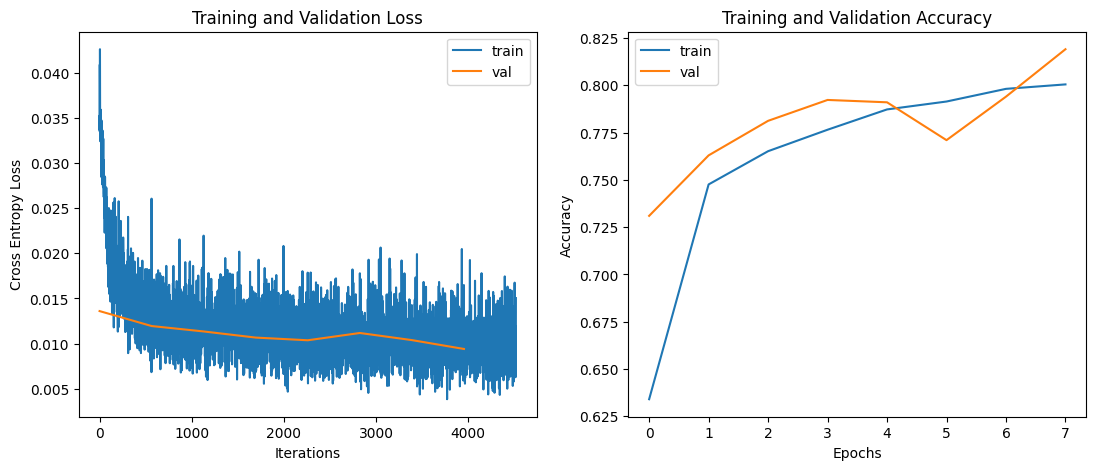

In [ ]:
plot_estop_eval(state_dict['epoch'], train_loader,
                state_dict['train_loss'],state_dict['val_loss'],state_dict['train_accuracy'], state_dict['val_accuracy'])

In the graph we observe that the model selected by the tuning process results in higher validation accuracy than train accuracy at the beginning and then drops noticeably before shooting above train accuracy again. This is not a good model fit. While thi

In [ ]:
print(f"Number of layers suggested upon Bayesian finetuning: {study_2.best_params['num_layers']}")
print(f"Number of hidden units suggested upon Bayesian finetuning: {study_2.best_params['num_hidden_units']}")
print(f"\nBest validation epoch loss obtained in MLP tuned for number of layers and hidden units: {state_dict['e_loss']:.4f}")

Number of layers suggested upon Bayesian finetuning: 3
Number of hidden units suggested upon Bayesian finetuning: 32

Best validation epoch loss obtained in MLP tuned for number of layers and hidden units: 0.0094


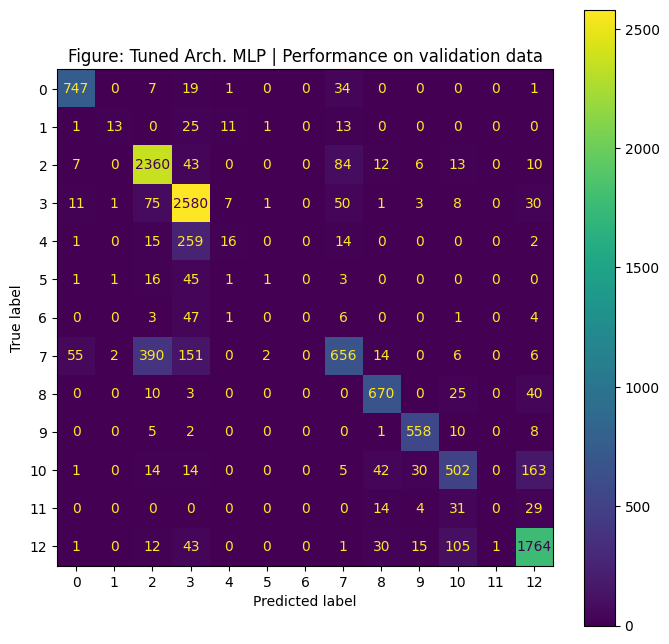

Loss: 0.5997, Accuracy: 81.90%


(0.5996769433976179, 81.90420851664315)

In [ ]:
#@title **Val Performance**
test_model(model_2, val_loader, loss_func, 'Figure: Tuned Arch. MLP | Performance on validation data')

#### 3.2.3. Applying regularization - Dropout & BatchNorm

In [ ]:
#@title **Modified MLP 2**
# Rewrite the class to dynamically input hidden size and layers
class Mod2MLP(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_units, dropout_rate):
        super(Mod2MLP, self).__init__()

        # Input layer
        layers = [nn.Linear(input_size, hidden_units)]
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Dropout(p=dropout_rate))

        # Hidden layers with ReLU activation, dropout, and batch normalization
        for _ in range(num_layers - 2):  # -2 because we already added one layer above and no ReLU after the last layer
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=dropout_rate))
            layers.append(nn.BatchNorm1d(hidden_units))
        # output layer
        layers.append(nn.Linear(hidden_units, output_size))

        # Combine all layers into the model
        self.mlp = nn.Sequential(*layers)
        self.double()

    def forward(self, x):
        return self.mlp(x)

In [ ]:
def objective2(trial):
    params = {
        'input_size':num_features_mlp,
        'output_size': num_classes,
        'num_layers': trial.suggest_categorical('num_layers', [1,2,3,4]),
        'hidden_units': trial.suggest_categorical('hidden_units', [32,64,128,256]),
        'dropout_rate':trial.suggest_float('dropout_rate',0.2,0.6),
        }
    trial_number = trial.number
    # define the model with the given parameters, make predictions
    model = Mod2MLP(**params)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    save_path = root + f'trial_{trial_number}' + 'best_Mod2MLP.pth'
    train_loss,train_accuracy, val_loss, val_accuracy,e=mod_train_and_validate(model,optimizer, loss_func,
                                                                             train_loader, val_loader,save_path=save_path,
                                                                             epochs=60)
    return val_loss[-1]

In [ ]:
%%time
sampler = TPESampler(seed=123)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study3 = optuna.create_study(direction='minimize', sampler=sampler)
study3.optimize(objective2, n_trials=20)

[I 2024-01-06 16:12:05,101] A new study created in memory with name: no-name-972d5d88-b39b-4a34-a156-827d21934483


Epoch 1/60, Epoch validation loss: 0.0166, Train acc: 0.5425, Validation acc: 0.6409
Epoch 2/60, Epoch validation loss: 0.0145, Train acc: 0.6158, Validation acc: 0.7119
Epoch 3/60, Epoch validation loss: 0.0138, Train acc: 0.6296, Validation acc: 0.7143
Epoch 4/60, Epoch validation loss: 0.0146, Train acc: 0.6428, Validation acc: 0.7054
Epoch 5/60, Epoch validation loss: 0.0133, Train acc: 0.6381, Validation acc: 0.7278
Epoch 6/60, Epoch validation loss: 0.0130, Train acc: 0.6517, Validation acc: 0.7496
Epoch 7/60, Epoch validation loss: 0.0126, Train acc: 0.6562, Validation acc: 0.7397
Epoch 8/60, Epoch validation loss: 0.0123, Train acc: 0.6604, Validation acc: 0.7546
Epoch 9/60, Epoch validation loss: 0.0128, Train acc: 0.6681, Validation acc: 0.7294
Epoch 10/60, Epoch validation loss: 0.0122, Train acc: 0.6713, Validation acc: 0.7555
Epoch 11/60, Epoch validation loss: 0.0124, Train acc: 0.6710, Validation acc: 0.7726
Epoch 12/60, Epoch validation loss: 0.0117, Train acc: 0.6739, 

[I 2024-01-06 16:12:45,983] Trial 0 finished with value: 0.011666861150916641 and parameters: {'num_layers': 1, 'hidden_units': 128, 'dropout_rate': 0.3923727605937444}. Best is trial 0 with value: 0.011666861150916641.


Epoch 14/60, Epoch validation loss: 0.0117, Train acc: 0.6817, Validation acc: 0.7775
Training finished.
Epoch 1/60, Epoch validation loss: 0.0165, Train acc: 0.5089, Validation acc: 0.6629
Epoch 2/60, Epoch validation loss: 0.0177, Train acc: 0.6387, Validation acc: 0.6318
Epoch 3/60, Epoch validation loss: 0.0138, Train acc: 0.6637, Validation acc: 0.7191
Epoch 4/60, Epoch validation loss: 0.0148, Train acc: 0.6752, Validation acc: 0.6937
Epoch 5/60, Epoch validation loss: 0.0136, Train acc: 0.6878, Validation acc: 0.7145
Epoch 6/60, Epoch validation loss: 0.0123, Train acc: 0.6935, Validation acc: 0.7456
Epoch 7/60, Epoch validation loss: 0.0126, Train acc: 0.7034, Validation acc: 0.7565
Epoch 8/60, Epoch validation loss: 0.0125, Train acc: 0.7003, Validation acc: 0.7573


[I 2024-01-06 16:13:13,176] Trial 1 finished with value: 0.014629416431355319 and parameters: {'num_layers': 3, 'hidden_units': 128, 'dropout_rate': 0.270180702458997}. Best is trial 0 with value: 0.011666861150916641.


Epoch 9/60, Epoch validation loss: 0.0146, Train acc: 0.7094, Validation acc: 0.6860
Training finished.
Epoch 1/60, Epoch validation loss: 0.0216, Train acc: 0.3194, Validation acc: 0.5292
Epoch 2/60, Epoch validation loss: 0.0191, Train acc: 0.4992, Validation acc: 0.6117
Epoch 3/60, Epoch validation loss: 0.0203, Train acc: 0.5104, Validation acc: 0.5723
Epoch 4/60, Epoch validation loss: 0.0189, Train acc: 0.5104, Validation acc: 0.6132
Epoch 5/60, Epoch validation loss: 0.0207, Train acc: 0.4977, Validation acc: 0.5747
Epoch 6/60, Epoch validation loss: 0.0194, Train acc: 0.5152, Validation acc: 0.6163
Epoch 7/60, Epoch validation loss: 0.0198, Train acc: 0.5156, Validation acc: 0.5867
Epoch 8/60, Epoch validation loss: 0.0186, Train acc: 0.5203, Validation acc: 0.6199
Epoch 9/60, Epoch validation loss: 0.0186, Train acc: 0.5212, Validation acc: 0.6070


[I 2024-01-06 16:13:43,789] Trial 2 finished with value: 0.019670853331511355 and parameters: {'num_layers': 4, 'hidden_units': 32, 'dropout_rate': 0.34471546224892563}. Best is trial 0 with value: 0.011666861150916641.


Epoch 10/60, Epoch validation loss: 0.0197, Train acc: 0.5237, Validation acc: 0.5859
Training finished.
Epoch 1/60, Epoch validation loss: 0.0164, Train acc: 0.4712, Validation acc: 0.6481
Epoch 2/60, Epoch validation loss: 0.0157, Train acc: 0.5976, Validation acc: 0.6341
Epoch 3/60, Epoch validation loss: 0.0152, Train acc: 0.6219, Validation acc: 0.6720
Epoch 4/60, Epoch validation loss: 0.0171, Train acc: 0.6133, Validation acc: 0.6081
Epoch 5/60, Epoch validation loss: 0.0166, Train acc: 0.6277, Validation acc: 0.6562
Epoch 6/60, Epoch validation loss: 0.0149, Train acc: 0.6356, Validation acc: 0.6844
Epoch 7/60, Epoch validation loss: 0.0173, Train acc: 0.6064, Validation acc: 0.6472
Epoch 8/60, Epoch validation loss: 0.0170, Train acc: 0.6233, Validation acc: 0.6395


[I 2024-01-06 16:14:11,587] Trial 3 finished with value: 0.016549055490202087 and parameters: {'num_layers': 3, 'hidden_units': 128, 'dropout_rate': 0.3249044891889861}. Best is trial 0 with value: 0.011666861150916641.


Epoch 9/60, Epoch validation loss: 0.0165, Train acc: 0.6291, Validation acc: 0.6380
Training finished.
Epoch 1/60, Epoch validation loss: 0.0307, Train acc: 0.2418, Validation acc: 0.2719
Epoch 2/60, Epoch validation loss: 0.0286, Train acc: 0.2816, Validation acc: 0.3935
Epoch 3/60, Epoch validation loss: 0.0287, Train acc: 0.3199, Validation acc: 0.3564
Epoch 4/60, Epoch validation loss: 0.0280, Train acc: 0.3308, Validation acc: 0.3889
Epoch 5/60, Epoch validation loss: 0.0284, Train acc: 0.3346, Validation acc: 0.3991
Epoch 6/60, Epoch validation loss: 0.0297, Train acc: 0.3122, Validation acc: 0.4061
Epoch 7/60, Epoch validation loss: 0.0287, Train acc: 0.2897, Validation acc: 0.4115


[I 2024-01-06 16:14:33,518] Trial 4 finished with value: 0.032666176855138084 and parameters: {'num_layers': 3, 'hidden_units': 32, 'dropout_rate': 0.5465236631533463}. Best is trial 0 with value: 0.011666861150916641.


Epoch 8/60, Epoch validation loss: 0.0327, Train acc: 0.2417, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0181, Train acc: 0.4547, Validation acc: 0.5880
Epoch 2/60, Epoch validation loss: 0.0166, Train acc: 0.5832, Validation acc: 0.6368
Epoch 3/60, Epoch validation loss: 0.0169, Train acc: 0.5980, Validation acc: 0.6402
Epoch 4/60, Epoch validation loss: 0.0165, Train acc: 0.6075, Validation acc: 0.6330
Epoch 5/60, Epoch validation loss: 0.0164, Train acc: 0.6096, Validation acc: 0.6710
Epoch 6/60, Epoch validation loss: 0.0167, Train acc: 0.6211, Validation acc: 0.6351
Epoch 7/60, Epoch validation loss: 0.0164, Train acc: 0.6249, Validation acc: 0.6607
Epoch 8/60, Epoch validation loss: 0.0151, Train acc: 0.6310, Validation acc: 0.7109
Epoch 9/60, Epoch validation loss: 0.0166, Train acc: 0.6415, Validation acc: 0.6341


[I 2024-01-06 16:15:04,638] Trial 5 finished with value: 0.017090861780239445 and parameters: {'num_layers': 3, 'hidden_units': 128, 'dropout_rate': 0.418027202586586}. Best is trial 0 with value: 0.011666861150916641.


Epoch 10/60, Epoch validation loss: 0.0171, Train acc: 0.6339, Validation acc: 0.6287
Training finished.
Epoch 1/60, Epoch validation loss: 0.0281, Train acc: 0.2465, Validation acc: 0.4101
Epoch 2/60, Epoch validation loss: 0.0232, Train acc: 0.4129, Validation acc: 0.5433
Epoch 3/60, Epoch validation loss: 0.0234, Train acc: 0.4666, Validation acc: 0.5245
Epoch 4/60, Epoch validation loss: 0.0224, Train acc: 0.4504, Validation acc: 0.5518
Epoch 5/60, Epoch validation loss: 0.0220, Train acc: 0.4509, Validation acc: 0.5674
Epoch 6/60, Epoch validation loss: 0.0221, Train acc: 0.4629, Validation acc: 0.5469
Epoch 7/60, Epoch validation loss: 0.0221, Train acc: 0.4551, Validation acc: 0.5547
Epoch 8/60, Epoch validation loss: 0.0226, Train acc: 0.4638, Validation acc: 0.5411


[I 2024-01-06 16:15:31,846] Trial 6 finished with value: 0.022874286260309764 and parameters: {'num_layers': 4, 'hidden_units': 32, 'dropout_rate': 0.44996140083823993}. Best is trial 0 with value: 0.011666861150916641.


Epoch 9/60, Epoch validation loss: 0.0229, Train acc: 0.4663, Validation acc: 0.5435
Training finished.
Epoch 1/60, Epoch validation loss: 0.0180, Train acc: 0.4622, Validation acc: 0.6017
Epoch 2/60, Epoch validation loss: 0.0171, Train acc: 0.5376, Validation acc: 0.6533
Epoch 3/60, Epoch validation loss: 0.0165, Train acc: 0.5493, Validation acc: 0.6372
Epoch 4/60, Epoch validation loss: 0.0151, Train acc: 0.5630, Validation acc: 0.6849
Epoch 5/60, Epoch validation loss: 0.0157, Train acc: 0.5713, Validation acc: 0.6634
Epoch 6/60, Epoch validation loss: 0.0155, Train acc: 0.5742, Validation acc: 0.6755
Epoch 7/60, Epoch validation loss: 0.0140, Train acc: 0.5854, Validation acc: 0.7295
Epoch 8/60, Epoch validation loss: 0.0150, Train acc: 0.5845, Validation acc: 0.7025
Epoch 9/60, Epoch validation loss: 0.0138, Train acc: 0.5873, Validation acc: 0.7272
Epoch 10/60, Epoch validation loss: 0.0144, Train acc: 0.5868, Validation acc: 0.7083
Epoch 11/60, Epoch validation loss: 0.0138, T

[I 2024-01-06 16:16:06,737] Trial 7 finished with value: 0.01407463784015995 and parameters: {'num_layers': 2, 'hidden_units': 128, 'dropout_rate': 0.5541307305100558}. Best is trial 0 with value: 0.011666861150916641.


Epoch 12/60, Epoch validation loss: 0.0141, Train acc: 0.5898, Validation acc: 0.6957
Training finished.
Epoch 1/60, Epoch validation loss: 0.0163, Train acc: 0.5682, Validation acc: 0.6612
Epoch 2/60, Epoch validation loss: 0.0147, Train acc: 0.6495, Validation acc: 0.7014
Epoch 3/60, Epoch validation loss: 0.0138, Train acc: 0.6639, Validation acc: 0.7338
Epoch 4/60, Epoch validation loss: 0.0124, Train acc: 0.6812, Validation acc: 0.7540
Epoch 5/60, Epoch validation loss: 0.0122, Train acc: 0.6878, Validation acc: 0.7521
Epoch 6/60, Epoch validation loss: 0.0127, Train acc: 0.6918, Validation acc: 0.7533
Epoch 7/60, Epoch validation loss: 0.0115, Train acc: 0.7003, Validation acc: 0.7729
Epoch 8/60, Epoch validation loss: 0.0121, Train acc: 0.7041, Validation acc: 0.7565
Epoch 9/60, Epoch validation loss: 0.0119, Train acc: 0.7084, Validation acc: 0.7497
Epoch 10/60, Epoch validation loss: 0.0118, Train acc: 0.7117, Validation acc: 0.7716
Epoch 11/60, Epoch validation loss: 0.0108, 

[I 2024-01-06 16:16:42,294] Trial 8 finished with value: 0.011377235831738284 and parameters: {'num_layers': 2, 'hidden_units': 256, 'dropout_rate': 0.32750657055275056}. Best is trial 8 with value: 0.011377235831738284.


Epoch 12/60, Epoch validation loss: 0.0114, Train acc: 0.7194, Validation acc: 0.7691
Training finished.
Epoch 1/60, Epoch validation loss: 0.0209, Train acc: 0.3822, Validation acc: 0.5632
Epoch 2/60, Epoch validation loss: 0.0194, Train acc: 0.5012, Validation acc: 0.5883
Epoch 3/60, Epoch validation loss: 0.0188, Train acc: 0.5157, Validation acc: 0.5933
Epoch 4/60, Epoch validation loss: 0.0197, Train acc: 0.5261, Validation acc: 0.5880
Epoch 5/60, Epoch validation loss: 0.0196, Train acc: 0.5327, Validation acc: 0.5714
Epoch 6/60, Epoch validation loss: 0.0206, Train acc: 0.5352, Validation acc: 0.5586
Epoch 7/60, Epoch validation loss: 0.0199, Train acc: 0.5350, Validation acc: 0.5767


[I 2024-01-06 16:17:06,456] Trial 9 finished with value: 0.01977979018649137 and parameters: {'num_layers': 4, 'hidden_units': 32, 'dropout_rate': 0.35927427276719237}. Best is trial 8 with value: 0.011377235831738284.


Epoch 8/60, Epoch validation loss: 0.0198, Train acc: 0.5394, Validation acc: 0.5856
Training finished.
Epoch 1/60, Epoch validation loss: 0.0141, Train acc: 0.5966, Validation acc: 0.7155
Epoch 2/60, Epoch validation loss: 0.0138, Train acc: 0.6852, Validation acc: 0.7133
Epoch 3/60, Epoch validation loss: 0.0127, Train acc: 0.7095, Validation acc: 0.7480
Epoch 4/60, Epoch validation loss: 0.0113, Train acc: 0.7145, Validation acc: 0.7750
Epoch 5/60, Epoch validation loss: 0.0124, Train acc: 0.7283, Validation acc: 0.7467
Epoch 6/60, Epoch validation loss: 0.0119, Train acc: 0.7174, Validation acc: 0.7600
Epoch 7/60, Epoch validation loss: 0.0112, Train acc: 0.7302, Validation acc: 0.7817
Epoch 8/60, Epoch validation loss: 0.0118, Train acc: 0.7285, Validation acc: 0.7667
Epoch 9/60, Epoch validation loss: 0.0113, Train acc: 0.7421, Validation acc: 0.7797
Epoch 10/60, Epoch validation loss: 0.0110, Train acc: 0.7461, Validation acc: 0.7838
Epoch 11/60, Epoch validation loss: 0.0108, T

[I 2024-01-06 16:17:47,831] Trial 10 finished with value: 0.010983638317056508 and parameters: {'num_layers': 2, 'hidden_units': 256, 'dropout_rate': 0.23063314415076586}. Best is trial 10 with value: 0.010983638317056508.


Epoch 14/60, Epoch validation loss: 0.0110, Train acc: 0.7544, Validation acc: 0.7851
Training finished.
Epoch 1/60, Epoch validation loss: 0.0143, Train acc: 0.6016, Validation acc: 0.7047
Epoch 2/60, Epoch validation loss: 0.0128, Train acc: 0.6930, Validation acc: 0.7439
Epoch 3/60, Epoch validation loss: 0.0123, Train acc: 0.7099, Validation acc: 0.7554
Epoch 4/60, Epoch validation loss: 0.0128, Train acc: 0.7197, Validation acc: 0.7463
Epoch 5/60, Epoch validation loss: 0.0128, Train acc: 0.7296, Validation acc: 0.7440
Epoch 6/60, Epoch validation loss: 0.0112, Train acc: 0.7315, Validation acc: 0.7813
Epoch 7/60, Epoch validation loss: 0.0111, Train acc: 0.7310, Validation acc: 0.7868
Epoch 8/60, Epoch validation loss: 0.0110, Train acc: 0.7436, Validation acc: 0.7907
Epoch 9/60, Epoch validation loss: 0.0106, Train acc: 0.7495, Validation acc: 0.7940
Epoch 10/60, Epoch validation loss: 0.0120, Train acc: 0.7510, Validation acc: 0.7696
Epoch 11/60, Epoch validation loss: 0.0107, 

[I 2024-01-06 16:18:22,503] Trial 11 finished with value: 0.011532367042116467 and parameters: {'num_layers': 2, 'hidden_units': 256, 'dropout_rate': 0.20258134968793165}. Best is trial 10 with value: 0.010983638317056508.


Epoch 12/60, Epoch validation loss: 0.0115, Train acc: 0.7545, Validation acc: 0.7731
Training finished.
Epoch 1/60, Epoch validation loss: 0.0153, Train acc: 0.6121, Validation acc: 0.6825
Epoch 2/60, Epoch validation loss: 0.0125, Train acc: 0.6962, Validation acc: 0.7504
Epoch 3/60, Epoch validation loss: 0.0122, Train acc: 0.7050, Validation acc: 0.7562
Epoch 4/60, Epoch validation loss: 0.0116, Train acc: 0.7201, Validation acc: 0.7730
Epoch 5/60, Epoch validation loss: 0.0116, Train acc: 0.7230, Validation acc: 0.7648
Epoch 6/60, Epoch validation loss: 0.0118, Train acc: 0.7292, Validation acc: 0.7682
Epoch 7/60, Epoch validation loss: 0.0116, Train acc: 0.7221, Validation acc: 0.7731
Epoch 8/60, Epoch validation loss: 0.0115, Train acc: 0.7301, Validation acc: 0.7696
Epoch 9/60, Epoch validation loss: 0.0111, Train acc: 0.7335, Validation acc: 0.7782
Epoch 10/60, Epoch validation loss: 0.0118, Train acc: 0.7372, Validation acc: 0.7697
Epoch 11/60, Epoch validation loss: 0.0106, 

[I 2024-01-06 16:19:13,386] Trial 12 finished with value: 0.01034591122250444 and parameters: {'num_layers': 2, 'hidden_units': 256, 'dropout_rate': 0.20656690843906103}. Best is trial 12 with value: 0.01034591122250444.


Epoch 17/60, Epoch validation loss: 0.0103, Train acc: 0.7633, Validation acc: 0.8036
Training finished.
Epoch 1/60, Epoch validation loss: 0.0143, Train acc: 0.5744, Validation acc: 0.7159
Epoch 2/60, Epoch validation loss: 0.0134, Train acc: 0.6827, Validation acc: 0.7410
Epoch 3/60, Epoch validation loss: 0.0129, Train acc: 0.7032, Validation acc: 0.7374
Epoch 4/60, Epoch validation loss: 0.0123, Train acc: 0.7100, Validation acc: 0.7547
Epoch 5/60, Epoch validation loss: 0.0117, Train acc: 0.7168, Validation acc: 0.7668
Epoch 6/60, Epoch validation loss: 0.0116, Train acc: 0.7257, Validation acc: 0.7627
Epoch 7/60, Epoch validation loss: 0.0114, Train acc: 0.7283, Validation acc: 0.7673
Epoch 8/60, Epoch validation loss: 0.0117, Train acc: 0.7318, Validation acc: 0.7623
Epoch 9/60, Epoch validation loss: 0.0114, Train acc: 0.7337, Validation acc: 0.7821
Epoch 10/60, Epoch validation loss: 0.0117, Train acc: 0.7376, Validation acc: 0.7726
Epoch 11/60, Epoch validation loss: 0.0109, 

[I 2024-01-06 16:19:48,653] Trial 13 finished with value: 0.011843853986165167 and parameters: {'num_layers': 2, 'hidden_units': 64, 'dropout_rate': 0.20462487935954174}. Best is trial 12 with value: 0.01034591122250444.


Epoch 13/60, Epoch validation loss: 0.0118, Train acc: 0.7434, Validation acc: 0.7679
Training finished.
Epoch 1/60, Epoch validation loss: 0.0141, Train acc: 0.5911, Validation acc: 0.7235
Epoch 2/60, Epoch validation loss: 0.0135, Train acc: 0.6755, Validation acc: 0.7190
Epoch 3/60, Epoch validation loss: 0.0124, Train acc: 0.6980, Validation acc: 0.7693
Epoch 4/60, Epoch validation loss: 0.0119, Train acc: 0.7122, Validation acc: 0.7560
Epoch 5/60, Epoch validation loss: 0.0115, Train acc: 0.7211, Validation acc: 0.7746
Epoch 6/60, Epoch validation loss: 0.0119, Train acc: 0.7273, Validation acc: 0.7601
Epoch 7/60, Epoch validation loss: 0.0114, Train acc: 0.7298, Validation acc: 0.7725
Epoch 8/60, Epoch validation loss: 0.0111, Train acc: 0.7339, Validation acc: 0.7765
Epoch 9/60, Epoch validation loss: 0.0109, Train acc: 0.7347, Validation acc: 0.7941
Epoch 10/60, Epoch validation loss: 0.0107, Train acc: 0.7353, Validation acc: 0.7983
Epoch 11/60, Epoch validation loss: 0.0105, 

[I 2024-01-06 16:20:33,715] Trial 14 finished with value: 0.011024922924789031 and parameters: {'num_layers': 2, 'hidden_units': 256, 'dropout_rate': 0.24100225708187298}. Best is trial 12 with value: 0.01034591122250444.


Epoch 15/60, Epoch validation loss: 0.0110, Train acc: 0.7447, Validation acc: 0.7820
Training finished.
Epoch 1/60, Epoch validation loss: 0.0167, Train acc: 0.5541, Validation acc: 0.6870
Epoch 2/60, Epoch validation loss: 0.0133, Train acc: 0.6574, Validation acc: 0.7374
Epoch 3/60, Epoch validation loss: 0.0129, Train acc: 0.6765, Validation acc: 0.7384
Epoch 4/60, Epoch validation loss: 0.0134, Train acc: 0.6721, Validation acc: 0.7278
Epoch 5/60, Epoch validation loss: 0.0126, Train acc: 0.6894, Validation acc: 0.7483
Epoch 6/60, Epoch validation loss: 0.0122, Train acc: 0.6938, Validation acc: 0.7633
Epoch 7/60, Epoch validation loss: 0.0120, Train acc: 0.7019, Validation acc: 0.7631
Epoch 8/60, Epoch validation loss: 0.0117, Train acc: 0.7039, Validation acc: 0.7740
Epoch 9/60, Epoch validation loss: 0.0117, Train acc: 0.7114, Validation acc: 0.7731
Epoch 11/60, Epoch validation loss: 0.0113, Train acc: 0.7169, Validation acc: 0.7734
Epoch 12/60, Epoch validation loss: 0.0113, 

[I 2024-01-06 16:21:17,758] Trial 15 finished with value: 0.010882212103584858 and parameters: {'num_layers': 1, 'hidden_units': 256, 'dropout_rate': 0.2841779658337691}. Best is trial 12 with value: 0.01034591122250444.


Epoch 15/60, Epoch validation loss: 0.0109, Train acc: 0.7226, Validation acc: 0.8005
Training finished.
Epoch 1/60, Epoch validation loss: 0.0161, Train acc: 0.5900, Validation acc: 0.6641
Epoch 2/60, Epoch validation loss: 0.0137, Train acc: 0.6640, Validation acc: 0.7233
Epoch 3/60, Epoch validation loss: 0.0129, Train acc: 0.6863, Validation acc: 0.7550
Epoch 4/60, Epoch validation loss: 0.0124, Train acc: 0.6908, Validation acc: 0.7423
Epoch 5/60, Epoch validation loss: 0.0122, Train acc: 0.6962, Validation acc: 0.7626
Epoch 6/60, Epoch validation loss: 0.0116, Train acc: 0.7127, Validation acc: 0.7707
Epoch 7/60, Epoch validation loss: 0.0112, Train acc: 0.7206, Validation acc: 0.7794
Epoch 8/60, Epoch validation loss: 0.0122, Train acc: 0.7243, Validation acc: 0.7610
Epoch 9/60, Epoch validation loss: 0.0120, Train acc: 0.7216, Validation acc: 0.7717
Epoch 10/60, Epoch validation loss: 0.0119, Train acc: 0.7273, Validation acc: 0.7536
Epoch 11/60, Epoch validation loss: 0.0107, 

[I 2024-01-06 16:21:56,099] Trial 16 finished with value: 0.011482274148672682 and parameters: {'num_layers': 1, 'hidden_units': 256, 'dropout_rate': 0.2837696856971173}. Best is trial 12 with value: 0.01034591122250444.


Epoch 13/60, Epoch validation loss: 0.0115, Train acc: 0.7426, Validation acc: 0.7721
Training finished.
Epoch 1/60, Epoch validation loss: 0.0150, Train acc: 0.5591, Validation acc: 0.6932
Epoch 2/60, Epoch validation loss: 0.0143, Train acc: 0.6465, Validation acc: 0.7045
Epoch 3/60, Epoch validation loss: 0.0135, Train acc: 0.6645, Validation acc: 0.7341
Epoch 4/60, Epoch validation loss: 0.0125, Train acc: 0.6777, Validation acc: 0.7520
Epoch 5/60, Epoch validation loss: 0.0130, Train acc: 0.6844, Validation acc: 0.7389
Epoch 6/60, Epoch validation loss: 0.0126, Train acc: 0.6916, Validation acc: 0.7551
Epoch 7/60, Epoch validation loss: 0.0119, Train acc: 0.6935, Validation acc: 0.7807
Epoch 8/60, Epoch validation loss: 0.0127, Train acc: 0.7040, Validation acc: 0.7514
Epoch 9/60, Epoch validation loss: 0.0114, Train acc: 0.7049, Validation acc: 0.7852
Epoch 10/60, Epoch validation loss: 0.0115, Train acc: 0.7004, Validation acc: 0.7833


[I 2024-01-06 16:22:26,170] Trial 17 finished with value: 0.011488668614016498 and parameters: {'num_layers': 1, 'hidden_units': 64, 'dropout_rate': 0.28668789544468887}. Best is trial 12 with value: 0.01034591122250444.


Epoch 11/60, Epoch validation loss: 0.0115, Train acc: 0.7109, Validation acc: 0.7749
Training finished.
Epoch 1/60, Epoch validation loss: 0.0160, Train acc: 0.5789, Validation acc: 0.6705
Epoch 2/60, Epoch validation loss: 0.0134, Train acc: 0.6654, Validation acc: 0.7317
Epoch 3/60, Epoch validation loss: 0.0130, Train acc: 0.6771, Validation acc: 0.7478
Epoch 4/60, Epoch validation loss: 0.0127, Train acc: 0.6908, Validation acc: 0.7509
Epoch 5/60, Epoch validation loss: 0.0125, Train acc: 0.6990, Validation acc: 0.7467
Epoch 6/60, Epoch validation loss: 0.0120, Train acc: 0.7047, Validation acc: 0.7609
Epoch 7/60, Epoch validation loss: 0.0136, Train acc: 0.7045, Validation acc: 0.7240
Epoch 8/60, Epoch validation loss: 0.0118, Train acc: 0.7145, Validation acc: 0.7690
Epoch 9/60, Epoch validation loss: 0.0120, Train acc: 0.7168, Validation acc: 0.7596
Epoch 10/60, Epoch validation loss: 0.0114, Train acc: 0.7187, Validation acc: 0.7882
Epoch 11/60, Epoch validation loss: 0.0115, 

[I 2024-01-06 16:23:10,958] Trial 18 finished with value: 0.01105193096423576 and parameters: {'num_layers': 1, 'hidden_units': 256, 'dropout_rate': 0.26198093800083455}. Best is trial 12 with value: 0.01034591122250444.


Epoch 15/60, Epoch validation loss: 0.0111, Train acc: 0.7348, Validation acc: 0.7892
Training finished.
Epoch 1/60, Epoch validation loss: 0.0169, Train acc: 0.4878, Validation acc: 0.6624
Epoch 2/60, Epoch validation loss: 0.0163, Train acc: 0.5669, Validation acc: 0.6711
Epoch 3/60, Epoch validation loss: 0.0157, Train acc: 0.5656, Validation acc: 0.6708
Epoch 4/60, Epoch validation loss: 0.0145, Train acc: 0.5726, Validation acc: 0.6994
Epoch 5/60, Epoch validation loss: 0.0148, Train acc: 0.5847, Validation acc: 0.7050
Epoch 6/60, Epoch validation loss: 0.0149, Train acc: 0.5915, Validation acc: 0.6869
Epoch 7/60, Epoch validation loss: 0.0137, Train acc: 0.6009, Validation acc: 0.7281
Epoch 8/60, Epoch validation loss: 0.0153, Train acc: 0.6013, Validation acc: 0.7114
Epoch 9/60, Epoch validation loss: 0.0146, Train acc: 0.5993, Validation acc: 0.6734


[I 2024-01-06 16:23:40,116] Trial 19 finished with value: 0.014428745859132201 and parameters: {'num_layers': 1, 'hidden_units': 256, 'dropout_rate': 0.49218218340935344}. Best is trial 12 with value: 0.01034591122250444.


Epoch 10/60, Epoch validation loss: 0.0144, Train acc: 0.6095, Validation acc: 0.7130
Training finished.
CPU times: user 11min 16s, sys: 8.7 s, total: 11min 25s
Wall time: 11min 35s


In [ ]:
study3.best_trial, study3.best_params

(FrozenTrial(number=12, state=TrialState.COMPLETE, values=[0.01034591122250444], datetime_start=datetime.datetime(2024, 1, 6, 16, 18, 22, 504841), datetime_complete=datetime.datetime(2024, 1, 6, 16, 19, 13, 385860), params={'num_layers': 2, 'hidden_units': 256, 'dropout_rate': 0.20656690843906103}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': CategoricalDistribution(choices=(1, 2, 3, 4)), 'hidden_units': CategoricalDistribution(choices=(32, 64, 128, 256)), 'dropout_rate': FloatDistribution(high=0.6, log=False, low=0.2, step=None)}, trial_id=12, value=None),
 {'num_layers': 2, 'hidden_units': 256, 'dropout_rate': 0.20656690843906103})

In [ ]:
# # for loading the study later
save_study_ = root + 'optuna_study_best_Mod2MLP.pkl'
# joblib.dump(study2, save_study_)
study_3 = joblib.load(save_study_)
study_3.best_params

{'num_layers': 2, 'hidden_units': 256, 'dropout_rate': 0.20656690843906103}

In [ ]:
# reconstruct path of the best trial
# best trial - 12
path = root + 'trial_' + f'{study_3.best_trial.number}' + 'best_Mod2MLP.pth'
num_layers = study_3.best_params['num_layers']
hidden_units = study_3.best_params['hidden_units']
dropout_rate = study_3.best_params['dropout_rate']

model_3 = Mod2MLP(num_features, num_classes, num_layers, hidden_units, dropout_rate)
state_dict = torch.load(path)
model_3.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

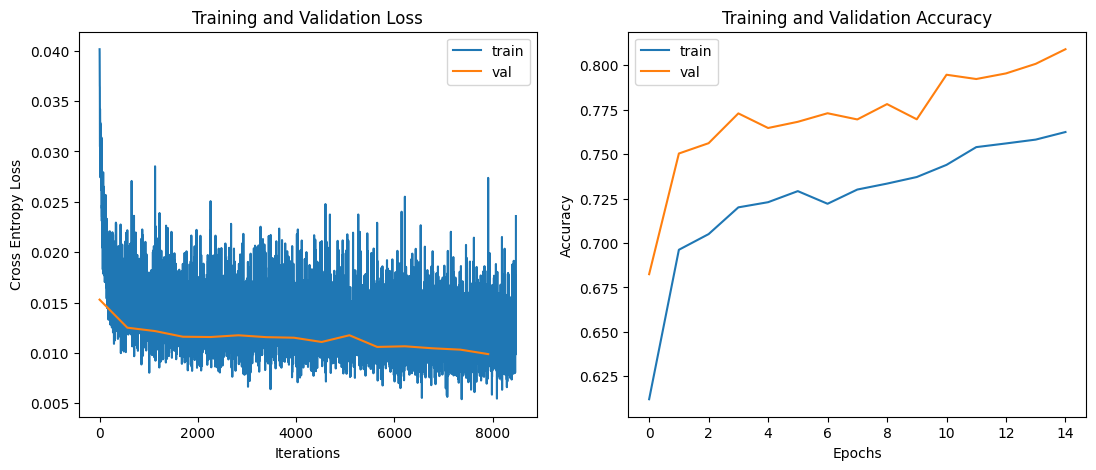

In [ ]:
plot_estop_eval(state_dict['epoch'], train_loader,
                state_dict['train_loss'],state_dict['val_loss'],state_dict['train_accuracy'], state_dict['val_accuracy'])

We can observe in above figure that validation loss curve is lower than the train loss curve. And the Validation accuracy curve is consistently higher than the train accuracy curve. Since both are improving, it shows that the model is learning but the difference in the curves is introduced because of the normaisation techniques of batch normalisation, dropout and early stopping that introduce bias. The curves suggest that the model will perform better on datasets different from training sets.

In [ ]:
print(f"Number of layers suggested upon Bayesian finetuning: {study_3.best_params['num_layers']}")
print(f"Number of hidden units suggested upon Bayesian finetuning: {study_3.best_params['hidden_units']}")
print(f"Dropout rate suggested upon Bayesian finetuning: {study_3.best_params['dropout_rate']:.4f}")
print(f"\nBest validation epoch loss obtained in MLP tuned for number of layers and hidden units: {state_dict['e_loss']:.4f}")

Number of layers suggested upon Bayesian finetuning: 2
Number of hidden units suggested upon Bayesian finetuning: 256
Dropout rate suggested upon Bayesian finetuning: 0.2066

Best validation epoch loss obtained in MLP tuned for number of layers and hidden units: 0.0099


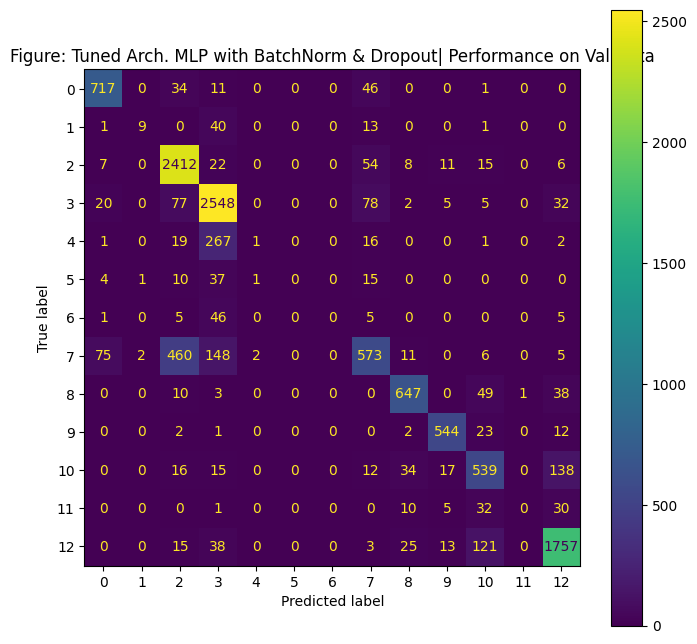

Loss: 0.6303, Accuracy: 80.91%


(0.6303206959942689, 80.90810990288038)

In [ ]:
#@title **Val Performance**
# test on validation data
test_model(model_3, val_loader,loss_func, 'Figure: Tuned Arch. MLP with BatchNorm & Dropout| Performance on Val Data')

The confusion matrix above shows that the model performs well on most of the majority classes, however, again the minority classes, and pecuiliarly class 7 (which has a considerably high distribution in the sample) suffer.

#### 3.2.4. Tuning the training loop

Since the validation loss obtained by our Basic MLP is the lowest, 0.0079, compared to the other two tuned models (0.0094, 0.0099), I fix this model architecture (number of hidden layers =1, number of hidden units =256) without applying batch normalisation or dropout. We can now proceed with finetuning the training loop.

I finetune the following hyperparameters of the training loop:
* **Optimiser**: Optimisers define how the model parameters get updated in the backward pass of the network. It is important to tune them as they impact speed of convergence and influence whether local minima can be escaped.
* **Learning rate**: Learning rate is the size of steps taken during the step where weights get updated. This needs to be tuned because a high learning rate may result in the model overshooting the minima and a low rate will result in slow convergence.
* **Patience**: Patience influences early stopping. It tells the model - on the number of steps to wait before stopping in order for the validation loss to improve. Tuning this will allow the model to refrain from overfitting and also imrpove computational efficiency of model/tuning process.
* **Batch size**: Determines number of samples used/loaded in one iteration of training. Smaller batches can allow the model to update the weights more frequently but maybe computationally not so efficient.
* **Epochs**: It is the total number of times the entire training dataset is passed through the model. Too few can be bad - not sufficent learning. But high number may lead to overfitting, hence need to be tuned.



In [ ]:
#@title **Modified Train Loop**

# add
# params = {'optimizer': a, 'batch_size': b, 'epochs:'c, 'lr':d, 'patience':e}

def mod2_train_and_validate(model, loss_func, splits, save_path, params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss = []       # where we keep track of the training loss
    train_accuracy = []   # where we keep track of the training accuracy of the model
    val_loss = []         # where we keep track of the validation loss
    val_accuracy = []     # where we keep track of the validation accuracy of the model

    model.to(device)
    min_val_loss = np.Inf
    counter = 0
    delta_p = 0 #-- minimum change required in the monitored quantity (e.g. validation loss) to qualify as an improvement

    train_loader, val_loader, _ = generate_loaders(splits[0], splits[1], splits[2], batch_size=params['batch_size'])
    optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr= params['lr'])
    epochs =params['epochs']

    for e in range(epochs):
        epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_loader, device)
        epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, val_loader, device)

        train_loss.extend(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)
        print(f'Epoch {e + 1}/{epochs}, Epoch validation loss: {epoch_val_loss:.4f}, Train acc: {epoch_train_accuracy:.4f}, Validation acc: {epoch_val_accuracy:.4f}')
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'e_loss': epoch_val_loss,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss':val_loss,
                'val_accuracy':val_accuracy
            }, save_path)
        elif epoch_val_loss-min_val_loss > delta_p:
          counter = counter + 1
        if counter == params['patience']:
          break

    print('Training finished.')
    return train_loss, train_accuracy, val_loss, val_accuracy, e


In [ ]:
def objective3(trial):
    params = {
        'optimizer':trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
        'batch_size': trial.suggest_categorical("batch_size", [32,64,128,256]),
        'lr': trial.suggest_float("lr",0.001,0.1,log=True),
        'epochs': trial.suggest_int("epochs", 10,80, step = 10),
        'patience': trial.suggest_int("patience", 5,20)
        }
    trial_number = trial.number
    # define the model with the given parameters, make predictions
    #input_size = num_features = 520
    #output_size = classes =13
    model = BasicMLP(input_size, 256, output_size)

    save_path = root + f'trial_{trial_number}' + 'best_BasicMLP_tuneloop.pth'
    train_loss,train_accuracy, val_loss, val_accuracy,e=mod2_train_and_validate(model, loss_func,
                                                                             splits, save_path,
                                                                             params) #loss_func, splits are global variables defined earlier
    return val_loss[-1]

In [ ]:
%%time
sampler = TPESampler(seed=123)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study4 = optuna.create_study(direction='minimize', sampler=sampler)
study4.optimize(objective3, n_trials=60)

[I 2024-01-06 18:05:35,633] A new study created in memory with name: no-name-58ea1bdb-0ecb-4ad2-a3d7-a8cc9829809b


Epoch 1/60, Epoch validation loss: 0.0165, Train acc: 0.2218, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0164, Train acc: 0.2265, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0165, Train acc: 0.2231, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0165, Train acc: 0.2263, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0165, Train acc: 0.2281, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0165, Train acc: 0.2285, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0165, Train acc: 0.2254, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0165, Train acc: 0.2261, Validation acc: 0.2297
Epoch 9/60, Epoch validation loss: 0.0165, Train acc: 0.2242, Validation acc: 0.2297
Epoch 10/60, Epoch validation loss: 0.0165, Train acc: 0.2221, Validation acc: 0.2104
Epoch 11/60, Epoch validation loss: 0.0165, Train acc: 0.2227, Validation acc: 0.2297
Epoch 12/60, Epoch validation loss: 0.0165, Train acc: 0.2252, 

[I 2024-01-06 18:06:10,766] Trial 0 finished with value: 0.016488542839171866 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.09152261002780922, 'epochs': 60, 'patience': 12}. Best is trial 0 with value: 0.016488542839171866.


Epoch 14/60, Epoch validation loss: 0.0165, Train acc: 0.2240, Validation acc: 0.2297
Training finished.
Epoch 1/20, Epoch validation loss: 0.0655, Train acc: 0.2225, Validation acc: 0.2104
Epoch 2/20, Epoch validation loss: 0.0655, Train acc: 0.2242, Validation acc: 0.2297
Epoch 3/20, Epoch validation loss: 0.0654, Train acc: 0.2277, Validation acc: 0.2297
Epoch 4/20, Epoch validation loss: 0.0655, Train acc: 0.2248, Validation acc: 0.2104
Epoch 5/20, Epoch validation loss: 0.0654, Train acc: 0.2250, Validation acc: 0.2297
Epoch 6/20, Epoch validation loss: 0.0654, Train acc: 0.2257, Validation acc: 0.2104
Epoch 7/20, Epoch validation loss: 0.0654, Train acc: 0.2228, Validation acc: 0.2297
Epoch 8/20, Epoch validation loss: 0.0654, Train acc: 0.2251, Validation acc: 0.2297
Epoch 9/20, Epoch validation loss: 0.0654, Train acc: 0.2271, Validation acc: 0.2297


[I 2024-01-06 18:07:04,154] Trial 1 finished with value: 0.06545258567169553 and parameters: {'optimizer': 'Adam', 'batch_size': 32, 'lr': 0.029922013287804083, 'epochs': 20, 'patience': 7}. Best is trial 0 with value: 0.016488542839171866.


Epoch 10/20, Epoch validation loss: 0.0655, Train acc: 0.2256, Validation acc: 0.2297
Training finished.
Epoch 1/30, Epoch validation loss: 0.0305, Train acc: 0.2989, Validation acc: 0.4045
Epoch 2/30, Epoch validation loss: 0.0212, Train acc: 0.4980, Validation acc: 0.5635
Epoch 3/30, Epoch validation loss: 0.0180, Train acc: 0.6085, Validation acc: 0.6187
Epoch 4/30, Epoch validation loss: 0.0155, Train acc: 0.6615, Validation acc: 0.6868
Epoch 5/30, Epoch validation loss: 0.0143, Train acc: 0.6900, Validation acc: 0.7189
Epoch 6/30, Epoch validation loss: 0.0136, Train acc: 0.7144, Validation acc: 0.7329
Epoch 7/30, Epoch validation loss: 0.0132, Train acc: 0.7303, Validation acc: 0.7378
Epoch 8/30, Epoch validation loss: 0.0137, Train acc: 0.7415, Validation acc: 0.7277
Epoch 9/30, Epoch validation loss: 0.0127, Train acc: 0.7537, Validation acc: 0.7509
Epoch 10/30, Epoch validation loss: 0.0135, Train acc: 0.7627, Validation acc: 0.7233
Epoch 11/30, Epoch validation loss: 0.0116, 

[I 2024-01-06 18:08:11,507] Trial 2 finished with value: 0.009526513383245115 and parameters: {'optimizer': 'SGD', 'batch_size': 64, 'lr': 0.02785394829873094, 'epochs': 30, 'patience': 10}. Best is trial 2 with value: 0.009526513383245115.


Epoch 24/30, Epoch validation loss: 0.0095, Train acc: 0.8211, Validation acc: 0.8121
Training finished.
Epoch 1/40, Epoch validation loss: 0.0642, Train acc: 0.2648, Validation acc: 0.2303
Epoch 2/40, Epoch validation loss: 0.0532, Train acc: 0.4205, Validation acc: 0.4834
Epoch 3/40, Epoch validation loss: 0.0412, Train acc: 0.5250, Validation acc: 0.5630
Epoch 4/40, Epoch validation loss: 0.0351, Train acc: 0.6147, Validation acc: 0.6430
Epoch 5/40, Epoch validation loss: 0.0321, Train acc: 0.6632, Validation acc: 0.6866
Epoch 6/40, Epoch validation loss: 0.0302, Train acc: 0.6852, Validation acc: 0.7024
Epoch 7/40, Epoch validation loss: 0.0292, Train acc: 0.7032, Validation acc: 0.7130
Epoch 8/40, Epoch validation loss: 0.0351, Train acc: 0.7194, Validation acc: 0.6273
Epoch 9/40, Epoch validation loss: 0.0273, Train acc: 0.7316, Validation acc: 0.7205
Epoch 10/40, Epoch validation loss: 0.0280, Train acc: 0.7436, Validation acc: 0.7134
Epoch 11/40, Epoch validation loss: 0.0255, 

[I 2024-01-06 18:10:10,819] Trial 3 finished with value: 0.02128885232164113 and parameters: {'optimizer': 'SGD', 'batch_size': 32, 'lr': 0.00971337588624665, 'epochs': 40, 'patience': 9}. Best is trial 2 with value: 0.009526513383245115.


Epoch 32/40, Epoch validation loss: 0.0213, Train acc: 0.8281, Validation acc: 0.7925
Training finished.
Epoch 1/40, Epoch validation loss: 0.0651, Train acc: 0.2512, Validation acc: 0.2826
Epoch 2/40, Epoch validation loss: 0.0640, Train acc: 0.3187, Validation acc: 0.3136
Epoch 3/40, Epoch validation loss: 0.0608, Train acc: 0.3913, Validation acc: 0.4344
Epoch 4/40, Epoch validation loss: 0.0542, Train acc: 0.4606, Validation acc: 0.4819
Epoch 5/40, Epoch validation loss: 0.0480, Train acc: 0.4982, Validation acc: 0.5136
Epoch 6/40, Epoch validation loss: 0.0427, Train acc: 0.5362, Validation acc: 0.5529
Epoch 7/40, Epoch validation loss: 0.0389, Train acc: 0.5799, Validation acc: 0.6008
Epoch 8/40, Epoch validation loss: 0.0361, Train acc: 0.6176, Validation acc: 0.6354
Epoch 9/40, Epoch validation loss: 0.0344, Train acc: 0.6448, Validation acc: 0.6561
Epoch 10/40, Epoch validation loss: 0.0331, Train acc: 0.6631, Validation acc: 0.6687
Epoch 11/40, Epoch validation loss: 0.0325, 

[I 2024-01-06 18:12:39,392] Trial 4 finished with value: 0.021771168585697862 and parameters: {'optimizer': 'SGD', 'batch_size': 32, 'lr': 0.004310929927682153, 'epochs': 40, 'patience': 18}. Best is trial 2 with value: 0.009526513383245115.


Epoch 40/40, Epoch validation loss: 0.0218, Train acc: 0.7980, Validation acc: 0.7926
Training finished.
Epoch 1/50, Epoch validation loss: 0.0425, Train acc: 0.4350, Validation acc: 0.5382
Epoch 2/50, Epoch validation loss: 0.0331, Train acc: 0.6593, Validation acc: 0.6654
Epoch 3/50, Epoch validation loss: 0.0275, Train acc: 0.7243, Validation acc: 0.7228
Epoch 4/50, Epoch validation loss: 0.0271, Train acc: 0.7521, Validation acc: 0.7247
Epoch 5/50, Epoch validation loss: 0.0247, Train acc: 0.7700, Validation acc: 0.7470
Epoch 6/50, Epoch validation loss: 0.0224, Train acc: 0.7803, Validation acc: 0.7668
Epoch 7/50, Epoch validation loss: 0.0208, Train acc: 0.7911, Validation acc: 0.7934
Epoch 8/50, Epoch validation loss: 0.0209, Train acc: 0.7975, Validation acc: 0.7972
Epoch 9/50, Epoch validation loss: 0.0197, Train acc: 0.8060, Validation acc: 0.8046
Epoch 10/50, Epoch validation loss: 0.0199, Train acc: 0.8105, Validation acc: 0.7998
Epoch 11/50, Epoch validation loss: 0.0210, 

[I 2024-01-06 18:14:09,196] Trial 5 finished with value: 0.016626016878903107 and parameters: {'optimizer': 'SGD', 'batch_size': 32, 'lr': 0.04494502237965996, 'epochs': 50, 'patience': 13}. Best is trial 2 with value: 0.009526513383245115.


Epoch 24/50, Epoch validation loss: 0.0166, Train acc: 0.8597, Validation acc: 0.8353
Training finished.
Epoch 1/50, Epoch validation loss: 0.0070, Train acc: 0.5638, Validation acc: 0.7040
Epoch 2/50, Epoch validation loss: 0.0073, Train acc: 0.7127, Validation acc: 0.6925
Epoch 3/50, Epoch validation loss: 0.0061, Train acc: 0.7392, Validation acc: 0.7514
Epoch 4/50, Epoch validation loss: 0.0057, Train acc: 0.7547, Validation acc: 0.7701
Epoch 5/50, Epoch validation loss: 0.0058, Train acc: 0.7627, Validation acc: 0.7653
Epoch 6/50, Epoch validation loss: 0.0059, Train acc: 0.7688, Validation acc: 0.7626
Epoch 7/50, Epoch validation loss: 0.0057, Train acc: 0.7760, Validation acc: 0.7732
Epoch 8/50, Epoch validation loss: 0.0057, Train acc: 0.7796, Validation acc: 0.7741
Epoch 9/50, Epoch validation loss: 0.0051, Train acc: 0.7838, Validation acc: 0.8001
Epoch 10/50, Epoch validation loss: 0.0052, Train acc: 0.7838, Validation acc: 0.7997
Epoch 11/50, Epoch validation loss: 0.0053, 

[I 2024-01-06 18:15:06,001] Trial 6 finished with value: 0.005127880224741121 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.021808588898416352, 'epochs': 50, 'patience': 14}. Best is trial 6 with value: 0.005127880224741121.


Epoch 23/50, Epoch validation loss: 0.0051, Train acc: 0.8083, Validation acc: 0.8041
Training finished.
Epoch 1/10, Epoch validation loss: 0.0323, Train acc: 0.2726, Validation acc: 0.2514
Epoch 2/10, Epoch validation loss: 0.0299, Train acc: 0.3830, Validation acc: 0.4562
Epoch 3/10, Epoch validation loss: 0.0247, Train acc: 0.4808, Validation acc: 0.5023
Epoch 4/10, Epoch validation loss: 0.0205, Train acc: 0.5381, Validation acc: 0.5728
Epoch 5/10, Epoch validation loss: 0.0180, Train acc: 0.6070, Validation acc: 0.6486
Epoch 6/10, Epoch validation loss: 0.0169, Train acc: 0.6519, Validation acc: 0.6568
Epoch 7/10, Epoch validation loss: 0.0164, Train acc: 0.6746, Validation acc: 0.6651
Epoch 8/10, Epoch validation loss: 0.0151, Train acc: 0.6933, Validation acc: 0.7020
Epoch 9/10, Epoch validation loss: 0.0147, Train acc: 0.7040, Validation acc: 0.7057


[I 2024-01-06 18:15:33,841] Trial 7 finished with value: 0.014455686887625158 and parameters: {'optimizer': 'SGD', 'batch_size': 64, 'lr': 0.013960916030347565, 'epochs': 10, 'patience': 19}. Best is trial 6 with value: 0.005127880224741121.


Epoch 10/10, Epoch validation loss: 0.0145, Train acc: 0.7149, Validation acc: 0.7250
Training finished.
Epoch 1/60, Epoch validation loss: 0.0365, Train acc: 0.2021, Validation acc: 0.2668
Epoch 2/60, Epoch validation loss: 0.0334, Train acc: 0.2423, Validation acc: 0.2526
Epoch 3/60, Epoch validation loss: 0.0329, Train acc: 0.2634, Validation acc: 0.3415
Epoch 4/60, Epoch validation loss: 0.0327, Train acc: 0.2821, Validation acc: 0.3207
Epoch 5/60, Epoch validation loss: 0.0325, Train acc: 0.3019, Validation acc: 0.2997
Epoch 6/60, Epoch validation loss: 0.0324, Train acc: 0.3190, Validation acc: 0.3348
Epoch 7/60, Epoch validation loss: 0.0323, Train acc: 0.3362, Validation acc: 0.3729
Epoch 8/60, Epoch validation loss: 0.0322, Train acc: 0.3531, Validation acc: 0.3738
Epoch 9/60, Epoch validation loss: 0.0320, Train acc: 0.3645, Validation acc: 0.3450
Epoch 10/60, Epoch validation loss: 0.0318, Train acc: 0.3699, Validation acc: 0.3828
Epoch 11/60, Epoch validation loss: 0.0315, 

[I 2024-01-06 18:18:21,411] Trial 8 finished with value: 0.014765670567031352 and parameters: {'optimizer': 'SGD', 'batch_size': 64, 'lr': 0.0020236762287697604, 'epochs': 60, 'patience': 10}. Best is trial 6 with value: 0.005127880224741121.


Epoch 60/60, Epoch validation loss: 0.0148, Train acc: 0.7117, Validation acc: 0.7062
Training finished.
Epoch 1/30, Epoch validation loss: 0.0135, Train acc: 0.5988, Validation acc: 0.7202
Epoch 2/30, Epoch validation loss: 0.0116, Train acc: 0.7422, Validation acc: 0.7649
Epoch 3/30, Epoch validation loss: 0.0116, Train acc: 0.7775, Validation acc: 0.7593
Epoch 4/30, Epoch validation loss: 0.0100, Train acc: 0.7911, Validation acc: 0.8067
Epoch 5/30, Epoch validation loss: 0.0098, Train acc: 0.7993, Validation acc: 0.8020
Epoch 6/30, Epoch validation loss: 0.0097, Train acc: 0.8111, Validation acc: 0.8071
Epoch 7/30, Epoch validation loss: 0.0089, Train acc: 0.8170, Validation acc: 0.8212
Epoch 8/30, Epoch validation loss: 0.0096, Train acc: 0.8235, Validation acc: 0.8080
Epoch 9/30, Epoch validation loss: 0.0091, Train acc: 0.8299, Validation acc: 0.8169
Epoch 10/30, Epoch validation loss: 0.0083, Train acc: 0.8328, Validation acc: 0.8341
Epoch 11/30, Epoch validation loss: 0.0088, 

[I 2024-01-06 18:19:46,358] Trial 9 finished with value: 0.008025459288429626 and parameters: {'optimizer': 'Adam', 'batch_size': 64, 'lr': 0.0012223143983508043, 'epochs': 30, 'patience': 11}. Best is trial 6 with value: 0.005127880224741121.


Epoch 25/30, Epoch validation loss: 0.0080, Train acc: 0.8791, Validation acc: 0.8447
Training finished.
Epoch 1/80, Epoch validation loss: 0.0069, Train acc: 0.5992, Validation acc: 0.7135
Epoch 2/80, Epoch validation loss: 0.0059, Train acc: 0.7327, Validation acc: 0.7592
Epoch 3/80, Epoch validation loss: 0.0058, Train acc: 0.7673, Validation acc: 0.7672
Epoch 4/80, Epoch validation loss: 0.0051, Train acc: 0.7856, Validation acc: 0.7939
Epoch 5/80, Epoch validation loss: 0.0052, Train acc: 0.7970, Validation acc: 0.7969
Epoch 6/80, Epoch validation loss: 0.0056, Train acc: 0.7963, Validation acc: 0.7687
Epoch 7/80, Epoch validation loss: 0.0048, Train acc: 0.8016, Validation acc: 0.8075
Epoch 8/80, Epoch validation loss: 0.0047, Train acc: 0.8142, Validation acc: 0.8131
Epoch 9/80, Epoch validation loss: 0.0046, Train acc: 0.8158, Validation acc: 0.8146
Epoch 10/80, Epoch validation loss: 0.0050, Train acc: 0.8228, Validation acc: 0.8000
Epoch 11/80, Epoch validation loss: 0.0046, 

[I 2024-01-06 18:20:51,399] Trial 10 finished with value: 0.00443560507063477 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.0071138137416176484, 'epochs': 80, 'patience': 15}. Best is trial 10 with value: 0.00443560507063477.


Epoch 27/80, Epoch validation loss: 0.0044, Train acc: 0.8535, Validation acc: 0.8341
Training finished.
Epoch 1/80, Epoch validation loss: 0.0074, Train acc: 0.6072, Validation acc: 0.6949
Epoch 2/80, Epoch validation loss: 0.0058, Train acc: 0.7325, Validation acc: 0.7620
Epoch 3/80, Epoch validation loss: 0.0058, Train acc: 0.7649, Validation acc: 0.7648
Epoch 4/80, Epoch validation loss: 0.0054, Train acc: 0.7792, Validation acc: 0.7864
Epoch 5/80, Epoch validation loss: 0.0049, Train acc: 0.7864, Validation acc: 0.8000
Epoch 6/80, Epoch validation loss: 0.0048, Train acc: 0.7963, Validation acc: 0.8050
Epoch 7/80, Epoch validation loss: 0.0048, Train acc: 0.8033, Validation acc: 0.8079
Epoch 8/80, Epoch validation loss: 0.0048, Train acc: 0.8099, Validation acc: 0.8109
Epoch 9/80, Epoch validation loss: 0.0049, Train acc: 0.8161, Validation acc: 0.8040
Epoch 10/80, Epoch validation loss: 0.0050, Train acc: 0.8165, Validation acc: 0.7958
Epoch 11/80, Epoch validation loss: 0.0050, 

[I 2024-01-06 18:21:58,510] Trial 11 finished with value: 0.0044366439155706025 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.008220970626739807, 'epochs': 80, 'patience': 15}. Best is trial 10 with value: 0.00443560507063477.


Epoch 28/80, Epoch validation loss: 0.0044, Train acc: 0.8476, Validation acc: 0.8314
Training finished.
Epoch 1/80, Epoch validation loss: 0.0066, Train acc: 0.6068, Validation acc: 0.7339
Epoch 2/80, Epoch validation loss: 0.0062, Train acc: 0.7472, Validation acc: 0.7392
Epoch 3/80, Epoch validation loss: 0.0059, Train acc: 0.7698, Validation acc: 0.7565
Epoch 4/80, Epoch validation loss: 0.0051, Train acc: 0.7853, Validation acc: 0.7973
Epoch 5/80, Epoch validation loss: 0.0054, Train acc: 0.7943, Validation acc: 0.7878
Epoch 6/80, Epoch validation loss: 0.0049, Train acc: 0.8044, Validation acc: 0.8029
Epoch 7/80, Epoch validation loss: 0.0054, Train acc: 0.8089, Validation acc: 0.7852
Epoch 8/80, Epoch validation loss: 0.0048, Train acc: 0.8136, Validation acc: 0.8117
Epoch 9/80, Epoch validation loss: 0.0047, Train acc: 0.8165, Validation acc: 0.8120
Epoch 10/80, Epoch validation loss: 0.0046, Train acc: 0.8235, Validation acc: 0.8153
Epoch 11/80, Epoch validation loss: 0.0051, 

[I 2024-01-06 18:23:11,820] Trial 12 finished with value: 0.004188602588261381 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.005790300826169597, 'epochs': 80, 'patience': 16}. Best is trial 12 with value: 0.004188602588261381.


Epoch 31/80, Epoch validation loss: 0.0042, Train acc: 0.8616, Validation acc: 0.8435
Training finished.
Epoch 1/80, Epoch validation loss: 0.0040, Train acc: 0.5092, Validation acc: 0.6712
Epoch 2/80, Epoch validation loss: 0.0033, Train acc: 0.7090, Validation acc: 0.7320
Epoch 3/80, Epoch validation loss: 0.0031, Train acc: 0.7575, Validation acc: 0.7539
Epoch 4/80, Epoch validation loss: 0.0028, Train acc: 0.7769, Validation acc: 0.7702
Epoch 5/80, Epoch validation loss: 0.0026, Train acc: 0.7886, Validation acc: 0.7978
Epoch 6/80, Epoch validation loss: 0.0026, Train acc: 0.7974, Validation acc: 0.7995
Epoch 7/80, Epoch validation loss: 0.0032, Train acc: 0.8083, Validation acc: 0.7362
Epoch 8/80, Epoch validation loss: 0.0027, Train acc: 0.8108, Validation acc: 0.7833
Epoch 9/80, Epoch validation loss: 0.0025, Train acc: 0.8204, Validation acc: 0.8004
Epoch 10/80, Epoch validation loss: 0.0025, Train acc: 0.8244, Validation acc: 0.8051
Epoch 11/80, Epoch validation loss: 0.0024, 

[I 2024-01-06 18:24:23,514] Trial 13 finished with value: 0.0020437253654835437 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.004869075792728429, 'epochs': 80, 'patience': 16}. Best is trial 13 with value: 0.0020437253654835437.


Epoch 32/80, Epoch validation loss: 0.0020, Train acc: 0.8683, Validation acc: 0.8437
Training finished.
Epoch 1/70, Epoch validation loss: 0.0037, Train acc: 0.5632, Validation acc: 0.7028
Epoch 2/70, Epoch validation loss: 0.0034, Train acc: 0.7319, Validation acc: 0.7145
Epoch 3/70, Epoch validation loss: 0.0034, Train acc: 0.7682, Validation acc: 0.7361
Epoch 4/70, Epoch validation loss: 0.0030, Train acc: 0.7823, Validation acc: 0.7501
Epoch 5/70, Epoch validation loss: 0.0025, Train acc: 0.7926, Validation acc: 0.8072
Epoch 6/70, Epoch validation loss: 0.0028, Train acc: 0.8025, Validation acc: 0.7715
Epoch 7/70, Epoch validation loss: 0.0023, Train acc: 0.8064, Validation acc: 0.8151
Epoch 8/70, Epoch validation loss: 0.0023, Train acc: 0.8180, Validation acc: 0.8232
Epoch 9/70, Epoch validation loss: 0.0023, Train acc: 0.8244, Validation acc: 0.8229
Epoch 10/70, Epoch validation loss: 0.0024, Train acc: 0.8247, Validation acc: 0.8130
Epoch 11/70, Epoch validation loss: 0.0028, 

[I 2024-01-06 18:25:28,930] Trial 14 finished with value: 0.0020336553463029404 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.003523685080723013, 'epochs': 70, 'patience': 17}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 29/70, Epoch validation loss: 0.0020, Train acc: 0.8760, Validation acc: 0.8459
Training finished.
Epoch 1/70, Epoch validation loss: 0.0039, Train acc: 0.5506, Validation acc: 0.6904
Epoch 2/70, Epoch validation loss: 0.0034, Train acc: 0.7231, Validation acc: 0.7274
Epoch 3/70, Epoch validation loss: 0.0029, Train acc: 0.7531, Validation acc: 0.7694
Epoch 4/70, Epoch validation loss: 0.0028, Train acc: 0.7814, Validation acc: 0.7848
Epoch 5/70, Epoch validation loss: 0.0028, Train acc: 0.7934, Validation acc: 0.7720
Epoch 6/70, Epoch validation loss: 0.0025, Train acc: 0.8052, Validation acc: 0.8014
Epoch 7/70, Epoch validation loss: 0.0025, Train acc: 0.8094, Validation acc: 0.7988
Epoch 8/70, Epoch validation loss: 0.0025, Train acc: 0.8190, Validation acc: 0.8025
Epoch 9/70, Epoch validation loss: 0.0024, Train acc: 0.8210, Validation acc: 0.8123
Epoch 10/70, Epoch validation loss: 0.0022, Train acc: 0.8254, Validation acc: 0.8255
Epoch 11/70, Epoch validation loss: 0.0024, 

[I 2024-01-06 18:26:41,403] Trial 15 finished with value: 0.0021798195034780097 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0029794637142402333, 'epochs': 70, 'patience': 18}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 32/70, Epoch validation loss: 0.0022, Train acc: 0.8851, Validation acc: 0.8387
Training finished.
Epoch 1/70, Epoch validation loss: 0.0039, Train acc: 0.5335, Validation acc: 0.6934
Epoch 2/70, Epoch validation loss: 0.0035, Train acc: 0.7154, Validation acc: 0.7132
Epoch 3/70, Epoch validation loss: 0.0029, Train acc: 0.7544, Validation acc: 0.7683
Epoch 4/70, Epoch validation loss: 0.0028, Train acc: 0.7798, Validation acc: 0.7814
Epoch 5/70, Epoch validation loss: 0.0027, Train acc: 0.7906, Validation acc: 0.7911
Epoch 6/70, Epoch validation loss: 0.0027, Train acc: 0.7991, Validation acc: 0.7846
Epoch 7/70, Epoch validation loss: 0.0026, Train acc: 0.8068, Validation acc: 0.7931
Epoch 8/70, Epoch validation loss: 0.0025, Train acc: 0.8179, Validation acc: 0.8025
Epoch 9/70, Epoch validation loss: 0.0026, Train acc: 0.8210, Validation acc: 0.7946
Epoch 10/70, Epoch validation loss: 0.0022, Train acc: 0.8247, Validation acc: 0.8240
Epoch 11/70, Epoch validation loss: 0.0026, 

[I 2024-01-06 18:27:59,186] Trial 16 finished with value: 0.002085491700227418 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0021991121455548915, 'epochs': 70, 'patience': 20}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 35/70, Epoch validation loss: 0.0021, Train acc: 0.8931, Validation acc: 0.8485
Training finished.
Epoch 1/70, Epoch validation loss: 0.0037, Train acc: 0.5443, Validation acc: 0.7008
Epoch 2/70, Epoch validation loss: 0.0031, Train acc: 0.7210, Validation acc: 0.7482
Epoch 3/70, Epoch validation loss: 0.0029, Train acc: 0.7603, Validation acc: 0.7695
Epoch 4/70, Epoch validation loss: 0.0028, Train acc: 0.7725, Validation acc: 0.7749
Epoch 5/70, Epoch validation loss: 0.0029, Train acc: 0.7933, Validation acc: 0.7708
Epoch 6/70, Epoch validation loss: 0.0029, Train acc: 0.7995, Validation acc: 0.7698
Epoch 7/70, Epoch validation loss: 0.0024, Train acc: 0.8081, Validation acc: 0.8131
Epoch 8/70, Epoch validation loss: 0.0024, Train acc: 0.8151, Validation acc: 0.8178
Epoch 9/70, Epoch validation loss: 0.0024, Train acc: 0.8180, Validation acc: 0.8112
Epoch 10/70, Epoch validation loss: 0.0024, Train acc: 0.8260, Validation acc: 0.8097
Epoch 11/70, Epoch validation loss: 0.0023, 

[I 2024-01-06 18:28:55,613] Trial 17 finished with value: 0.002341381341149238 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0035430244535561337, 'epochs': 70, 'patience': 17}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 25/70, Epoch validation loss: 0.0023, Train acc: 0.8667, Validation acc: 0.8196
Training finished.
Epoch 1/60, Epoch validation loss: 0.0042, Train acc: 0.4959, Validation acc: 0.6508
Epoch 2/60, Epoch validation loss: 0.0037, Train acc: 0.6864, Validation acc: 0.6992
Epoch 3/60, Epoch validation loss: 0.0032, Train acc: 0.7290, Validation acc: 0.7417
Epoch 4/60, Epoch validation loss: 0.0030, Train acc: 0.7550, Validation acc: 0.7636
Epoch 5/60, Epoch validation loss: 0.0029, Train acc: 0.7719, Validation acc: 0.7665
Epoch 6/60, Epoch validation loss: 0.0028, Train acc: 0.7841, Validation acc: 0.7738
Epoch 7/60, Epoch validation loss: 0.0027, Train acc: 0.7984, Validation acc: 0.7908
Epoch 8/60, Epoch validation loss: 0.0026, Train acc: 0.8052, Validation acc: 0.7972
Epoch 9/60, Epoch validation loss: 0.0025, Train acc: 0.8094, Validation acc: 0.8095
Epoch 10/60, Epoch validation loss: 0.0025, Train acc: 0.8147, Validation acc: 0.8106
Epoch 11/60, Epoch validation loss: 0.0024, 

[I 2024-01-06 18:29:38,389] Trial 18 finished with value: 0.002180359929981106 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.001117359415479828, 'epochs': 60, 'patience': 5}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 19/60, Epoch validation loss: 0.0022, Train acc: 0.8495, Validation acc: 0.8327
Training finished.
Epoch 1/70, Epoch validation loss: 0.0037, Train acc: 0.5435, Validation acc: 0.6968
Epoch 2/70, Epoch validation loss: 0.0032, Train acc: 0.7092, Validation acc: 0.7318
Epoch 3/70, Epoch validation loss: 0.0040, Train acc: 0.7404, Validation acc: 0.6899
Epoch 4/70, Epoch validation loss: 0.0030, Train acc: 0.7610, Validation acc: 0.7568
Epoch 5/70, Epoch validation loss: 0.0037, Train acc: 0.7690, Validation acc: 0.7121
Epoch 6/70, Epoch validation loss: 0.0029, Train acc: 0.7778, Validation acc: 0.7690
Epoch 7/70, Epoch validation loss: 0.0027, Train acc: 0.7869, Validation acc: 0.7882
Epoch 8/70, Epoch validation loss: 0.0029, Train acc: 0.7886, Validation acc: 0.7654
Epoch 9/70, Epoch validation loss: 0.0031, Train acc: 0.7977, Validation acc: 0.7434
Epoch 10/70, Epoch validation loss: 0.0027, Train acc: 0.7993, Validation acc: 0.7868
Epoch 11/70, Epoch validation loss: 0.0026, 

[I 2024-01-06 18:30:52,425] Trial 19 finished with value: 0.002381864125745119 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.014313691365801027, 'epochs': 70, 'patience': 20}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 33/70, Epoch validation loss: 0.0024, Train acc: 0.8295, Validation acc: 0.8178
Training finished.
Epoch 1/80, Epoch validation loss: 0.0036, Train acc: 0.5458, Validation acc: 0.6985
Epoch 2/80, Epoch validation loss: 0.0033, Train acc: 0.7297, Validation acc: 0.7402
Epoch 3/80, Epoch validation loss: 0.0031, Train acc: 0.7559, Validation acc: 0.7376
Epoch 4/80, Epoch validation loss: 0.0034, Train acc: 0.7797, Validation acc: 0.7242
Epoch 5/80, Epoch validation loss: 0.0033, Train acc: 0.7860, Validation acc: 0.7267
Epoch 6/80, Epoch validation loss: 0.0028, Train acc: 0.8011, Validation acc: 0.7724
Epoch 7/80, Epoch validation loss: 0.0024, Train acc: 0.8101, Validation acc: 0.8085
Epoch 8/80, Epoch validation loss: 0.0028, Train acc: 0.8176, Validation acc: 0.7769
Epoch 9/80, Epoch validation loss: 0.0023, Train acc: 0.8191, Validation acc: 0.8176
Epoch 10/80, Epoch validation loss: 0.0022, Train acc: 0.8252, Validation acc: 0.8244
Epoch 11/80, Epoch validation loss: 0.0023, 

[I 2024-01-06 18:31:51,054] Trial 20 finished with value: 0.002106089377880323 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.005370165145510894, 'epochs': 80, 'patience': 16}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 26/80, Epoch validation loss: 0.0021, Train acc: 0.8528, Validation acc: 0.8386
Training finished.
Epoch 1/70, Epoch validation loss: 0.0042, Train acc: 0.5330, Validation acc: 0.6563
Epoch 2/70, Epoch validation loss: 0.0034, Train acc: 0.7120, Validation acc: 0.7337
Epoch 3/70, Epoch validation loss: 0.0030, Train acc: 0.7484, Validation acc: 0.7666
Epoch 4/70, Epoch validation loss: 0.0027, Train acc: 0.7737, Validation acc: 0.7821
Epoch 5/70, Epoch validation loss: 0.0028, Train acc: 0.7915, Validation acc: 0.7795
Epoch 6/70, Epoch validation loss: 0.0026, Train acc: 0.7998, Validation acc: 0.7983
Epoch 7/70, Epoch validation loss: 0.0027, Train acc: 0.7986, Validation acc: 0.7900
Epoch 8/70, Epoch validation loss: 0.0025, Train acc: 0.8144, Validation acc: 0.8092
Epoch 9/70, Epoch validation loss: 0.0026, Train acc: 0.8191, Validation acc: 0.7948
Epoch 10/70, Epoch validation loss: 0.0023, Train acc: 0.8270, Validation acc: 0.8222
Epoch 11/70, Epoch validation loss: 0.0023, 

[I 2024-01-06 18:33:02,626] Trial 21 finished with value: 0.0020384405552046044 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0021609590145866566, 'epochs': 70, 'patience': 20}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 32/70, Epoch validation loss: 0.0020, Train acc: 0.8828, Validation acc: 0.8462
Training finished.
Epoch 1/60, Epoch validation loss: 0.0041, Train acc: 0.5180, Validation acc: 0.6614
Epoch 2/60, Epoch validation loss: 0.0034, Train acc: 0.7053, Validation acc: 0.7291
Epoch 3/60, Epoch validation loss: 0.0030, Train acc: 0.7470, Validation acc: 0.7583
Epoch 4/60, Epoch validation loss: 0.0030, Train acc: 0.7723, Validation acc: 0.7572
Epoch 5/60, Epoch validation loss: 0.0028, Train acc: 0.7852, Validation acc: 0.7794
Epoch 6/60, Epoch validation loss: 0.0025, Train acc: 0.7946, Validation acc: 0.8049
Epoch 7/60, Epoch validation loss: 0.0028, Train acc: 0.8024, Validation acc: 0.7732
Epoch 8/60, Epoch validation loss: 0.0029, Train acc: 0.8134, Validation acc: 0.7747
Epoch 9/60, Epoch validation loss: 0.0024, Train acc: 0.8221, Validation acc: 0.8180
Epoch 10/60, Epoch validation loss: 0.0023, Train acc: 0.8243, Validation acc: 0.8206
Epoch 11/60, Epoch validation loss: 0.0023, 

[I 2024-01-06 18:34:21,923] Trial 22 finished with value: 0.002121745214710548 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.002038922160117147, 'epochs': 60, 'patience': 18}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 35/60, Epoch validation loss: 0.0021, Train acc: 0.8868, Validation acc: 0.8399
Training finished.
Epoch 1/70, Epoch validation loss: 0.0039, Train acc: 0.5425, Validation acc: 0.6826
Epoch 2/70, Epoch validation loss: 0.0036, Train acc: 0.7177, Validation acc: 0.7110
Epoch 3/70, Epoch validation loss: 0.0030, Train acc: 0.7491, Validation acc: 0.7472
Epoch 4/70, Epoch validation loss: 0.0029, Train acc: 0.7782, Validation acc: 0.7667
Epoch 5/70, Epoch validation loss: 0.0026, Train acc: 0.7879, Validation acc: 0.7987
Epoch 6/70, Epoch validation loss: 0.0026, Train acc: 0.8029, Validation acc: 0.7985
Epoch 7/70, Epoch validation loss: 0.0025, Train acc: 0.8035, Validation acc: 0.8078
Epoch 8/70, Epoch validation loss: 0.0025, Train acc: 0.8177, Validation acc: 0.8106
Epoch 9/70, Epoch validation loss: 0.0028, Train acc: 0.8154, Validation acc: 0.7826
Epoch 10/70, Epoch validation loss: 0.0024, Train acc: 0.8198, Validation acc: 0.8106
Epoch 11/70, Epoch validation loss: 0.0025, 

[I 2024-01-06 18:35:36,279] Trial 23 finished with value: 0.0021662877186526576 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.002718647042450104, 'epochs': 70, 'patience': 20}. Best is trial 14 with value: 0.0020336553463029404.


Epoch 33/70, Epoch validation loss: 0.0022, Train acc: 0.8869, Validation acc: 0.8334
Training finished.
Epoch 1/80, Epoch validation loss: 0.0043, Train acc: 0.5189, Validation acc: 0.6414
Epoch 2/80, Epoch validation loss: 0.0034, Train acc: 0.7028, Validation acc: 0.7352
Epoch 3/80, Epoch validation loss: 0.0031, Train acc: 0.7450, Validation acc: 0.7569
Epoch 4/80, Epoch validation loss: 0.0030, Train acc: 0.7701, Validation acc: 0.7690
Epoch 5/80, Epoch validation loss: 0.0027, Train acc: 0.7862, Validation acc: 0.7903
Epoch 6/80, Epoch validation loss: 0.0029, Train acc: 0.7989, Validation acc: 0.7634
Epoch 7/80, Epoch validation loss: 0.0026, Train acc: 0.7999, Validation acc: 0.7844
Epoch 8/80, Epoch validation loss: 0.0025, Train acc: 0.8089, Validation acc: 0.8013
Epoch 9/80, Epoch validation loss: 0.0026, Train acc: 0.8129, Validation acc: 0.7936
Epoch 10/80, Epoch validation loss: 0.0027, Train acc: 0.8159, Validation acc: 0.7819
Epoch 11/80, Epoch validation loss: 0.0024, 

[I 2024-01-06 18:36:48,079] Trial 24 finished with value: 0.001974929613276011 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.001610098360993145, 'epochs': 80, 'patience': 17}. Best is trial 24 with value: 0.001974929613276011.


Epoch 32/80, Epoch validation loss: 0.0020, Train acc: 0.8841, Validation acc: 0.8508
Training finished.
Epoch 1/50, Epoch validation loss: 0.0046, Train acc: 0.5074, Validation acc: 0.6001
Epoch 2/50, Epoch validation loss: 0.0036, Train acc: 0.7015, Validation acc: 0.7069
Epoch 3/50, Epoch validation loss: 0.0031, Train acc: 0.7468, Validation acc: 0.7560
Epoch 4/50, Epoch validation loss: 0.0029, Train acc: 0.7742, Validation acc: 0.7809
Epoch 5/50, Epoch validation loss: 0.0029, Train acc: 0.7834, Validation acc: 0.7690
Epoch 6/50, Epoch validation loss: 0.0027, Train acc: 0.7876, Validation acc: 0.7856
Epoch 7/50, Epoch validation loss: 0.0026, Train acc: 0.8026, Validation acc: 0.7990
Epoch 8/50, Epoch validation loss: 0.0026, Train acc: 0.8096, Validation acc: 0.8018
Epoch 9/50, Epoch validation loss: 0.0024, Train acc: 0.8187, Validation acc: 0.8175
Epoch 10/50, Epoch validation loss: 0.0025, Train acc: 0.8181, Validation acc: 0.8051
Epoch 11/50, Epoch validation loss: 0.0023, 

[I 2024-01-06 18:38:06,761] Trial 25 finished with value: 0.002031125996752528 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0014939957669997189, 'epochs': 50, 'patience': 18}. Best is trial 24 with value: 0.001974929613276011.


Epoch 34/50, Epoch validation loss: 0.0020, Train acc: 0.8874, Validation acc: 0.8449
Training finished.
Epoch 1/50, Epoch validation loss: 0.0042, Train acc: 0.4912, Validation acc: 0.6609
Epoch 2/50, Epoch validation loss: 0.0035, Train acc: 0.6991, Validation acc: 0.7183
Epoch 3/50, Epoch validation loss: 0.0034, Train acc: 0.7413, Validation acc: 0.7239
Epoch 4/50, Epoch validation loss: 0.0029, Train acc: 0.7620, Validation acc: 0.7715
Epoch 5/50, Epoch validation loss: 0.0028, Train acc: 0.7768, Validation acc: 0.7812
Epoch 6/50, Epoch validation loss: 0.0027, Train acc: 0.7931, Validation acc: 0.7873
Epoch 7/50, Epoch validation loss: 0.0025, Train acc: 0.7995, Validation acc: 0.8033
Epoch 8/50, Epoch validation loss: 0.0026, Train acc: 0.8071, Validation acc: 0.7930
Epoch 9/50, Epoch validation loss: 0.0024, Train acc: 0.8106, Validation acc: 0.8107
Epoch 10/50, Epoch validation loss: 0.0024, Train acc: 0.8179, Validation acc: 0.8097
Epoch 11/50, Epoch validation loss: 0.0025, 

[I 2024-01-06 18:39:09,495] Trial 26 finished with value: 0.0021465330138902934 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.001311178254364193, 'epochs': 50, 'patience': 14}. Best is trial 24 with value: 0.001974929613276011.


Epoch 28/50, Epoch validation loss: 0.0021, Train acc: 0.8683, Validation acc: 0.8389
Training finished.
Epoch 1/60, Epoch validation loss: 0.0043, Train acc: 0.4978, Validation acc: 0.6464
Epoch 2/60, Epoch validation loss: 0.0036, Train acc: 0.6963, Validation acc: 0.7047
Epoch 3/60, Epoch validation loss: 0.0034, Train acc: 0.7400, Validation acc: 0.7265
Epoch 4/60, Epoch validation loss: 0.0028, Train acc: 0.7664, Validation acc: 0.7730
Epoch 5/60, Epoch validation loss: 0.0030, Train acc: 0.7826, Validation acc: 0.7642
Epoch 6/60, Epoch validation loss: 0.0028, Train acc: 0.7931, Validation acc: 0.7725
Epoch 7/60, Epoch validation loss: 0.0025, Train acc: 0.8027, Validation acc: 0.8020
Epoch 8/60, Epoch validation loss: 0.0026, Train acc: 0.8094, Validation acc: 0.7988
Epoch 9/60, Epoch validation loss: 0.0025, Train acc: 0.8156, Validation acc: 0.8002
Epoch 10/60, Epoch validation loss: 0.0025, Train acc: 0.8195, Validation acc: 0.8021
Epoch 11/60, Epoch validation loss: 0.0023, 

[I 2024-01-06 18:40:30,750] Trial 27 finished with value: 0.002004232757828253 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0015799513414031414, 'epochs': 60, 'patience': 17}. Best is trial 24 with value: 0.001974929613276011.


Epoch 36/60, Epoch validation loss: 0.0020, Train acc: 0.8823, Validation acc: 0.8489
Training finished.
Epoch 1/40, Epoch validation loss: 0.0041, Train acc: 0.5153, Validation acc: 0.6661
Epoch 2/40, Epoch validation loss: 0.0035, Train acc: 0.7045, Validation acc: 0.7194
Epoch 3/40, Epoch validation loss: 0.0031, Train acc: 0.7467, Validation acc: 0.7535
Epoch 4/40, Epoch validation loss: 0.0029, Train acc: 0.7707, Validation acc: 0.7800
Epoch 5/40, Epoch validation loss: 0.0027, Train acc: 0.7840, Validation acc: 0.7868
Epoch 6/40, Epoch validation loss: 0.0028, Train acc: 0.7945, Validation acc: 0.7829
Epoch 7/40, Epoch validation loss: 0.0027, Train acc: 0.7985, Validation acc: 0.7849
Epoch 8/40, Epoch validation loss: 0.0025, Train acc: 0.8118, Validation acc: 0.8119
Epoch 9/40, Epoch validation loss: 0.0025, Train acc: 0.8167, Validation acc: 0.8043
Epoch 10/40, Epoch validation loss: 0.0024, Train acc: 0.8182, Validation acc: 0.8135
Epoch 11/40, Epoch validation loss: 0.0023, 

[I 2024-01-06 18:41:42,455] Trial 28 finished with value: 0.002183014723025023 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0015377089627591598, 'epochs': 40, 'patience': 17}. Best is trial 24 with value: 0.001974929613276011.


Epoch 32/40, Epoch validation loss: 0.0022, Train acc: 0.8806, Validation acc: 0.8304
Training finished.
Epoch 1/60, Epoch validation loss: 0.0083, Train acc: 0.2159, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0083, Train acc: 0.2241, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0083, Train acc: 0.2277, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0083, Train acc: 0.2259, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0083, Train acc: 0.2262, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0083, Train acc: 0.2252, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0083, Train acc: 0.2284, Validation acc: 0.2104
Epoch 8/60, Epoch validation loss: 0.0083, Train acc: 0.2259, Validation acc: 0.2297
Epoch 9/60, Epoch validation loss: 0.0083, Train acc: 0.2283, Validation acc: 0.2297
Epoch 10/60, Epoch validation loss: 0.0083, Train acc: 0.2263, Validation acc: 0.2297
Epoch 11/60, Epoch validation loss: 0.0083, 

[I 2024-01-06 18:42:17,448] Trial 29 finished with value: 0.008304549741136672 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.07388896780191684, 'epochs': 60, 'patience': 12}. Best is trial 24 with value: 0.001974929613276011.


Epoch 16/60, Epoch validation loss: 0.0083, Train acc: 0.2289, Validation acc: 0.2104
Training finished.
Epoch 1/50, Epoch validation loss: 0.0041, Train acc: 0.5028, Validation acc: 0.6646
Epoch 2/50, Epoch validation loss: 0.0035, Train acc: 0.6985, Validation acc: 0.7140
Epoch 3/50, Epoch validation loss: 0.0031, Train acc: 0.7389, Validation acc: 0.7482
Epoch 4/50, Epoch validation loss: 0.0029, Train acc: 0.7650, Validation acc: 0.7749
Epoch 5/50, Epoch validation loss: 0.0027, Train acc: 0.7808, Validation acc: 0.7887
Epoch 6/50, Epoch validation loss: 0.0028, Train acc: 0.7943, Validation acc: 0.7840
Epoch 7/50, Epoch validation loss: 0.0026, Train acc: 0.8005, Validation acc: 0.7973
Epoch 8/50, Epoch validation loss: 0.0025, Train acc: 0.8072, Validation acc: 0.8087
Epoch 9/50, Epoch validation loss: 0.0024, Train acc: 0.8113, Validation acc: 0.8156
Epoch 10/50, Epoch validation loss: 0.0023, Train acc: 0.8192, Validation acc: 0.8190
Epoch 11/50, Epoch validation loss: 0.0024, 

[I 2024-01-06 18:43:45,342] Trial 30 finished with value: 0.0021058554069781133 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0015076732132664314, 'epochs': 50, 'patience': 19}. Best is trial 24 with value: 0.001974929613276011.


Epoch 39/50, Epoch validation loss: 0.0021, Train acc: 0.8893, Validation acc: 0.8463
Training finished.
Epoch 1/60, Epoch validation loss: 0.0040, Train acc: 0.5179, Validation acc: 0.6809
Epoch 2/60, Epoch validation loss: 0.0033, Train acc: 0.7088, Validation acc: 0.7324
Epoch 3/60, Epoch validation loss: 0.0031, Train acc: 0.7517, Validation acc: 0.7560
Epoch 4/60, Epoch validation loss: 0.0031, Train acc: 0.7727, Validation acc: 0.7513
Epoch 5/60, Epoch validation loss: 0.0027, Train acc: 0.7848, Validation acc: 0.7980
Epoch 6/60, Epoch validation loss: 0.0027, Train acc: 0.7958, Validation acc: 0.7798
Epoch 7/60, Epoch validation loss: 0.0026, Train acc: 0.8035, Validation acc: 0.7982
Epoch 8/60, Epoch validation loss: 0.0024, Train acc: 0.8110, Validation acc: 0.8119
Epoch 9/60, Epoch validation loss: 0.0024, Train acc: 0.8180, Validation acc: 0.8218
Epoch 10/60, Epoch validation loss: 0.0023, Train acc: 0.8231, Validation acc: 0.8205
Epoch 11/60, Epoch validation loss: 0.0023, 

[I 2024-01-06 18:44:56,678] Trial 31 finished with value: 0.002121560078151871 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0016710504891626955, 'epochs': 60, 'patience': 17}. Best is trial 24 with value: 0.001974929613276011.


Epoch 32/60, Epoch validation loss: 0.0021, Train acc: 0.8766, Validation acc: 0.8384
Training finished.
Epoch 1/60, Epoch validation loss: 0.0043, Train acc: 0.4726, Validation acc: 0.6329
Epoch 2/60, Epoch validation loss: 0.0037, Train acc: 0.6797, Validation acc: 0.7057
Epoch 3/60, Epoch validation loss: 0.0034, Train acc: 0.7267, Validation acc: 0.7244
Epoch 4/60, Epoch validation loss: 0.0032, Train acc: 0.7542, Validation acc: 0.7505
Epoch 5/60, Epoch validation loss: 0.0029, Train acc: 0.7689, Validation acc: 0.7648
Epoch 6/60, Epoch validation loss: 0.0028, Train acc: 0.7816, Validation acc: 0.7817
Epoch 7/60, Epoch validation loss: 0.0027, Train acc: 0.7908, Validation acc: 0.7921
Epoch 8/60, Epoch validation loss: 0.0026, Train acc: 0.8007, Validation acc: 0.8005
Epoch 9/60, Epoch validation loss: 0.0027, Train acc: 0.8097, Validation acc: 0.7877
Epoch 10/60, Epoch validation loss: 0.0027, Train acc: 0.8134, Validation acc: 0.7819
Epoch 11/60, Epoch validation loss: 0.0024, 

[I 2024-01-06 18:46:22,510] Trial 32 finished with value: 0.002051269964211051 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.001011651890041221, 'epochs': 60, 'patience': 15}. Best is trial 24 with value: 0.001974929613276011.


Epoch 36/60, Epoch validation loss: 0.0021, Train acc: 0.8783, Validation acc: 0.8429
Training finished.
Epoch 1/70, Epoch validation loss: 0.0051, Train acc: 0.5473, Validation acc: 0.5581
Epoch 2/70, Epoch validation loss: 0.0033, Train acc: 0.7159, Validation acc: 0.7345
Epoch 3/70, Epoch validation loss: 0.0030, Train acc: 0.7587, Validation acc: 0.7585
Epoch 4/70, Epoch validation loss: 0.0028, Train acc: 0.7812, Validation acc: 0.7760
Epoch 5/70, Epoch validation loss: 0.0027, Train acc: 0.7902, Validation acc: 0.7846
Epoch 6/70, Epoch validation loss: 0.0026, Train acc: 0.7997, Validation acc: 0.8034
Epoch 7/70, Epoch validation loss: 0.0025, Train acc: 0.8134, Validation acc: 0.8087
Epoch 8/70, Epoch validation loss: 0.0023, Train acc: 0.8148, Validation acc: 0.8201
Epoch 9/70, Epoch validation loss: 0.0024, Train acc: 0.8213, Validation acc: 0.8098
Epoch 10/70, Epoch validation loss: 0.0022, Train acc: 0.8258, Validation acc: 0.8297
Epoch 11/70, Epoch validation loss: 0.0027, 

[I 2024-01-06 18:47:35,940] Trial 33 finished with value: 0.0022243996163294226 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0030969159481829705, 'epochs': 70, 'patience': 18}. Best is trial 24 with value: 0.001974929613276011.


Epoch 33/70, Epoch validation loss: 0.0022, Train acc: 0.8873, Validation acc: 0.8285
Training finished.
Epoch 1/30, Epoch validation loss: 0.0332, Train acc: 0.6343, Validation acc: 0.6441
Epoch 2/30, Epoch validation loss: 0.0234, Train acc: 0.7463, Validation acc: 0.7594
Epoch 3/30, Epoch validation loss: 0.0249, Train acc: 0.7695, Validation acc: 0.7447
Epoch 4/30, Epoch validation loss: 0.0216, Train acc: 0.7849, Validation acc: 0.7784
Epoch 5/30, Epoch validation loss: 0.0203, Train acc: 0.7964, Validation acc: 0.7954
Epoch 6/30, Epoch validation loss: 0.0205, Train acc: 0.8010, Validation acc: 0.7907
Epoch 7/30, Epoch validation loss: 0.0197, Train acc: 0.8079, Validation acc: 0.8048
Epoch 8/30, Epoch validation loss: 0.0198, Train acc: 0.8128, Validation acc: 0.7980
Epoch 9/30, Epoch validation loss: 0.0184, Train acc: 0.8156, Validation acc: 0.8143
Epoch 10/30, Epoch validation loss: 0.0180, Train acc: 0.8188, Validation acc: 0.8220
Epoch 11/30, Epoch validation loss: 0.0172, 

[I 2024-01-06 18:49:31,876] Trial 34 finished with value: 0.01694568979471489 and parameters: {'optimizer': 'Adam', 'batch_size': 32, 'lr': 0.003763846515714273, 'epochs': 30, 'patience': 13}. Best is trial 24 with value: 0.001974929613276011.


Epoch 22/30, Epoch validation loss: 0.0169, Train acc: 0.8437, Validation acc: 0.8327
Training finished.
Epoch 1/50, Epoch validation loss: 0.0100, Train acc: 0.1496, Validation acc: 0.2298
Epoch 2/50, Epoch validation loss: 0.0096, Train acc: 0.2310, Validation acc: 0.2301
Epoch 3/50, Epoch validation loss: 0.0092, Train acc: 0.2316, Validation acc: 0.2313
Epoch 4/50, Epoch validation loss: 0.0088, Train acc: 0.2322, Validation acc: 0.2340
Epoch 5/50, Epoch validation loss: 0.0085, Train acc: 0.2380, Validation acc: 0.2387
Epoch 6/50, Epoch validation loss: 0.0084, Train acc: 0.2437, Validation acc: 0.2405
Epoch 7/50, Epoch validation loss: 0.0084, Train acc: 0.2512, Validation acc: 0.2369
Epoch 8/50, Epoch validation loss: 0.0083, Train acc: 0.2456, Validation acc: 0.2459
Epoch 9/50, Epoch validation loss: 0.0083, Train acc: 0.2560, Validation acc: 0.2593
Epoch 10/50, Epoch validation loss: 0.0083, Train acc: 0.2574, Validation acc: 0.2618
Epoch 11/50, Epoch validation loss: 0.0083, 

[I 2024-01-06 18:51:21,611] Trial 35 finished with value: 0.007090707208603029 and parameters: {'optimizer': 'SGD', 'batch_size': 256, 'lr': 0.002531883878243443, 'epochs': 50, 'patience': 19}. Best is trial 24 with value: 0.001974929613276011.


Epoch 50/50, Epoch validation loss: 0.0071, Train acc: 0.4826, Validation acc: 0.4819
Training finished.
Epoch 1/80, Epoch validation loss: 0.0039, Train acc: 0.5198, Validation acc: 0.6772
Epoch 2/80, Epoch validation loss: 0.0037, Train acc: 0.7102, Validation acc: 0.7028
Epoch 3/80, Epoch validation loss: 0.0033, Train acc: 0.7498, Validation acc: 0.7345
Epoch 4/80, Epoch validation loss: 0.0029, Train acc: 0.7697, Validation acc: 0.7712
Epoch 5/80, Epoch validation loss: 0.0028, Train acc: 0.7883, Validation acc: 0.7708
Epoch 6/80, Epoch validation loss: 0.0027, Train acc: 0.7939, Validation acc: 0.7939
Epoch 7/80, Epoch validation loss: 0.0025, Train acc: 0.8035, Validation acc: 0.8091
Epoch 8/80, Epoch validation loss: 0.0026, Train acc: 0.8118, Validation acc: 0.7987
Epoch 9/80, Epoch validation loss: 0.0026, Train acc: 0.8169, Validation acc: 0.7983
Epoch 10/80, Epoch validation loss: 0.0023, Train acc: 0.8199, Validation acc: 0.8244
Epoch 11/80, Epoch validation loss: 0.0022, 

[I 2024-01-06 18:52:35,721] Trial 36 finished with value: 0.002213201623253882 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0017060386325859157, 'epochs': 80, 'patience': 17}. Best is trial 24 with value: 0.001974929613276011.


Epoch 33/80, Epoch validation loss: 0.0022, Train acc: 0.8877, Validation acc: 0.8343
Training finished.
Epoch 1/40, Epoch validation loss: 0.0680, Train acc: 0.2280, Validation acc: 0.2297
Epoch 2/40, Epoch validation loss: 0.0657, Train acc: 0.2433, Validation acc: 0.2419
Epoch 3/40, Epoch validation loss: 0.0651, Train acc: 0.2740, Validation acc: 0.3110
Epoch 4/40, Epoch validation loss: 0.0648, Train acc: 0.3029, Validation acc: 0.3493
Epoch 5/40, Epoch validation loss: 0.0644, Train acc: 0.3411, Validation acc: 0.2998
Epoch 6/40, Epoch validation loss: 0.0640, Train acc: 0.3512, Validation acc: 0.3736
Epoch 7/40, Epoch validation loss: 0.0633, Train acc: 0.3729, Validation acc: 0.3823
Epoch 8/40, Epoch validation loss: 0.0625, Train acc: 0.3917, Validation acc: 0.4082
Epoch 9/40, Epoch validation loss: 0.0612, Train acc: 0.4223, Validation acc: 0.4325
Epoch 10/40, Epoch validation loss: 0.0595, Train acc: 0.4510, Validation acc: 0.4613
Epoch 11/40, Epoch validation loss: 0.0574, 

[I 2024-01-06 18:55:00,705] Trial 37 finished with value: 0.0301042187886757 and parameters: {'optimizer': 'SGD', 'batch_size': 32, 'lr': 0.0013436670337488097, 'epochs': 40, 'patience': 14}. Best is trial 24 with value: 0.001974929613276011.


Epoch 40/40, Epoch validation loss: 0.0301, Train acc: 0.7037, Validation acc: 0.7024
Training finished.
Epoch 1/60, Epoch validation loss: 0.0133, Train acc: 0.6388, Validation acc: 0.7304
Epoch 2/60, Epoch validation loss: 0.0124, Train acc: 0.7488, Validation acc: 0.7348
Epoch 3/60, Epoch validation loss: 0.0111, Train acc: 0.7709, Validation acc: 0.7736
Epoch 4/60, Epoch validation loss: 0.0101, Train acc: 0.7877, Validation acc: 0.7965
Epoch 5/60, Epoch validation loss: 0.0100, Train acc: 0.7967, Validation acc: 0.7986
Epoch 6/60, Epoch validation loss: 0.0095, Train acc: 0.8047, Validation acc: 0.8070
Epoch 7/60, Epoch validation loss: 0.0103, Train acc: 0.8063, Validation acc: 0.7959
Epoch 8/60, Epoch validation loss: 0.0089, Train acc: 0.8120, Validation acc: 0.8228
Epoch 9/60, Epoch validation loss: 0.0091, Train acc: 0.8199, Validation acc: 0.8163
Epoch 10/60, Epoch validation loss: 0.0093, Train acc: 0.8254, Validation acc: 0.8125
Epoch 11/60, Epoch validation loss: 0.0087, 

[I 2024-01-06 18:56:23,360] Trial 38 finished with value: 0.008356418857114325 and parameters: {'optimizer': 'Adam', 'batch_size': 64, 'lr': 0.0040597763402738934, 'epochs': 60, 'patience': 16}. Best is trial 24 with value: 0.001974929613276011.


Epoch 25/60, Epoch validation loss: 0.0084, Train acc: 0.8597, Validation acc: 0.8408
Training finished.
Epoch 1/50, Epoch validation loss: 0.0667, Train acc: 0.2256, Validation acc: 0.2394
Epoch 2/50, Epoch validation loss: 0.0654, Train acc: 0.2513, Validation acc: 0.3102
Epoch 3/50, Epoch validation loss: 0.0649, Train acc: 0.2952, Validation acc: 0.2944
Epoch 4/50, Epoch validation loss: 0.0645, Train acc: 0.3241, Validation acc: 0.3679
Epoch 5/50, Epoch validation loss: 0.0640, Train acc: 0.3550, Validation acc: 0.3826
Epoch 6/50, Epoch validation loss: 0.0631, Train acc: 0.3783, Validation acc: 0.3816
Epoch 7/50, Epoch validation loss: 0.0617, Train acc: 0.4066, Validation acc: 0.4183
Epoch 8/50, Epoch validation loss: 0.0596, Train acc: 0.4442, Validation acc: 0.4467
Epoch 9/50, Epoch validation loss: 0.0568, Train acc: 0.4640, Validation acc: 0.4692
Epoch 10/50, Epoch validation loss: 0.0537, Train acc: 0.4802, Validation acc: 0.4839
Epoch 11/50, Epoch validation loss: 0.0508, 

[I 2024-01-06 18:59:26,082] Trial 39 finished with value: 0.02587585455154298 and parameters: {'optimizer': 'SGD', 'batch_size': 32, 'lr': 0.0017932134703374178, 'epochs': 50, 'patience': 7}. Best is trial 24 with value: 0.001974929613276011.


Epoch 50/50, Epoch validation loss: 0.0259, Train acc: 0.7494, Validation acc: 0.7491
Training finished.
Epoch 1/10, Epoch validation loss: 0.0080, Train acc: 0.5526, Validation acc: 0.6681
Epoch 2/10, Epoch validation loss: 0.0067, Train acc: 0.7225, Validation acc: 0.7282
Epoch 3/10, Epoch validation loss: 0.0057, Train acc: 0.7579, Validation acc: 0.7719
Epoch 4/10, Epoch validation loss: 0.0056, Train acc: 0.7776, Validation acc: 0.7748
Epoch 5/10, Epoch validation loss: 0.0053, Train acc: 0.7893, Validation acc: 0.7939
Epoch 6/10, Epoch validation loss: 0.0052, Train acc: 0.7986, Validation acc: 0.7926
Epoch 7/10, Epoch validation loss: 0.0050, Train acc: 0.8083, Validation acc: 0.8000
Epoch 8/10, Epoch validation loss: 0.0047, Train acc: 0.8160, Validation acc: 0.8211
Epoch 9/10, Epoch validation loss: 0.0050, Train acc: 0.8200, Validation acc: 0.8044


[I 2024-01-06 18:59:50,769] Trial 40 finished with value: 0.00479723895992735 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.0010043685934788237, 'epochs': 10, 'patience': 18}. Best is trial 24 with value: 0.001974929613276011.


Epoch 10/10, Epoch validation loss: 0.0048, Train acc: 0.8242, Validation acc: 0.8110
Training finished.
Epoch 1/70, Epoch validation loss: 0.0040, Train acc: 0.5376, Validation acc: 0.6588
Epoch 2/70, Epoch validation loss: 0.0034, Train acc: 0.7105, Validation acc: 0.7164
Epoch 3/70, Epoch validation loss: 0.0034, Train acc: 0.7518, Validation acc: 0.7228
Epoch 4/70, Epoch validation loss: 0.0029, Train acc: 0.7760, Validation acc: 0.7718
Epoch 5/70, Epoch validation loss: 0.0026, Train acc: 0.7937, Validation acc: 0.7907
Epoch 6/70, Epoch validation loss: 0.0025, Train acc: 0.8003, Validation acc: 0.8046
Epoch 7/70, Epoch validation loss: 0.0025, Train acc: 0.8113, Validation acc: 0.8112
Epoch 8/70, Epoch validation loss: 0.0026, Train acc: 0.8144, Validation acc: 0.7891
Epoch 9/70, Epoch validation loss: 0.0024, Train acc: 0.8191, Validation acc: 0.8129
Epoch 10/70, Epoch validation loss: 0.0024, Train acc: 0.8207, Validation acc: 0.8164
Epoch 11/70, Epoch validation loss: 0.0022, 

[I 2024-01-06 19:01:16,540] Trial 41 finished with value: 0.0021057753725066256 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.002355641827843801, 'epochs': 70, 'patience': 19}. Best is trial 24 with value: 0.001974929613276011.


Epoch 38/70, Epoch validation loss: 0.0021, Train acc: 0.8958, Validation acc: 0.8459
Training finished.
Epoch 1/70, Epoch validation loss: 0.0039, Train acc: 0.5226, Validation acc: 0.6938
Epoch 2/70, Epoch validation loss: 0.0034, Train acc: 0.7122, Validation acc: 0.7315
Epoch 3/70, Epoch validation loss: 0.0030, Train acc: 0.7527, Validation acc: 0.7588
Epoch 4/70, Epoch validation loss: 0.0030, Train acc: 0.7764, Validation acc: 0.7589
Epoch 5/70, Epoch validation loss: 0.0026, Train acc: 0.7886, Validation acc: 0.7959
Epoch 6/70, Epoch validation loss: 0.0026, Train acc: 0.7994, Validation acc: 0.7928
Epoch 7/70, Epoch validation loss: 0.0026, Train acc: 0.8055, Validation acc: 0.7903
Epoch 8/70, Epoch validation loss: 0.0024, Train acc: 0.8113, Validation acc: 0.8124
Epoch 9/70, Epoch validation loss: 0.0023, Train acc: 0.8203, Validation acc: 0.8182
Epoch 10/70, Epoch validation loss: 0.0023, Train acc: 0.8244, Validation acc: 0.8229
Epoch 11/70, Epoch validation loss: 0.0023, 

[I 2024-01-06 19:02:41,722] Trial 42 finished with value: 0.002128339726873848 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0020797758503498815, 'epochs': 70, 'patience': 20}. Best is trial 24 with value: 0.001974929613276011.


Epoch 38/70, Epoch validation loss: 0.0021, Train acc: 0.8895, Validation acc: 0.8339
Training finished.
Epoch 1/80, Epoch validation loss: 0.0040, Train acc: 0.5478, Validation acc: 0.6646
Epoch 2/80, Epoch validation loss: 0.0033, Train acc: 0.7153, Validation acc: 0.7401
Epoch 3/80, Epoch validation loss: 0.0029, Train acc: 0.7512, Validation acc: 0.7646
Epoch 4/80, Epoch validation loss: 0.0030, Train acc: 0.7787, Validation acc: 0.7535
Epoch 5/80, Epoch validation loss: 0.0028, Train acc: 0.7929, Validation acc: 0.7774
Epoch 6/80, Epoch validation loss: 0.0025, Train acc: 0.8027, Validation acc: 0.8049
Epoch 7/80, Epoch validation loss: 0.0029, Train acc: 0.8091, Validation acc: 0.7715
Epoch 8/80, Epoch validation loss: 0.0027, Train acc: 0.8160, Validation acc: 0.7807
Epoch 9/80, Epoch validation loss: 0.0024, Train acc: 0.8230, Validation acc: 0.8053
Epoch 10/80, Epoch validation loss: 0.0025, Train acc: 0.8208, Validation acc: 0.8018
Epoch 11/80, Epoch validation loss: 0.0023, 

[I 2024-01-06 19:03:54,707] Trial 43 finished with value: 0.002114984546983979 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0031762379796533157, 'epochs': 80, 'patience': 19}. Best is trial 24 with value: 0.001974929613276011.


Epoch 32/80, Epoch validation loss: 0.0021, Train acc: 0.8814, Validation acc: 0.8397
Training finished.
Epoch 1/70, Epoch validation loss: 0.0141, Train acc: 0.6187, Validation acc: 0.7058
Epoch 2/70, Epoch validation loss: 0.0116, Train acc: 0.7455, Validation acc: 0.7668
Epoch 3/70, Epoch validation loss: 0.0127, Train acc: 0.7707, Validation acc: 0.7394
Epoch 4/70, Epoch validation loss: 0.0109, Train acc: 0.7900, Validation acc: 0.7801
Epoch 5/70, Epoch validation loss: 0.0098, Train acc: 0.8045, Validation acc: 0.8053
Epoch 6/70, Epoch validation loss: 0.0102, Train acc: 0.8078, Validation acc: 0.7964
Epoch 7/70, Epoch validation loss: 0.0092, Train acc: 0.8173, Validation acc: 0.8195
Epoch 8/70, Epoch validation loss: 0.0087, Train acc: 0.8246, Validation acc: 0.8296
Epoch 9/70, Epoch validation loss: 0.0088, Train acc: 0.8309, Validation acc: 0.8228
Epoch 10/70, Epoch validation loss: 0.0091, Train acc: 0.8328, Validation acc: 0.8227
Epoch 11/70, Epoch validation loss: 0.0085, 

[I 2024-01-06 19:05:27,877] Trial 44 finished with value: 0.008184931440620512 and parameters: {'optimizer': 'Adam', 'batch_size': 64, 'lr': 0.0013095648677593677, 'epochs': 70, 'patience': 18}. Best is trial 24 with value: 0.001974929613276011.


Epoch 28/70, Epoch validation loss: 0.0082, Train acc: 0.8904, Validation acc: 0.8430
Training finished.
Epoch 1/60, Epoch validation loss: 0.0100, Train acc: 0.1798, Validation acc: 0.2204
Epoch 2/60, Epoch validation loss: 0.0097, Train acc: 0.2288, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0094, Train acc: 0.2297, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0090, Train acc: 0.2297, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0087, Train acc: 0.2297, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0085, Train acc: 0.2297, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0084, Train acc: 0.2297, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0084, Train acc: 0.2298, Validation acc: 0.2298
Epoch 9/60, Epoch validation loss: 0.0083, Train acc: 0.2300, Validation acc: 0.2377
Epoch 10/60, Epoch validation loss: 0.0083, Train acc: 0.2396, Validation acc: 0.2319
Epoch 11/60, Epoch validation loss: 0.0083, 

[I 2024-01-06 19:07:41,706] Trial 45 finished with value: 0.00662488030789881 and parameters: {'optimizer': 'SGD', 'batch_size': 256, 'lr': 0.002570875273739691, 'epochs': 60, 'patience': 17}. Best is trial 24 with value: 0.001974929613276011.


Epoch 60/60, Epoch validation loss: 0.0066, Train acc: 0.4946, Validation acc: 0.4936
Training finished.
Epoch 1/80, Epoch validation loss: 0.0041, Train acc: 0.5453, Validation acc: 0.6610
Epoch 2/80, Epoch validation loss: 0.0033, Train acc: 0.7059, Validation acc: 0.7284
Epoch 3/80, Epoch validation loss: 0.0029, Train acc: 0.7426, Validation acc: 0.7691
Epoch 4/80, Epoch validation loss: 0.0034, Train acc: 0.7637, Validation acc: 0.7286
Epoch 5/80, Epoch validation loss: 0.0027, Train acc: 0.7791, Validation acc: 0.7860
Epoch 6/80, Epoch validation loss: 0.0029, Train acc: 0.7788, Validation acc: 0.7741
Epoch 7/80, Epoch validation loss: 0.0028, Train acc: 0.7946, Validation acc: 0.7751
Epoch 8/80, Epoch validation loss: 0.0025, Train acc: 0.8046, Validation acc: 0.8047
Epoch 9/80, Epoch validation loss: 0.0026, Train acc: 0.8031, Validation acc: 0.7879
Epoch 10/80, Epoch validation loss: 0.0025, Train acc: 0.8101, Validation acc: 0.7981
Epoch 11/80, Epoch validation loss: 0.0023, 

[I 2024-01-06 19:08:37,384] Trial 46 finished with value: 0.002254499126116548 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.011422111171086387, 'epochs': 80, 'patience': 15}. Best is trial 24 with value: 0.001974929613276011.


Epoch 25/80, Epoch validation loss: 0.0023, Train acc: 0.8369, Validation acc: 0.8289
Training finished.
Epoch 1/20, Epoch validation loss: 0.0072, Train acc: 0.5837, Validation acc: 0.6974
Epoch 2/20, Epoch validation loss: 0.0060, Train acc: 0.7345, Validation acc: 0.7520
Epoch 3/20, Epoch validation loss: 0.0054, Train acc: 0.7638, Validation acc: 0.7871
Epoch 4/20, Epoch validation loss: 0.0055, Train acc: 0.7866, Validation acc: 0.7861
Epoch 5/20, Epoch validation loss: 0.0052, Train acc: 0.7927, Validation acc: 0.8015
Epoch 6/20, Epoch validation loss: 0.0051, Train acc: 0.8058, Validation acc: 0.7972
Epoch 7/20, Epoch validation loss: 0.0047, Train acc: 0.8145, Validation acc: 0.8117
Epoch 8/20, Epoch validation loss: 0.0049, Train acc: 0.8187, Validation acc: 0.8014
Epoch 9/20, Epoch validation loss: 0.0045, Train acc: 0.8220, Validation acc: 0.8204
Epoch 10/20, Epoch validation loss: 0.0045, Train acc: 0.8269, Validation acc: 0.8258
Epoch 11/20, Epoch validation loss: 0.0042, 

[I 2024-01-06 19:09:25,772] Trial 47 finished with value: 0.0040270694118357975 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.0019087800615450476, 'epochs': 20, 'patience': 19}. Best is trial 24 with value: 0.001974929613276011.


Epoch 20/20, Epoch validation loss: 0.0040, Train acc: 0.8670, Validation acc: 0.8449
Training finished.
Epoch 1/70, Epoch validation loss: 0.0135, Train acc: 0.6170, Validation acc: 0.7191
Epoch 2/70, Epoch validation loss: 0.0113, Train acc: 0.7320, Validation acc: 0.7741
Epoch 3/70, Epoch validation loss: 0.0109, Train acc: 0.7636, Validation acc: 0.7780
Epoch 4/70, Epoch validation loss: 0.0099, Train acc: 0.7769, Validation acc: 0.8029
Epoch 5/70, Epoch validation loss: 0.0100, Train acc: 0.7901, Validation acc: 0.7975
Epoch 6/70, Epoch validation loss: 0.0107, Train acc: 0.7930, Validation acc: 0.7906
Epoch 7/70, Epoch validation loss: 0.0105, Train acc: 0.8040, Validation acc: 0.7857
Epoch 8/70, Epoch validation loss: 0.0102, Train acc: 0.8051, Validation acc: 0.7941
Epoch 9/70, Epoch validation loss: 0.0099, Train acc: 0.8089, Validation acc: 0.8024
Epoch 10/70, Epoch validation loss: 0.0098, Train acc: 0.8117, Validation acc: 0.8031
Epoch 11/70, Epoch validation loss: 0.0091, 

[I 2024-01-06 19:10:55,391] Trial 48 finished with value: 0.008366830701345645 and parameters: {'optimizer': 'Adam', 'batch_size': 64, 'lr': 0.006284488342002391, 'epochs': 70, 'patience': 16}. Best is trial 24 with value: 0.001974929613276011.


Epoch 27/70, Epoch validation loss: 0.0084, Train acc: 0.8451, Validation acc: 0.8373
Training finished.
Epoch 1/50, Epoch validation loss: 0.0045, Train acc: 0.4342, Validation acc: 0.6226
Epoch 2/50, Epoch validation loss: 0.0037, Train acc: 0.6573, Validation acc: 0.6852
Epoch 3/50, Epoch validation loss: 0.0038, Train acc: 0.6997, Validation acc: 0.6849
Epoch 4/50, Epoch validation loss: 0.0034, Train acc: 0.7245, Validation acc: 0.7164
Epoch 5/50, Epoch validation loss: 0.0034, Train acc: 0.7319, Validation acc: 0.7201
Epoch 6/50, Epoch validation loss: 0.0036, Train acc: 0.7443, Validation acc: 0.6921
Epoch 7/50, Epoch validation loss: 0.0032, Train acc: 0.7473, Validation acc: 0.7345
Epoch 8/50, Epoch validation loss: 0.0033, Train acc: 0.7497, Validation acc: 0.7322
Epoch 9/50, Epoch validation loss: 0.0030, Train acc: 0.7374, Validation acc: 0.7540
Epoch 10/50, Epoch validation loss: 0.0032, Train acc: 0.7515, Validation acc: 0.7392
Epoch 11/50, Epoch validation loss: 0.0029, 

[I 2024-01-06 19:11:55,194] Trial 49 finished with value: 0.002744307354977791 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.02183634376974555, 'epochs': 50, 'patience': 18}. Best is trial 24 with value: 0.001974929613276011.


Epoch 27/50, Epoch validation loss: 0.0027, Train acc: 0.7838, Validation acc: 0.7806
Training finished.
Epoch 1/60, Epoch validation loss: 0.0100, Train acc: 0.1468, Validation acc: 0.2288
Epoch 2/60, Epoch validation loss: 0.0099, Train acc: 0.2297, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0098, Train acc: 0.2297, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0096, Train acc: 0.2297, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0094, Train acc: 0.2297, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0092, Train acc: 0.2297, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0090, Train acc: 0.2297, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0088, Train acc: 0.2297, Validation acc: 0.2297
Epoch 9/60, Epoch validation loss: 0.0087, Train acc: 0.2297, Validation acc: 0.2297
Epoch 10/60, Epoch validation loss: 0.0086, Train acc: 0.2297, Validation acc: 0.2297
Epoch 11/60, Epoch validation loss: 0.0085, 

[I 2024-01-06 19:14:08,523] Trial 50 finished with value: 0.008136372266968173 and parameters: {'optimizer': 'SGD', 'batch_size': 256, 'lr': 0.0012619830992423476, 'epochs': 60, 'patience': 10}. Best is trial 24 with value: 0.001974929613276011.


Epoch 60/60, Epoch validation loss: 0.0081, Train acc: 0.3570, Validation acc: 0.3615
Training finished.
Epoch 1/80, Epoch validation loss: 0.0036, Train acc: 0.5672, Validation acc: 0.7050
Epoch 2/80, Epoch validation loss: 0.0033, Train acc: 0.7262, Validation acc: 0.7379
Epoch 3/80, Epoch validation loss: 0.0032, Train acc: 0.7647, Validation acc: 0.7388
Epoch 4/80, Epoch validation loss: 0.0028, Train acc: 0.7818, Validation acc: 0.7789
Epoch 5/80, Epoch validation loss: 0.0028, Train acc: 0.7976, Validation acc: 0.7871
Epoch 6/80, Epoch validation loss: 0.0027, Train acc: 0.8055, Validation acc: 0.7899
Epoch 7/80, Epoch validation loss: 0.0024, Train acc: 0.8090, Validation acc: 0.8094
Epoch 8/80, Epoch validation loss: 0.0024, Train acc: 0.8184, Validation acc: 0.8064
Epoch 9/80, Epoch validation loss: 0.0023, Train acc: 0.8232, Validation acc: 0.8149
Epoch 10/80, Epoch validation loss: 0.0022, Train acc: 0.8291, Validation acc: 0.8285
Epoch 11/80, Epoch validation loss: 0.0024, 

[I 2024-01-06 19:15:16,650] Trial 51 finished with value: 0.0021465979202494197 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.00342839996159571, 'epochs': 80, 'patience': 16}. Best is trial 24 with value: 0.001974929613276011.


Epoch 31/80, Epoch validation loss: 0.0021, Train acc: 0.8807, Validation acc: 0.8435
Training finished.
Epoch 1/80, Epoch validation loss: 0.0038, Train acc: 0.5419, Validation acc: 0.6910
Epoch 2/80, Epoch validation loss: 0.0030, Train acc: 0.7302, Validation acc: 0.7590
Epoch 3/80, Epoch validation loss: 0.0030, Train acc: 0.7569, Validation acc: 0.7639
Epoch 4/80, Epoch validation loss: 0.0029, Train acc: 0.7781, Validation acc: 0.7672
Epoch 5/80, Epoch validation loss: 0.0025, Train acc: 0.7976, Validation acc: 0.7989
Epoch 6/80, Epoch validation loss: 0.0027, Train acc: 0.8005, Validation acc: 0.7923
Epoch 7/80, Epoch validation loss: 0.0024, Train acc: 0.8097, Validation acc: 0.8099
Epoch 8/80, Epoch validation loss: 0.0026, Train acc: 0.8189, Validation acc: 0.7942
Epoch 9/80, Epoch validation loss: 0.0024, Train acc: 0.8196, Validation acc: 0.8073
Epoch 10/80, Epoch validation loss: 0.0022, Train acc: 0.8238, Validation acc: 0.8261
Epoch 11/80, Epoch validation loss: 0.0022, 

[I 2024-01-06 19:16:19,917] Trial 52 finished with value: 0.002217449327036214 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0045440109095694625, 'epochs': 80, 'patience': 17}. Best is trial 24 with value: 0.001974929613276011.


Epoch 28/80, Epoch validation loss: 0.0022, Train acc: 0.8668, Validation acc: 0.8333
Training finished.
Epoch 1/80, Epoch validation loss: 0.0038, Train acc: 0.5334, Validation acc: 0.6818
Epoch 2/80, Epoch validation loss: 0.0034, Train acc: 0.7215, Validation acc: 0.7162
Epoch 3/80, Epoch validation loss: 0.0036, Train acc: 0.7532, Validation acc: 0.7059
Epoch 4/80, Epoch validation loss: 0.0028, Train acc: 0.7764, Validation acc: 0.7802
Epoch 5/80, Epoch validation loss: 0.0026, Train acc: 0.7882, Validation acc: 0.7972
Epoch 6/80, Epoch validation loss: 0.0027, Train acc: 0.8004, Validation acc: 0.7863
Epoch 7/80, Epoch validation loss: 0.0031, Train acc: 0.8071, Validation acc: 0.7392
Epoch 8/80, Epoch validation loss: 0.0026, Train acc: 0.8125, Validation acc: 0.7921
Epoch 9/80, Epoch validation loss: 0.0024, Train acc: 0.8178, Validation acc: 0.8056
Epoch 10/80, Epoch validation loss: 0.0023, Train acc: 0.8286, Validation acc: 0.8248
Epoch 11/80, Epoch validation loss: 0.0023, 

[I 2024-01-06 19:17:20,227] Trial 53 finished with value: 0.0023158369784550556 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.005018284611964156, 'epochs': 80, 'patience': 20}. Best is trial 24 with value: 0.001974929613276011.


Epoch 27/80, Epoch validation loss: 0.0023, Train acc: 0.8598, Validation acc: 0.8265
Training finished.
Epoch 1/70, Epoch validation loss: 0.0038, Train acc: 0.5447, Validation acc: 0.6911
Epoch 2/70, Epoch validation loss: 0.0033, Train acc: 0.7192, Validation acc: 0.7376
Epoch 3/70, Epoch validation loss: 0.0029, Train acc: 0.7550, Validation acc: 0.7741
Epoch 4/70, Epoch validation loss: 0.0027, Train acc: 0.7765, Validation acc: 0.7855
Epoch 5/70, Epoch validation loss: 0.0028, Train acc: 0.7905, Validation acc: 0.7811
Epoch 6/70, Epoch validation loss: 0.0028, Train acc: 0.7980, Validation acc: 0.7853
Epoch 7/70, Epoch validation loss: 0.0027, Train acc: 0.8094, Validation acc: 0.7879
Epoch 8/70, Epoch validation loss: 0.0023, Train acc: 0.8148, Validation acc: 0.8191
Epoch 9/70, Epoch validation loss: 0.0024, Train acc: 0.8202, Validation acc: 0.8104
Epoch 10/70, Epoch validation loss: 0.0025, Train acc: 0.8262, Validation acc: 0.8034
Epoch 11/70, Epoch validation loss: 0.0023, 

[I 2024-01-06 19:18:15,888] Trial 54 finished with value: 0.0021328410264556965 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0023634751910479755, 'epochs': 70, 'patience': 14}. Best is trial 24 with value: 0.001974929613276011.


Epoch 25/70, Epoch validation loss: 0.0021, Train acc: 0.8726, Validation acc: 0.8372
Training finished.
Epoch 1/70, Epoch validation loss: 0.0037, Train acc: 0.5588, Validation acc: 0.6979
Epoch 2/70, Epoch validation loss: 0.0032, Train acc: 0.7154, Validation acc: 0.7379
Epoch 3/70, Epoch validation loss: 0.0032, Train acc: 0.7470, Validation acc: 0.7413
Epoch 4/70, Epoch validation loss: 0.0029, Train acc: 0.7768, Validation acc: 0.7674
Epoch 5/70, Epoch validation loss: 0.0027, Train acc: 0.7948, Validation acc: 0.7877
Epoch 6/70, Epoch validation loss: 0.0025, Train acc: 0.7989, Validation acc: 0.8012
Epoch 7/70, Epoch validation loss: 0.0033, Train acc: 0.8087, Validation acc: 0.7338
Epoch 8/70, Epoch validation loss: 0.0025, Train acc: 0.8016, Validation acc: 0.8035
Epoch 9/70, Epoch validation loss: 0.0023, Train acc: 0.8175, Validation acc: 0.8152
Epoch 10/70, Epoch validation loss: 0.0024, Train acc: 0.8192, Validation acc: 0.8097
Epoch 11/70, Epoch validation loss: 0.0023, 

[I 2024-01-06 19:19:22,914] Trial 55 finished with value: 0.002188542915334847 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.007127329382195269, 'epochs': 70, 'patience': 16}. Best is trial 24 with value: 0.001974929613276011.


Epoch 30/70, Epoch validation loss: 0.0022, Train acc: 0.8675, Validation acc: 0.8379
Training finished.
Epoch 1/80, Epoch validation loss: 0.0070, Train acc: 0.5980, Validation acc: 0.7075
Epoch 2/80, Epoch validation loss: 0.0070, Train acc: 0.7371, Validation acc: 0.7189
Epoch 3/80, Epoch validation loss: 0.0056, Train acc: 0.7612, Validation acc: 0.7786
Epoch 4/80, Epoch validation loss: 0.0056, Train acc: 0.7830, Validation acc: 0.7724
Epoch 5/80, Epoch validation loss: 0.0053, Train acc: 0.7862, Validation acc: 0.7907
Epoch 6/80, Epoch validation loss: 0.0051, Train acc: 0.7913, Validation acc: 0.7950
Epoch 7/80, Epoch validation loss: 0.0048, Train acc: 0.8008, Validation acc: 0.8060
Epoch 8/80, Epoch validation loss: 0.0052, Train acc: 0.8040, Validation acc: 0.7862
Epoch 9/80, Epoch validation loss: 0.0047, Train acc: 0.8113, Validation acc: 0.8117
Epoch 10/80, Epoch validation loss: 0.0045, Train acc: 0.8142, Validation acc: 0.8242
Epoch 11/80, Epoch validation loss: 0.0051, 

[I 2024-01-06 19:20:29,527] Trial 56 finished with value: 0.004595276590322716 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.009149603285123858, 'epochs': 80, 'patience': 15}. Best is trial 24 with value: 0.001974929613276011.


Epoch 28/80, Epoch validation loss: 0.0046, Train acc: 0.8442, Validation acc: 0.8249
Training finished.
Epoch 1/40, Epoch validation loss: 0.0252, Train acc: 0.6392, Validation acc: 0.7403
Epoch 2/40, Epoch validation loss: 0.0242, Train acc: 0.7515, Validation acc: 0.7457
Epoch 3/40, Epoch validation loss: 0.0252, Train acc: 0.7784, Validation acc: 0.7423
Epoch 4/40, Epoch validation loss: 0.0197, Train acc: 0.7909, Validation acc: 0.8038
Epoch 5/40, Epoch validation loss: 0.0190, Train acc: 0.8037, Validation acc: 0.8104
Epoch 6/40, Epoch validation loss: 0.0186, Train acc: 0.8078, Validation acc: 0.8085
Epoch 7/40, Epoch validation loss: 0.0188, Train acc: 0.8166, Validation acc: 0.8048
Epoch 8/40, Epoch validation loss: 0.0200, Train acc: 0.8201, Validation acc: 0.7905
Epoch 9/40, Epoch validation loss: 0.0184, Train acc: 0.8264, Validation acc: 0.8135
Epoch 10/40, Epoch validation loss: 0.0176, Train acc: 0.8309, Validation acc: 0.8250
Epoch 11/40, Epoch validation loss: 0.0193, 

[I 2024-01-06 19:22:56,599] Trial 57 finished with value: 0.017096112159981847 and parameters: {'optimizer': 'Adam', 'batch_size': 32, 'lr': 0.0015171146466751695, 'epochs': 40, 'patience': 18}. Best is trial 24 with value: 0.001974929613276011.


Epoch 28/40, Epoch validation loss: 0.0171, Train acc: 0.8880, Validation acc: 0.8378
Training finished.
Epoch 1/70, Epoch validation loss: 0.0039, Train acc: 0.5575, Validation acc: 0.6735
Epoch 2/70, Epoch validation loss: 0.0033, Train acc: 0.7227, Validation acc: 0.7372
Epoch 3/70, Epoch validation loss: 0.0033, Train acc: 0.7644, Validation acc: 0.7217
Epoch 4/70, Epoch validation loss: 0.0027, Train acc: 0.7768, Validation acc: 0.7871
Epoch 5/70, Epoch validation loss: 0.0025, Train acc: 0.7933, Validation acc: 0.7964
Epoch 6/70, Epoch validation loss: 0.0025, Train acc: 0.8010, Validation acc: 0.8086
Epoch 7/70, Epoch validation loss: 0.0025, Train acc: 0.8037, Validation acc: 0.8015
Epoch 8/70, Epoch validation loss: 0.0025, Train acc: 0.8194, Validation acc: 0.8004
Epoch 9/70, Epoch validation loss: 0.0025, Train acc: 0.8220, Validation acc: 0.8043
Epoch 10/70, Epoch validation loss: 0.0022, Train acc: 0.8304, Validation acc: 0.8258
Epoch 11/70, Epoch validation loss: 0.0022, 

[I 2024-01-06 19:24:00,846] Trial 58 finished with value: 0.0031764511688400095 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.002841462898812459, 'epochs': 70, 'patience': 17}. Best is trial 24 with value: 0.001974929613276011.


Epoch 29/70, Epoch validation loss: 0.0032, Train acc: 0.8777, Validation acc: 0.7786
Training finished.
Epoch 1/60, Epoch validation loss: 0.0043, Train acc: 0.5338, Validation acc: 0.6403
Epoch 2/60, Epoch validation loss: 0.0032, Train acc: 0.7165, Validation acc: 0.7413
Epoch 3/60, Epoch validation loss: 0.0032, Train acc: 0.7633, Validation acc: 0.7425
Epoch 4/60, Epoch validation loss: 0.0028, Train acc: 0.7778, Validation acc: 0.7667
Epoch 5/60, Epoch validation loss: 0.0026, Train acc: 0.7939, Validation acc: 0.7895
Epoch 6/60, Epoch validation loss: 0.0024, Train acc: 0.8024, Validation acc: 0.8055
Epoch 7/60, Epoch validation loss: 0.0023, Train acc: 0.8123, Validation acc: 0.8216
Epoch 8/60, Epoch validation loss: 0.0025, Train acc: 0.8183, Validation acc: 0.8021
Epoch 9/60, Epoch validation loss: 0.0027, Train acc: 0.8195, Validation acc: 0.7767
Epoch 10/60, Epoch validation loss: 0.0024, Train acc: 0.8193, Validation acc: 0.8155
Epoch 11/60, Epoch validation loss: 0.0024, 

[I 2024-01-06 19:25:28,841] Trial 59 finished with value: 0.0021338745270544734 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.004653715188339482, 'epochs': 60, 'patience': 19}. Best is trial 24 with value: 0.001974929613276011.


Epoch 33/60, Epoch validation loss: 0.0021, Train acc: 0.8753, Validation acc: 0.8400
Training finished.
CPU times: user 1h 17min 49s, sys: 42.7 s, total: 1h 18min 31s
Wall time: 1h 19min 53s


In [ ]:
study4.best_trial, study4.best_params

(FrozenTrial(number=24, state=TrialState.COMPLETE, values=[0.001974929613276011], datetime_start=datetime.datetime(2024, 1, 6, 18, 35, 36, 280890), datetime_complete=datetime.datetime(2024, 1, 6, 18, 36, 48, 78764), params={'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.001610098360993145, 'epochs': 80, 'patience': 17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'SGD')), 'batch_size': CategoricalDistribution(choices=(32, 64, 128, 256)), 'lr': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'epochs': IntDistribution(high=80, log=False, low=10, step=10), 'patience': IntDistribution(high=20, log=False, low=5, step=1)}, trial_id=24, value=None),
 {'optimizer': 'Adam',
  'batch_size': 256,
  'lr': 0.001610098360993145,
  'epochs': 80,
  'patience': 17})

In [ ]:
# # for loading the study later
save_study_ = root + 'optuna_study_best_BasicMLP_tunedloop.pkl'
# joblib.dump(study3, save_study_)
study_4 = joblib.load(save_study_)
study_4.best_params

{'optimizer': 'Adam',
 'batch_size': 256,
 'lr': 0.001610098360993145,
 'epochs': 80,
 'patience': 17}

In [ ]:
# reconstruct path of the best trial
# best trial - 24
path = root + 'trial_' + f'{study_4.best_trial.number}' + 'best_BasicMLP_tuneloop.pth'

model_4 = BasicMLP(input_size, 256, output_size)
state_dict = torch.load(path)
model_4.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

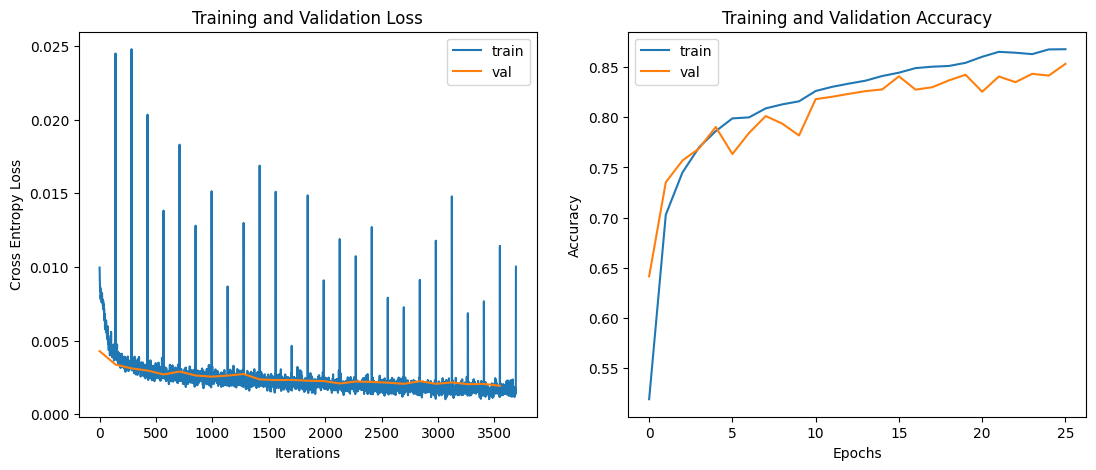

In [ ]:
# retrieve the optimal batch size and reload the corresponding data batches for plotting and testing
train_loader_tuned, val_loader_tuned, test_loader_tuned= generate_loaders(splits[0], splits[1], splits[2], batch_size=256)
plot_estop_eval(state_dict['epoch'],train_loader_tuned,
                state_dict['train_loss'],state_dict['val_loss'],
                state_dict['train_accuracy'], state_dict['val_accuracy'])

The sudden spikes in the loss indicate some undesirable noise introduced during the tuning process. Both train and val accuracy curves generally improve, but the train curve is higher towards the end, indicating that the model can improve further.

In [ ]:
print(f"Optimizer suggested upon Bayesian finetuning: {study_4.best_params['optimizer']}")
print(f"Batch size suggested upon Bayesian finetuning: {study_4.best_params['batch_size']}")
print(f"Learning rate suggested upon Bayesian finetuning: {study_4.best_params['lr']:.4f}")
print(f"Number of epochs suggested upon Bayesian finetuning: {study_4.best_params['epochs']:.4f}")
print(f"Patience value suggested upon Bayesian finetuning: {study_4.best_params['patience']:.4f}")

print(f"\nBest validation epoch loss obtained by the finetuned model: {state_dict['e_loss']:.4f}")

Optimizer suggested upon Bayesian finetuning: Adam
Batch size suggested upon Bayesian finetuning: 256
Learning rate suggested upon Bayesian finetuning: 0.0016
Number of epochs suggested upon Bayesian finetuning: 80.0000
Patience value suggested upon Bayesian finetuning: 17.0000

Best validation epoch loss obtained by the finetuned model: 0.0019


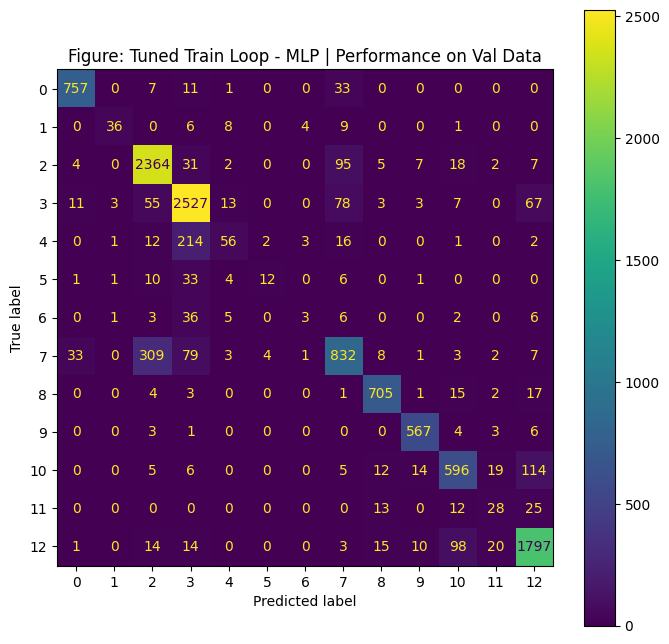

Loss: 0.4816, Accuracy: 85.33%


(0.4816217978452879, 85.33244791234333)

In [ ]:
#@title **Val Performance**
test_model(model_4, val_loader_tuned, loss_func,'Figure: Tuned Train Loop - MLP | Performance on Val Data')

The confusion matrix shows us that the perofrmance of the model is slightly better on classes with relatively less samples like class 4 compared to previous MLPs. However, still the most minority classes are classified poorly.

### 3.3. Long Short-Term Memory (LSTM)

The main limitation of MLPs is that it cannot take care of our temporal component of the data because the features need to be flattened before inputting to MLP thereby destroying the temporality.

LSTM is a recurrent neural network which is designed to handle the vanishing gradient problems usually observed in RNNs generally. The main feature of LSTMs is to capture patterns in sequences. Hence they're best suited for time-based data series.

For LSTM, we do not have to flatten our bands data present along the timeseries and can pass the sequence as is.

In [ ]:
# for lstm

# do not flatten for LSTM input- skip the Flatten transform
transform = transforms.Compose([MinMaxScale(minimum=minimum_2D,maximum=maximum_2D)]) #minimum, maximum of each feature is calculated and saved during EDA
dataset = CustomDataset(npz_file='/content/drive/MyDrive/MasterCDE/DeepLearning/FinalProject/data_DK1.npz', transform=transform)

In [ ]:
splits = dataset.train_test_val_splits(0.6,0.2) # remaining fraction will be validation
train_loader, val_loader, test_loader = generate_loaders(splits[0], splits[1], splits[2], batch_size=64)
for i in train_loader:
  print(i[0].shape) # check if the shape of the sequence is intact
  break

Order of output splits: Train, Validation, Test
torch.Size([64, 52, 10])


In [ ]:
num_features_lstm = dataset.X.shape[2]
num_classes = len(np.unique(dataset.y))
print(num_features_lstm,num_classes)

10 13


#### 3.3.1. Baseline LSTM

In [ ]:
# Assume you have training_data, training_labels, validation_data, and validation_labels
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.double()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Instantiating basic LSTM with 64 hidden units and 1 hidden layer
basic_lstm = LSTM(input_size=num_features_lstm, hidden_size=64, num_layers=1, output_size=num_classes)
print(basic_lstm)

LSTM(
  (lstm): LSTM(10, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=13, bias=True)
)


In [ ]:
%%time
optimizer = torch.optim.Adam(basic_lstm.parameters(), lr=0.01,)
save_path = root+ 'best_basicLSTM.pth'

# perform training, save the model at the best epoch val_loss
train_loss,train_accuracy, val_loss, val_accuracy=train_and_validate(basic_lstm,optimizer, loss_func,
                                                                     train_loader, val_loader , save_path, epochs=60)

Epoch 1/60, Epoch validation loss: 0.0124, Train acc.: 0.7287, Validation acc.: 0.7341
Epoch 2/60, Epoch validation loss: 0.0111, Train acc.: 0.7605, Validation acc.: 0.7687
Epoch 3/60, Epoch validation loss: 0.0102, Train acc.: 0.7839, Validation acc.: 0.7970
Epoch 4/60, Epoch validation loss: 0.0093, Train acc.: 0.7973, Validation acc.: 0.8100
Epoch 5/60, Epoch validation loss: 0.0097, Train acc.: 0.8148, Validation acc.: 0.8105
Epoch 6/60, Epoch validation loss: 0.0089, Train acc.: 0.8218, Validation acc.: 0.8236
Epoch 7/60, Epoch validation loss: 0.0087, Train acc.: 0.8296, Validation acc.: 0.8262
Epoch 8/60, Epoch validation loss: 0.0084, Train acc.: 0.8358, Validation acc.: 0.8341
Epoch 9/60, Epoch validation loss: 0.0082, Train acc.: 0.8424, Validation acc.: 0.8346
Epoch 10/60, Epoch validation loss: 0.0080, Train acc.: 0.8465, Validation acc.: 0.8411
Epoch 11/60, Epoch validation loss: 0.0080, Train acc.: 0.8506, Validation acc.: 0.8431
Epoch 12/60, Epoch validation loss: 0.007

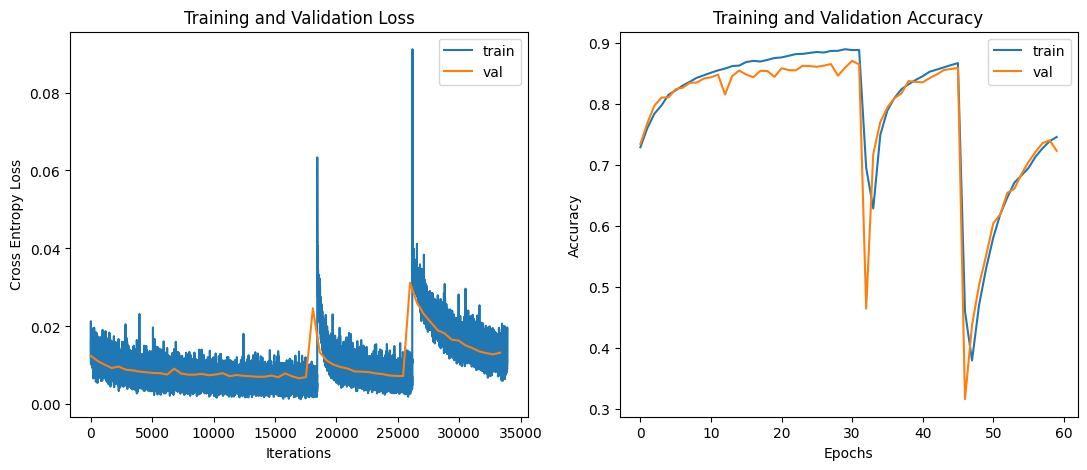

In [ ]:
plot_eval(60,train_loader,train_loss,val_loss,train_accuracy, val_accuracy)

The above graph shows that the validation and train cures are improveing together and following closely.

In [ ]:
# reconstruct path of the best trial
path = root + 'best_basicLSTM.pth'

state_dict = torch.load(path)
print(f"Best validation epoch loss obtained in Basic LSTM: {state_dict['e_loss']:.4f}")

Best validation epoch loss obtained in Basic LSTM: 0.0067


In [ ]:
# reconstruct path of the best trial
model_lstm_1 = LSTM(input_size=num_features_lstm, hidden_size=64, num_layers=1, output_size=num_classes)
state_dict = torch.load(path)
model_lstm_1.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

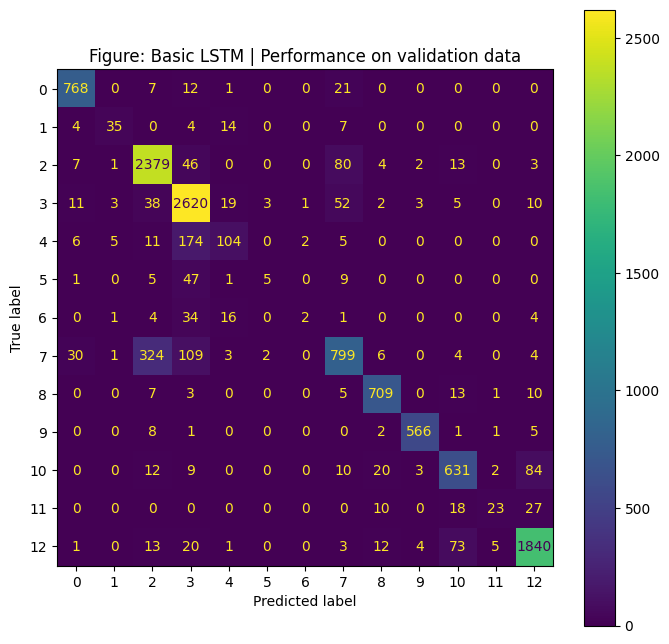

Loss: 0.4262, Accuracy: 87.00%


(0.42618166632875487, 87.00091309039595)

In [ ]:
#@title **Val Performance**
test_model(model_lstm_1, val_loader, loss_func, 'Figure: Basic LSTM | Performance on validation data')

We still observe misclassifications. However, the validation accuracy is 87% which is an improvement from MLP.  

**Since the minority class problem is persistent. I modify our loss function to consider class weights and retrain.**

#### 3.3.2. Weighted Class Loss

In [ ]:
def calculate_class_weights(data_loader, num_classes):
    class_counts = [0] * num_classes

    # Count the occurrences of each class in the dataset
    for _, labels in data_loader:
        for label in labels.numpy():
            class_counts[label] += 1
    # Calculate class weights using a formula that adjusts for imbalance
    total_samples = sum(class_counts)
    class_weights = [total_samples / (num_classes * count) for count in class_counts]
    return class_weights

def loss_func_weighted(class_weights, logits,y):
  return nn.CrossEntropyLoss(weight=class_weights)(logits, y)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.FloatTensor(calculate_class_weights(train_loader, num_classes))
class_weights = class_weights.to(device).double()

In [ ]:
%%time
basic_lstm_2 = LSTM(input_size=num_features_lstm, hidden_size=64, num_layers=1, output_size=num_classes)
optimizer = torch.optim.Adam(basic_lstm_2.parameters(), lr=0.01,)
save_path = root + 'best_basicLSTM_weightedloss.pth'
loss_func_weighted = nn.CrossEntropyLoss(weight=class_weights)
# perform training, save the model at the best epoch val_loss
train_loss,train_accuracy, val_loss, val_accuracy=train_and_validate(basic_lstm_2,optimizer, loss_func_weighted,
                                                                     train_loader, val_loader , save_path, epochs=60)

Epoch 1/60, Epoch validation loss: 0.0377, Train acc.: 0.1604, Validation acc.: 0.3003
Epoch 2/60, Epoch validation loss: 0.0275, Train acc.: 0.3101, Validation acc.: 0.3271
Epoch 3/60, Epoch validation loss: 0.0241, Train acc.: 0.4095, Validation acc.: 0.4551
Epoch 4/60, Epoch validation loss: 0.0219, Train acc.: 0.4711, Validation acc.: 0.4667
Epoch 5/60, Epoch validation loss: 0.0251, Train acc.: 0.5013, Validation acc.: 0.5503
Epoch 6/60, Epoch validation loss: 0.0211, Train acc.: 0.5454, Validation acc.: 0.6104
Epoch 7/60, Epoch validation loss: 0.0198, Train acc.: 0.5741, Validation acc.: 0.5889
Epoch 8/60, Epoch validation loss: 0.0197, Train acc.: 0.5885, Validation acc.: 0.5385
Epoch 9/60, Epoch validation loss: 0.0187, Train acc.: 0.5781, Validation acc.: 0.6395
Epoch 10/60, Epoch validation loss: 0.0188, Train acc.: 0.5756, Validation acc.: 0.6041
Epoch 11/60, Epoch validation loss: 0.0190, Train acc.: 0.5972, Validation acc.: 0.5788
Epoch 12/60, Epoch validation loss: 0.018

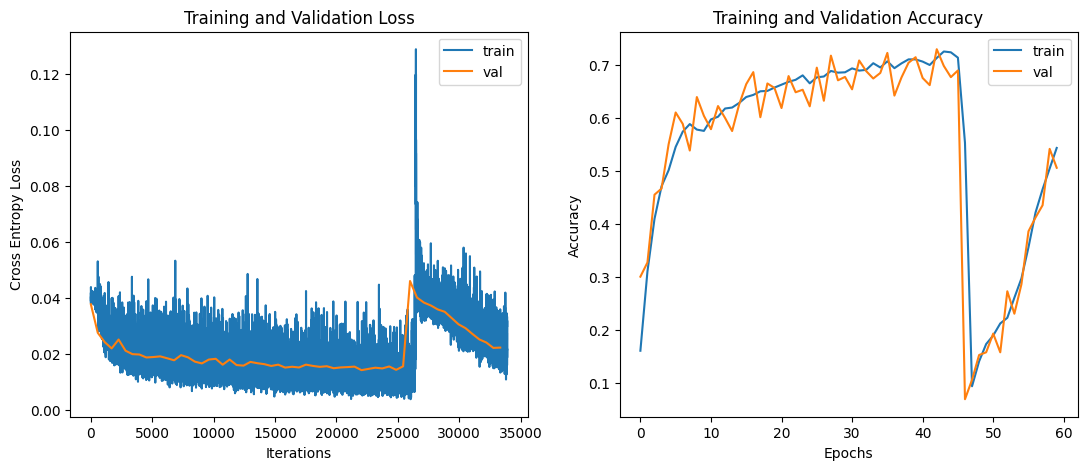

In [ ]:
plot_eval(60,train_loader,train_loss,val_loss,train_accuracy, val_accuracy)

In [ ]:
# reconstruct path of the best trial
path = root + 'best_basicLSTM_weightedloss.pth'

state_dict = torch.load(path)
print(f"Best validation epoch loss obtained in Basic LSTM with weighted loss: {state_dict['e_loss']:.4f}")

Best validation epoch loss obtained in Basic LSTM with weighted loss: 0.0141


In [ ]:
# reconstruct path of the best trial
model_lstm_2 = LSTM(input_size=num_features_lstm, hidden_size=64, num_layers=1, output_size=num_classes)
state_dict = torch.load(path)
model_lstm_2.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

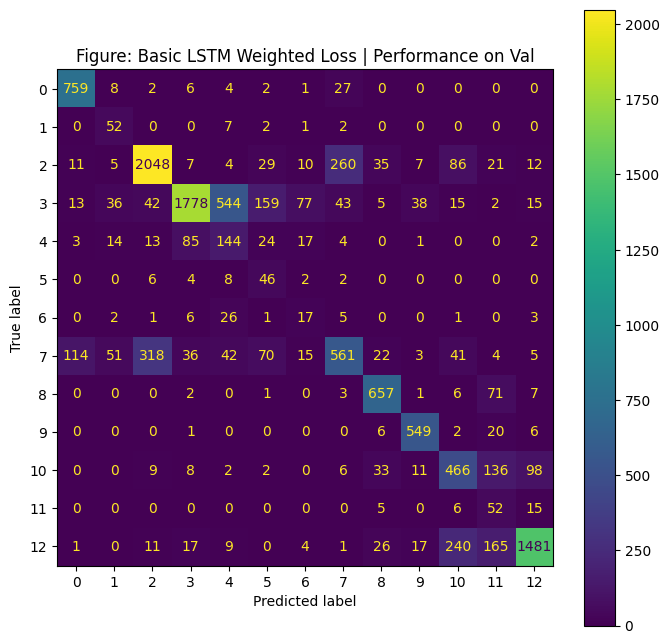

Loss: 0.8304, Accuracy: 71.47%


(0.8303731101470719, 71.47007553747821)

In [ ]:
#@title **Val Performance**
test_model(model_lstm_2,val_loader, loss_func, 'Figure: Basic LSTM Weighted Loss | Performance on Val')

We can see that while the accuracy on validation data dropped by more than 10 percentage points, the classifications of minority classes improved. In fact, for classes like 1, 5 and 11, the highest number of correct classifications are observed in this model of all the models trained so far.

#### 3.3.2. Finetuning architecture

In [ ]:
#@title **TPES Sampler - Bayesian**
# input_size=num_features, hidden_size=64, num_layers=1, output_size=num_classes
def objective4(trial):
    params = {
        'input_size':num_features_lstm,
        'output_size': num_classes,
        'num_layers': trial.suggest_categorical('num_layers', [1,2,3,4]),
        'hidden_size': trial.suggest_categorical('num_hidden_units', [32,64,128,256])
        }
    trial_number = trial.number
    # define the model with the given parameters, make predictions
    model = LSTM(**params)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # create a new path for saving the best epoch model for each trial
    # since we do not know in advance which trial will the best, we will have to save all
    # and then read the best epoch of the best trial at the end
    save_path = root + f'trial_{trial_number}' + 'best_ModLSTM.pth'
    train_loss,train_accuracy, val_loss, val_accuracy,e=mod_train_and_validate(model,optimizer, loss_func,
                                                                             train_loader, val_loader,save_path=save_path,
                                                                             epochs=60)
    return val_loss[-1]

In [ ]:
%%time
sampler = TPESampler(seed=123)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study5= optuna.create_study(direction='minimize', sampler=sampler)
study5.optimize(objective4, n_trials=20)

[I 2024-01-07 00:30:53,973] A new study created in memory with name: no-name-9ce4c83c-9e18-44b1-93ea-453b40f3152f


Epoch 1/60, Epoch validation loss: 0.0272, Train acc: 0.2766, Validation acc: 0.4009
Epoch 2/60, Epoch validation loss: 0.0139, Train acc: 0.6188, Validation acc: 0.7070
Epoch 3/60, Epoch validation loss: 0.0115, Train acc: 0.7350, Validation acc: 0.7596
Epoch 4/60, Epoch validation loss: 0.0107, Train acc: 0.7690, Validation acc: 0.7768
Epoch 5/60, Epoch validation loss: 0.0109, Train acc: 0.7987, Validation acc: 0.7732
Epoch 6/60, Epoch validation loss: 0.0091, Train acc: 0.8142, Validation acc: 0.8173
Epoch 7/60, Epoch validation loss: 0.0095, Train acc: 0.8276, Validation acc: 0.8052
Epoch 8/60, Epoch validation loss: 0.0082, Train acc: 0.8363, Validation acc: 0.8322
Epoch 9/60, Epoch validation loss: 0.0082, Train acc: 0.8452, Validation acc: 0.8318
Epoch 10/60, Epoch validation loss: 0.0080, Train acc: 0.8476, Validation acc: 0.8407
Epoch 11/60, Epoch validation loss: 0.0079, Train acc: 0.8565, Validation acc: 0.8462
Epoch 12/60, Epoch validation loss: 0.0078, Train acc: 0.8566, 

[I 2024-01-07 00:34:24,873] Trial 0 finished with value: 0.007492022234032284 and parameters: {'num_layers': 1, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 16/60, Epoch validation loss: 0.0075, Train acc: 0.8724, Validation acc: 0.8537
Training finished.
Epoch 1/60, Epoch validation loss: 0.0330, Train acc: 0.2153, Validation acc: 0.2104
Epoch 2/60, Epoch validation loss: 0.0329, Train acc: 0.2207, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0331, Train acc: 0.2219, Validation acc: 0.2104
Epoch 4/60, Epoch validation loss: 0.0329, Train acc: 0.2221, Validation acc: 0.2104
Epoch 5/60, Epoch validation loss: 0.0329, Train acc: 0.2232, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0329, Train acc: 0.2219, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2221, Validation acc: 0.2104


[I 2024-01-07 00:50:06,735] Trial 1 finished with value: 0.032938240124440854 and parameters: {'num_layers': 4, 'num_hidden_units': 256}. Best is trial 0 with value: 0.007492022234032284.


Epoch 8/60, Epoch validation loss: 0.0329, Train acc: 0.2213, Validation acc: 0.2104
Training finished.
Epoch 1/60, Epoch validation loss: 0.0329, Train acc: 0.2229, Validation acc: 0.2104
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2215, Validation acc: 0.2104
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2227, Validation acc: 0.2104
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2242, Validation acc: 0.2104
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2247, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0328, Train acc: 0.2284, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2272, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0328, Train acc: 0.2248, Validation acc: 0.2104


[I 2024-01-07 00:52:50,381] Trial 2 finished with value: 0.032849542025112755 and parameters: {'num_layers': 4, 'num_hidden_units': 64}. Best is trial 0 with value: 0.007492022234032284.


Epoch 9/60, Epoch validation loss: 0.0328, Train acc: 0.2240, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0296, Train acc: 0.2562, Validation acc: 0.3607
Epoch 2/60, Epoch validation loss: 0.0185, Train acc: 0.4948, Validation acc: 0.6054
Epoch 3/60, Epoch validation loss: 0.0168, Train acc: 0.6552, Validation acc: 0.6550
Epoch 4/60, Epoch validation loss: 0.0135, Train acc: 0.7123, Validation acc: 0.7187
Epoch 5/60, Epoch validation loss: 0.0124, Train acc: 0.7395, Validation acc: 0.7467
Epoch 6/60, Epoch validation loss: 0.0118, Train acc: 0.7605, Validation acc: 0.7655
Epoch 7/60, Epoch validation loss: 0.0111, Train acc: 0.7736, Validation acc: 0.7769
Epoch 8/60, Epoch validation loss: 0.0112, Train acc: 0.7876, Validation acc: 0.7719
Epoch 9/60, Epoch validation loss: 0.0098, Train acc: 0.7986, Validation acc: 0.8044
Epoch 10/60, Epoch validation loss: 0.0099, Train acc: 0.8020, Validation acc: 0.8010
Epoch 11/60, Epoch validation loss: 0.0098, T

[I 2024-01-07 00:55:33,194] Trial 3 finished with value: 0.010202362680404224 and parameters: {'num_layers': 1, 'num_hidden_units': 64}. Best is trial 0 with value: 0.007492022234032284.


Epoch 15/60, Epoch validation loss: 0.0102, Train acc: 0.7851, Validation acc: 0.7927
Training finished.
Epoch 1/60, Epoch validation loss: 0.0329, Train acc: 0.2203, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0330, Train acc: 0.2248, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2235, Validation acc: 0.2104
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2224, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2235, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0328, Train acc: 0.2225, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0329, Train acc: 0.2273, Validation acc: 0.2297


[I 2024-01-07 00:58:29,554] Trial 4 finished with value: 0.0328227604668704 and parameters: {'num_layers': 2, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 8/60, Epoch validation loss: 0.0328, Train acc: 0.2235, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0307, Train acc: 0.2483, Validation acc: 0.3268
Epoch 2/60, Epoch validation loss: 0.0316, Train acc: 0.3928, Validation acc: 0.3409
Epoch 3/60, Epoch validation loss: 0.0159, Train acc: 0.6150, Validation acc: 0.6685
Epoch 4/60, Epoch validation loss: 0.0134, Train acc: 0.7024, Validation acc: 0.7195
Epoch 5/60, Epoch validation loss: 0.0119, Train acc: 0.7366, Validation acc: 0.7574
Epoch 6/60, Epoch validation loss: 0.0137, Train acc: 0.7633, Validation acc: 0.7255
Epoch 7/60, Epoch validation loss: 0.0103, Train acc: 0.7844, Validation acc: 0.7867
Epoch 8/60, Epoch validation loss: 0.0102, Train acc: 0.7960, Validation acc: 0.7892
Epoch 9/60, Epoch validation loss: 0.0091, Train acc: 0.8068, Validation acc: 0.8159
Epoch 10/60, Epoch validation loss: 0.0096, Train acc: 0.8150, Validation acc: 0.8011
Epoch 11/60, Epoch validation loss: 0.0092, T

[I 2024-01-07 01:04:51,150] Trial 5 finished with value: 0.0084321253970575 and parameters: {'num_layers': 1, 'num_hidden_units': 256}. Best is trial 0 with value: 0.007492022234032284.


Epoch 15/60, Epoch validation loss: 0.0084, Train acc: 0.8464, Validation acc: 0.8289
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2209, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2258, Validation acc: 0.2104
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2262, Validation acc: 0.2104
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2258, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0327, Train acc: 0.2258, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0328, Train acc: 0.2305, Validation acc: 0.2104
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2259, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0328, Train acc: 0.2269, Validation acc: 0.2297
Epoch 9/60, Epoch validation loss: 0.0327, Train acc: 0.2253, Validation acc: 0.2297
Epoch 10/60, Epoch validation loss: 0.0327, Train acc: 0.2287, Validation acc: 0.2297
Epoch 11/60, Epoch validation loss: 0.0328, 

[I 2024-01-07 01:07:14,298] Trial 6 finished with value: 0.032751402607445294 and parameters: {'num_layers': 4, 'num_hidden_units': 32}. Best is trial 0 with value: 0.007492022234032284.


Epoch 12/60, Epoch validation loss: 0.0328, Train acc: 0.2273, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2226, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2241, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0329, Train acc: 0.2257, Validation acc: 0.2104
Epoch 4/60, Epoch validation loss: 0.0329, Train acc: 0.2245, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0330, Train acc: 0.2220, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0329, Train acc: 0.2240, Validation acc: 0.2297


[I 2024-01-07 01:17:38,953] Trial 7 finished with value: 0.0329680645099959 and parameters: {'num_layers': 3, 'num_hidden_units': 256}. Best is trial 0 with value: 0.007492022234032284.


Epoch 7/60, Epoch validation loss: 0.0330, Train acc: 0.2250, Validation acc: 0.2104
Training finished.
Epoch 1/60, Epoch validation loss: 0.0325, Train acc: 0.2318, Validation acc: 0.2590
Epoch 2/60, Epoch validation loss: 0.0276, Train acc: 0.3296, Validation acc: 0.4062
Epoch 3/60, Epoch validation loss: 0.0244, Train acc: 0.4469, Validation acc: 0.4829
Epoch 4/60, Epoch validation loss: 0.0217, Train acc: 0.4896, Validation acc: 0.5468
Epoch 5/60, Epoch validation loss: 0.0162, Train acc: 0.5925, Validation acc: 0.6568
Epoch 6/60, Epoch validation loss: 0.0132, Train acc: 0.6945, Validation acc: 0.7299
Epoch 7/60, Epoch validation loss: 0.0120, Train acc: 0.7465, Validation acc: 0.7471
Epoch 8/60, Epoch validation loss: 0.0113, Train acc: 0.7684, Validation acc: 0.7659
Epoch 9/60, Epoch validation loss: 0.0103, Train acc: 0.7863, Validation acc: 0.7926
Epoch 10/60, Epoch validation loss: 0.0098, Train acc: 0.7987, Validation acc: 0.8017
Epoch 11/60, Epoch validation loss: 0.0096, T

[I 2024-01-07 01:27:49,879] Trial 8 finished with value: 0.008815323099473839 and parameters: {'num_layers': 1, 'num_hidden_units': 256}. Best is trial 0 with value: 0.007492022234032284.


Epoch 24/60, Epoch validation loss: 0.0088, Train acc: 0.8672, Validation acc: 0.8261
Training finished.
Epoch 1/60, Epoch validation loss: 0.0333, Train acc: 0.2092, Validation acc: 0.2104
Epoch 2/60, Epoch validation loss: 0.0335, Train acc: 0.2121, Validation acc: 0.2104
Epoch 3/60, Epoch validation loss: 0.0336, Train acc: 0.2124, Validation acc: 0.1637
Epoch 4/60, Epoch validation loss: 0.0336, Train acc: 0.2124, Validation acc: 0.2104
Epoch 5/60, Epoch validation loss: 0.0337, Train acc: 0.2122, Validation acc: 0.2297


[I 2024-01-07 01:33:44,581] Trial 9 finished with value: 0.033350152184195805 and parameters: {'num_layers': 2, 'num_hidden_units': 256}. Best is trial 0 with value: 0.007492022234032284.


Epoch 6/60, Epoch validation loss: 0.0334, Train acc: 0.2130, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0330, Train acc: 0.2211, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0329, Train acc: 0.2243, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2222, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0329, Train acc: 0.2225, Validation acc: 0.2104
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2231, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0329, Train acc: 0.2241, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2269, Validation acc: 0.2297


[I 2024-01-07 01:37:50,281] Trial 10 finished with value: 0.03279294432853673 and parameters: {'num_layers': 3, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 8/60, Epoch validation loss: 0.0328, Train acc: 0.2216, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0295, Train acc: 0.2606, Validation acc: 0.3662
Epoch 2/60, Epoch validation loss: 0.0173, Train acc: 0.4658, Validation acc: 0.6359
Epoch 3/60, Epoch validation loss: 0.0142, Train acc: 0.6887, Validation acc: 0.7054
Epoch 4/60, Epoch validation loss: 0.0116, Train acc: 0.7480, Validation acc: 0.7535
Epoch 5/60, Epoch validation loss: 0.0100, Train acc: 0.7786, Validation acc: 0.7921
Epoch 6/60, Epoch validation loss: 0.0105, Train acc: 0.8009, Validation acc: 0.7804
Epoch 7/60, Epoch validation loss: 0.0093, Train acc: 0.8150, Validation acc: 0.8107
Epoch 8/60, Epoch validation loss: 0.0092, Train acc: 0.8267, Validation acc: 0.8159
Epoch 9/60, Epoch validation loss: 0.0089, Train acc: 0.8360, Validation acc: 0.8222
Epoch 10/60, Epoch validation loss: 0.0081, Train acc: 0.8440, Validation acc: 0.8409
Epoch 11/60, Epoch validation loss: 0.0082, T

[I 2024-01-07 01:41:23,383] Trial 11 finished with value: 0.007701811742402289 and parameters: {'num_layers': 1, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 16/60, Epoch validation loss: 0.0077, Train acc: 0.8713, Validation acc: 0.8509
Training finished.
Epoch 1/60, Epoch validation loss: 0.0261, Train acc: 0.2732, Validation acc: 0.4629
Epoch 2/60, Epoch validation loss: 0.0270, Train acc: 0.3763, Validation acc: 0.4249
Epoch 3/60, Epoch validation loss: 0.0170, Train acc: 0.5676, Validation acc: 0.6528
Epoch 4/60, Epoch validation loss: 0.0156, Train acc: 0.6518, Validation acc: 0.6688
Epoch 5/60, Epoch validation loss: 0.0140, Train acc: 0.6833, Validation acc: 0.7059
Epoch 6/60, Epoch validation loss: 0.0132, Train acc: 0.7066, Validation acc: 0.7198
Epoch 7/60, Epoch validation loss: 0.0118, Train acc: 0.7323, Validation acc: 0.7553
Epoch 8/60, Epoch validation loss: 0.0116, Train acc: 0.7486, Validation acc: 0.7611
Epoch 9/60, Epoch validation loss: 0.0112, Train acc: 0.7643, Validation acc: 0.7702
Epoch 10/60, Epoch validation loss: 0.0110, Train acc: 0.7786, Validation acc: 0.7761
Epoch 11/60, Epoch validation loss: 0.0104, 

[I 2024-01-07 01:46:03,494] Trial 12 finished with value: 0.008589133224628502 and parameters: {'num_layers': 1, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 21/60, Epoch validation loss: 0.0086, Train acc: 0.8397, Validation acc: 0.8315
Training finished.
Epoch 1/60, Epoch validation loss: 0.0320, Train acc: 0.2500, Validation acc: 0.2619
Epoch 2/60, Epoch validation loss: 0.0209, Train acc: 0.4660, Validation acc: 0.5663
Epoch 3/60, Epoch validation loss: 0.0180, Train acc: 0.6121, Validation acc: 0.6058
Epoch 4/60, Epoch validation loss: 0.0129, Train acc: 0.6750, Validation acc: 0.7290
Epoch 5/60, Epoch validation loss: 0.0109, Train acc: 0.7452, Validation acc: 0.7765
Epoch 6/60, Epoch validation loss: 0.0103, Train acc: 0.7772, Validation acc: 0.7891
Epoch 7/60, Epoch validation loss: 0.0098, Train acc: 0.7898, Validation acc: 0.8034
Epoch 8/60, Epoch validation loss: 0.0101, Train acc: 0.8075, Validation acc: 0.7940
Epoch 9/60, Epoch validation loss: 0.0089, Train acc: 0.8153, Validation acc: 0.8218
Epoch 10/60, Epoch validation loss: 0.0092, Train acc: 0.8239, Validation acc: 0.8133
Epoch 11/60, Epoch validation loss: 0.0088, 

[I 2024-01-07 01:49:23,426] Trial 13 finished with value: 0.008774529117662484 and parameters: {'num_layers': 1, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 15/60, Epoch validation loss: 0.0088, Train acc: 0.8523, Validation acc: 0.8244
Training finished.
Epoch 1/60, Epoch validation loss: 0.0297, Train acc: 0.2566, Validation acc: 0.3477
Epoch 2/60, Epoch validation loss: 0.0189, Train acc: 0.4790, Validation acc: 0.6054
Epoch 3/60, Epoch validation loss: 0.0158, Train acc: 0.6059, Validation acc: 0.6730
Epoch 4/60, Epoch validation loss: 0.0143, Train acc: 0.6794, Validation acc: 0.7063
Epoch 5/60, Epoch validation loss: 0.0135, Train acc: 0.7141, Validation acc: 0.7254
Epoch 6/60, Epoch validation loss: 0.0114, Train acc: 0.7512, Validation acc: 0.7716
Epoch 7/60, Epoch validation loss: 0.0114, Train acc: 0.7682, Validation acc: 0.7634
Epoch 8/60, Epoch validation loss: 0.0105, Train acc: 0.7863, Validation acc: 0.7829
Epoch 9/60, Epoch validation loss: 0.0098, Train acc: 0.7918, Validation acc: 0.7996
Epoch 10/60, Epoch validation loss: 0.0101, Train acc: 0.8090, Validation acc: 0.7916
Epoch 11/60, Epoch validation loss: 0.0090, 

[I 2024-01-07 01:53:10,055] Trial 14 finished with value: 0.00840683825908284 and parameters: {'num_layers': 1, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 17/60, Epoch validation loss: 0.0084, Train acc: 0.8506, Validation acc: 0.8332
Training finished.
Epoch 1/60, Epoch validation loss: 0.0292, Train acc: 0.2501, Validation acc: 0.3800
Epoch 2/60, Epoch validation loss: 0.0224, Train acc: 0.5070, Validation acc: 0.5155
Epoch 3/60, Epoch validation loss: 0.0145, Train acc: 0.6521, Validation acc: 0.6933
Epoch 4/60, Epoch validation loss: 0.0124, Train acc: 0.7140, Validation acc: 0.7418
Epoch 5/60, Epoch validation loss: 0.0126, Train acc: 0.7447, Validation acc: 0.7291
Epoch 6/60, Epoch validation loss: 0.0111, Train acc: 0.7633, Validation acc: 0.7692
Epoch 7/60, Epoch validation loss: 0.0112, Train acc: 0.7719, Validation acc: 0.7682
Epoch 8/60, Epoch validation loss: 0.0101, Train acc: 0.7862, Validation acc: 0.7953
Epoch 9/60, Epoch validation loss: 0.0105, Train acc: 0.7935, Validation acc: 0.7833
Epoch 10/60, Epoch validation loss: 0.0096, Train acc: 0.8036, Validation acc: 0.8031
Epoch 11/60, Epoch validation loss: 0.0097, 

[I 2024-01-07 01:54:52,211] Trial 15 finished with value: 0.010084007922040956 and parameters: {'num_layers': 1, 'num_hidden_units': 32}. Best is trial 0 with value: 0.007492022234032284.


Epoch 12/60, Epoch validation loss: 0.0101, Train acc: 0.8151, Validation acc: 0.7955
Training finished.
Epoch 1/60, Epoch validation loss: 0.0284, Train acc: 0.2800, Validation acc: 0.3934
Epoch 2/60, Epoch validation loss: 0.0257, Train acc: 0.4357, Validation acc: 0.4690
Epoch 3/60, Epoch validation loss: 0.0165, Train acc: 0.5822, Validation acc: 0.6498
Epoch 4/60, Epoch validation loss: 0.0143, Train acc: 0.6734, Validation acc: 0.6912
Epoch 5/60, Epoch validation loss: 0.0123, Train acc: 0.7218, Validation acc: 0.7395
Epoch 6/60, Epoch validation loss: 0.0111, Train acc: 0.7574, Validation acc: 0.7686
Epoch 7/60, Epoch validation loss: 0.0107, Train acc: 0.7827, Validation acc: 0.7797
Epoch 8/60, Epoch validation loss: 0.0102, Train acc: 0.7985, Validation acc: 0.7902
Epoch 9/60, Epoch validation loss: 0.0094, Train acc: 0.8046, Validation acc: 0.8043
Epoch 10/60, Epoch validation loss: 0.0092, Train acc: 0.8128, Validation acc: 0.8143
Epoch 11/60, Epoch validation loss: 0.0091, 

[I 2024-01-07 01:58:25,284] Trial 16 finished with value: 0.011981427335608535 and parameters: {'num_layers': 1, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 16/60, Epoch validation loss: 0.0120, Train acc: 0.7716, Validation acc: 0.7545
Training finished.
Epoch 1/60, Epoch validation loss: 0.0293, Train acc: 0.2401, Validation acc: 0.3527
Epoch 2/60, Epoch validation loss: 0.0212, Train acc: 0.3342, Validation acc: 0.5445
Epoch 3/60, Epoch validation loss: 0.0146, Train acc: 0.6174, Validation acc: 0.6914
Epoch 4/60, Epoch validation loss: 0.0125, Train acc: 0.7069, Validation acc: 0.7388
Epoch 5/60, Epoch validation loss: 0.0121, Train acc: 0.7426, Validation acc: 0.7397
Epoch 6/60, Epoch validation loss: 0.0113, Train acc: 0.7531, Validation acc: 0.7634
Epoch 7/60, Epoch validation loss: 0.0103, Train acc: 0.7744, Validation acc: 0.7868
Epoch 8/60, Epoch validation loss: 0.0099, Train acc: 0.7875, Validation acc: 0.7992
Epoch 9/60, Epoch validation loss: 0.0097, Train acc: 0.8007, Validation acc: 0.7997
Epoch 10/60, Epoch validation loss: 0.0106, Train acc: 0.8091, Validation acc: 0.7796
Epoch 11/60, Epoch validation loss: 0.0091, 

[I 2024-01-07 02:04:17,002] Trial 17 finished with value: 0.00965195575057557 and parameters: {'num_layers': 2, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 16/60, Epoch validation loss: 0.0097, Train acc: 0.7655, Validation acc: 0.8005
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2245, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2255, Validation acc: 0.2104
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2264, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2268, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2254, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0328, Train acc: 0.2273, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2266, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0327, Train acc: 0.2270, Validation acc: 0.2297


[I 2024-01-07 02:08:54,277] Trial 18 finished with value: 0.03278706273681363 and parameters: {'num_layers': 3, 'num_hidden_units': 128}. Best is trial 0 with value: 0.007492022234032284.


Epoch 9/60, Epoch validation loss: 0.0328, Train acc: 0.2286, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0269, Train acc: 0.2918, Validation acc: 0.4211
Epoch 2/60, Epoch validation loss: 0.0178, Train acc: 0.5540, Validation acc: 0.6154
Epoch 3/60, Epoch validation loss: 0.0141, Train acc: 0.6583, Validation acc: 0.7057
Epoch 4/60, Epoch validation loss: 0.0119, Train acc: 0.7182, Validation acc: 0.7523
Epoch 5/60, Epoch validation loss: 0.0113, Train acc: 0.7494, Validation acc: 0.7623
Epoch 6/60, Epoch validation loss: 0.0106, Train acc: 0.7597, Validation acc: 0.7795
Epoch 7/60, Epoch validation loss: 0.0122, Train acc: 0.7727, Validation acc: 0.7469
Epoch 8/60, Epoch validation loss: 0.0108, Train acc: 0.7813, Validation acc: 0.7789
Epoch 9/60, Epoch validation loss: 0.0105, Train acc: 0.7914, Validation acc: 0.7797
Epoch 10/60, Epoch validation loss: 0.0099, Train acc: 0.7962, Validation acc: 0.7990
Epoch 11/60, Epoch validation loss: 0.0094, T

[I 2024-01-07 02:11:28,671] Trial 19 finished with value: 0.008906736221409436 and parameters: {'num_layers': 1, 'num_hidden_units': 32}. Best is trial 0 with value: 0.007492022234032284.


Epoch 18/60, Epoch validation loss: 0.0089, Train acc: 0.8357, Validation acc: 0.8176
Training finished.
CPU times: user 1h 38min 38s, sys: 15.3 s, total: 1h 38min 54s
Wall time: 1h 40min 34s


In [ ]:
# # # for loading the study later
# save_study_ = root + 'optuna_study_best_ModLSTM.pkl'
# #joblib.dump(study4, save_study_)
# study_5 = joblib.load(save_study_)
# study_5.best_trial, study_4.best_params

**Important Note**: Here I tried the TES Sampler to implement Bayesian suggestions on the number of layers and hidden units on a fixed set of choices for both hyperparameters- as per the Optuna documentation, this should result in trials selecting more of those parameter choices, from the fixed set of options, that are more likely to result result in less loss (or study objective). And I observed that indeed, `num_layers = 1` was the most frequent choice. And was also the final best parameter value. While I overwrote the study file, by mistake, with the next set of codeblocks, I was still able to find the best parameters selected from this approach using the log in the output cell: `best_trial=0` , `best_params` `= {num_layers: 1, num_hidden_units: 128}`



<p>I now try GridSearch to test if I get the same recommendation for the parameters or a different one. In GridSearch, every possible combination is attempted, unlike Bayesian suggestions.

In [ ]:
#@title **GridSampler - GridSearch**
# redo the trial but with gridsampler
# input_size=num_features, hidden_size=64, num_layers=1, output_size=num_classes
def objective5(trial):
    params = {
        'input_size':num_features_lstm,
        'output_size': num_classes,
        'num_layers': trial.suggest_categorical('num_layers', [1,2,3,4]),
        'hidden_size': trial.suggest_categorical('hidden_size', [32,64,128,256])
        }
    trial_number = trial.number
    # define the model with the given parameters, make predictions

    model = LSTM(**params)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # create a new path for saving the best epoch model for each trial
    save_path = root + f'trial_{trial_number}' + 'best_ModLSTM.pth'
    train_loss,train_accuracy, val_loss, val_accuracy,e=mod_train_and_validate(model,optimizer, loss_func,
                                                                             train_loader, val_loader,save_path=save_path,
                                                                             epochs=60)
    return val_loss[-1]

In [ ]:
%%time
search_space={"num_layers":[1,2,3,4], "hidden_size":[32,64,128,256]}
sampler = sampler=optuna.samplers.GridSampler(search_space)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study5 = optuna.create_study(direction='minimize', sampler=sampler)
study5.optimize(objective5, n_trials=20)

[I 2024-01-07 05:57:15,870] A new study created in memory with name: no-name-02173500-e613-44cf-87f5-76c7ffedac25


Epoch 1/60, Epoch validation loss: 0.0343, Train acc: 0.2129, Validation acc: 0.1637
Epoch 2/60, Epoch validation loss: 0.0354, Train acc: 0.2126, Validation acc: 0.1637
Epoch 3/60, Epoch validation loss: 0.0338, Train acc: 0.2072, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0335, Train acc: 0.2084, Validation acc: 0.1637
Epoch 5/60, Epoch validation loss: 0.0345, Train acc: 0.2160, Validation acc: 0.2104
Epoch 6/60, Epoch validation loss: 0.0334, Train acc: 0.2163, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0342, Train acc: 0.2069, Validation acc: 0.2104
Epoch 8/60, Epoch validation loss: 0.0340, Train acc: 0.2128, Validation acc: 0.2104


[I 2024-01-07 06:05:58,806] Trial 0 finished with value: 0.03349386922993375 and parameters: {'num_layers': 2, 'hidden_size': 256}. Best is trial 0 with value: 0.03349386922993375.


Epoch 9/60, Epoch validation loss: 0.0335, Train acc: 0.2119, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2248, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2263, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2270, Validation acc: 0.2104
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2253, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2274, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0327, Train acc: 0.2271, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2267, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0328, Train acc: 0.2247, Validation acc: 0.2104
Epoch 9/60, Epoch validation loss: 0.0328, Train acc: 0.2264, Validation acc: 0.2297


[I 2024-01-07 06:08:28,953] Trial 1 finished with value: 0.03275802118835856 and parameters: {'num_layers': 3, 'hidden_size': 64}. Best is trial 1 with value: 0.03275802118835856.


Epoch 10/60, Epoch validation loss: 0.0328, Train acc: 0.2279, Validation acc: 0.2104
Training finished.
Epoch 1/60, Epoch validation loss: 0.0305, Train acc: 0.2567, Validation acc: 0.3369
Epoch 2/60, Epoch validation loss: 0.0199, Train acc: 0.4385, Validation acc: 0.5967
Epoch 3/60, Epoch validation loss: 0.0167, Train acc: 0.6351, Validation acc: 0.6617
Epoch 4/60, Epoch validation loss: 0.0130, Train acc: 0.7035, Validation acc: 0.7314
Epoch 5/60, Epoch validation loss: 0.0116, Train acc: 0.7488, Validation acc: 0.7592
Epoch 6/60, Epoch validation loss: 0.0113, Train acc: 0.7718, Validation acc: 0.7608
Epoch 7/60, Epoch validation loss: 0.0107, Train acc: 0.7884, Validation acc: 0.7780
Epoch 8/60, Epoch validation loss: 0.0099, Train acc: 0.7957, Validation acc: 0.8005
Epoch 9/60, Epoch validation loss: 0.0094, Train acc: 0.8062, Validation acc: 0.8071
Epoch 10/60, Epoch validation loss: 0.0092, Train acc: 0.8139, Validation acc: 0.8109
Epoch 11/60, Epoch validation loss: 0.0090, 

[I 2024-01-07 06:11:49,653] Trial 2 finished with value: 0.008730379368660168 and parameters: {'num_layers': 1, 'hidden_size': 64}. Best is trial 2 with value: 0.008730379368660168.


Epoch 19/60, Epoch validation loss: 0.0087, Train acc: 0.8515, Validation acc: 0.8271
Training finished.
Epoch 1/60, Epoch validation loss: 0.0329, Train acc: 0.2198, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2237, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2294, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2240, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2237, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0327, Train acc: 0.2249, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2226, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0329, Train acc: 0.2261, Validation acc: 0.2297
Epoch 9/60, Epoch validation loss: 0.0328, Train acc: 0.2237, Validation acc: 0.2297


[I 2024-01-07 06:16:52,895] Trial 3 finished with value: 0.032857339922173406 and parameters: {'num_layers': 3, 'hidden_size': 128}. Best is trial 2 with value: 0.008730379368660168.


Epoch 10/60, Epoch validation loss: 0.0329, Train acc: 0.2242, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0314, Train acc: 0.2277, Validation acc: 0.3175
Epoch 2/60, Epoch validation loss: 0.0248, Train acc: 0.3946, Validation acc: 0.4979
Epoch 3/60, Epoch validation loss: 0.0281, Train acc: 0.3101, Validation acc: 0.4022
Epoch 4/60, Epoch validation loss: 0.0226, Train acc: 0.4676, Validation acc: 0.5191
Epoch 5/60, Epoch validation loss: 0.0193, Train acc: 0.6073, Validation acc: 0.6061
Epoch 6/60, Epoch validation loss: 0.0168, Train acc: 0.6371, Validation acc: 0.6478
Epoch 7/60, Epoch validation loss: 0.0156, Train acc: 0.6527, Validation acc: 0.6632
Epoch 8/60, Epoch validation loss: 0.0154, Train acc: 0.6700, Validation acc: 0.6685
Epoch 9/60, Epoch validation loss: 0.0134, Train acc: 0.6951, Validation acc: 0.7172
Epoch 10/60, Epoch validation loss: 0.0128, Train acc: 0.7237, Validation acc: 0.7311
Epoch 11/60, Epoch validation loss: 0.0127, 

[I 2024-01-07 06:19:50,380] Trial 4 finished with value: 0.010122110699432016 and parameters: {'num_layers': 2, 'hidden_size': 32}. Best is trial 2 with value: 0.008730379368660168.


Epoch 19/60, Epoch validation loss: 0.0101, Train acc: 0.8074, Validation acc: 0.7991
Training finished.
Epoch 1/60, Epoch validation loss: 0.0306, Train acc: 0.2394, Validation acc: 0.3399
Epoch 2/60, Epoch validation loss: 0.0246, Train acc: 0.4261, Validation acc: 0.4594
Epoch 3/60, Epoch validation loss: 0.0160, Train acc: 0.5712, Validation acc: 0.6690
Epoch 4/60, Epoch validation loss: 0.0134, Train acc: 0.6995, Validation acc: 0.7165
Epoch 5/60, Epoch validation loss: 0.0128, Train acc: 0.7286, Validation acc: 0.7310
Epoch 6/60, Epoch validation loss: 0.0112, Train acc: 0.7536, Validation acc: 0.7677
Epoch 7/60, Epoch validation loss: 0.0114, Train acc: 0.7722, Validation acc: 0.7669
Epoch 8/60, Epoch validation loss: 0.0104, Train acc: 0.7888, Validation acc: 0.7829
Epoch 9/60, Epoch validation loss: 0.0098, Train acc: 0.8001, Validation acc: 0.8012
Epoch 10/60, Epoch validation loss: 0.0100, Train acc: 0.8052, Validation acc: 0.7936
Epoch 11/60, Epoch validation loss: 0.0093, 

[I 2024-01-07 06:23:19,272] Trial 5 finished with value: 0.009351939073719444 and parameters: {'num_layers': 2, 'hidden_size': 64}. Best is trial 2 with value: 0.008730379368660168.


Epoch 17/60, Epoch validation loss: 0.0094, Train acc: 0.8447, Validation acc: 0.8138
Training finished.
Epoch 1/60, Epoch validation loss: 0.0294, Train acc: 0.2763, Validation acc: 0.3646
Epoch 2/60, Epoch validation loss: 0.0201, Train acc: 0.4518, Validation acc: 0.5796
Epoch 3/60, Epoch validation loss: 0.0155, Train acc: 0.6216, Validation acc: 0.6756
Epoch 4/60, Epoch validation loss: 0.0131, Train acc: 0.7002, Validation acc: 0.7247
Epoch 5/60, Epoch validation loss: 0.0126, Train acc: 0.7410, Validation acc: 0.7310
Epoch 6/60, Epoch validation loss: 0.0105, Train acc: 0.7654, Validation acc: 0.7820
Epoch 7/60, Epoch validation loss: 0.0100, Train acc: 0.7852, Validation acc: 0.7989
Epoch 8/60, Epoch validation loss: 0.0111, Train acc: 0.7980, Validation acc: 0.7629
Epoch 9/60, Epoch validation loss: 0.0094, Train acc: 0.8074, Validation acc: 0.8091
Epoch 10/60, Epoch validation loss: 0.0092, Train acc: 0.8174, Validation acc: 0.8145
Epoch 11/60, Epoch validation loss: 0.0090, 

[I 2024-01-07 06:32:04,536] Trial 6 finished with value: 0.007525919176192264 and parameters: {'num_layers': 1, 'hidden_size': 256}. Best is trial 6 with value: 0.007525919176192264.


Epoch 21/60, Epoch validation loss: 0.0075, Train acc: 0.8683, Validation acc: 0.8550
Training finished.
Epoch 1/60, Epoch validation loss: 0.0306, Train acc: 0.2531, Validation acc: 0.3327
Epoch 2/60, Epoch validation loss: 0.0162, Train acc: 0.4868, Validation acc: 0.6586
Epoch 3/60, Epoch validation loss: 0.0136, Train acc: 0.6966, Validation acc: 0.7153
Epoch 4/60, Epoch validation loss: 0.0119, Train acc: 0.7366, Validation acc: 0.7540
Epoch 5/60, Epoch validation loss: 0.0121, Train acc: 0.7600, Validation acc: 0.7445
Epoch 6/60, Epoch validation loss: 0.0106, Train acc: 0.7685, Validation acc: 0.7855
Epoch 7/60, Epoch validation loss: 0.0105, Train acc: 0.7855, Validation acc: 0.7872
Epoch 8/60, Epoch validation loss: 0.0107, Train acc: 0.7920, Validation acc: 0.7887
Epoch 9/60, Epoch validation loss: 0.0100, Train acc: 0.7946, Validation acc: 0.8004
Epoch 10/60, Epoch validation loss: 0.0104, Train acc: 0.8009, Validation acc: 0.7889
Epoch 11/60, Epoch validation loss: 0.0097, 

[I 2024-01-07 06:34:00,959] Trial 7 finished with value: 0.009379971211096943 and parameters: {'num_layers': 1, 'hidden_size': 32}. Best is trial 6 with value: 0.007525919176192264.


Epoch 14/60, Epoch validation loss: 0.0094, Train acc: 0.8178, Validation acc: 0.8157
Training finished.
Epoch 1/60, Epoch validation loss: 0.0329, Train acc: 0.2232, Validation acc: 0.2104
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2220, Validation acc: 0.2104
Epoch 3/60, Epoch validation loss: 0.0329, Train acc: 0.2197, Validation acc: 0.2104
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2215, Validation acc: 0.2104
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2249, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0328, Train acc: 0.2217, Validation acc: 0.2104
Epoch 7/60, Epoch validation loss: 0.0329, Train acc: 0.2216, Validation acc: 0.2297


[I 2024-01-07 06:45:39,359] Trial 8 finished with value: 0.032821548554355345 and parameters: {'num_layers': 3, 'hidden_size': 256}. Best is trial 6 with value: 0.007525919176192264.


Epoch 8/60, Epoch validation loss: 0.0328, Train acc: 0.2239, Validation acc: 0.2104
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2249, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2263, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2232, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2236, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2229, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0328, Train acc: 0.2242, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2275, Validation acc: 0.2297


[I 2024-01-07 06:47:58,603] Trial 9 finished with value: 0.032816135844855154 and parameters: {'num_layers': 4, 'hidden_size': 64}. Best is trial 6 with value: 0.007525919176192264.


Epoch 8/60, Epoch validation loss: 0.0328, Train acc: 0.2266, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0262, Train acc: 0.2650, Validation acc: 0.4362
Epoch 2/60, Epoch validation loss: 0.0144, Train acc: 0.6026, Validation acc: 0.6900
Epoch 3/60, Epoch validation loss: 0.0126, Train acc: 0.7290, Validation acc: 0.7333
Epoch 4/60, Epoch validation loss: 0.0106, Train acc: 0.7708, Validation acc: 0.7814
Epoch 5/60, Epoch validation loss: 0.0102, Train acc: 0.7907, Validation acc: 0.7886
Epoch 6/60, Epoch validation loss: 0.0101, Train acc: 0.8076, Validation acc: 0.7939
Epoch 7/60, Epoch validation loss: 0.0093, Train acc: 0.8235, Validation acc: 0.8130
Epoch 8/60, Epoch validation loss: 0.0087, Train acc: 0.8306, Validation acc: 0.8283
Epoch 9/60, Epoch validation loss: 0.0083, Train acc: 0.8377, Validation acc: 0.8356
Epoch 10/60, Epoch validation loss: 0.0083, Train acc: 0.8477, Validation acc: 0.8316
Epoch 11/60, Epoch validation loss: 0.0083, T

[I 2024-01-07 06:51:54,007] Trial 10 finished with value: 0.007288149082355628 and parameters: {'num_layers': 1, 'hidden_size': 128}. Best is trial 10 with value: 0.007288149082355628.


Epoch 18/60, Epoch validation loss: 0.0073, Train acc: 0.8773, Validation acc: 0.8574
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2245, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2251, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2281, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0327, Train acc: 0.2280, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2284, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0327, Train acc: 0.2272, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2276, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0328, Train acc: 0.2269, Validation acc: 0.2297


[I 2024-01-07 07:09:11,041] Trial 11 finished with value: 0.03275569308119556 and parameters: {'num_layers': 4, 'hidden_size': 256}. Best is trial 10 with value: 0.007288149082355628.


Epoch 9/60, Epoch validation loss: 0.0328, Train acc: 0.2281, Validation acc: 0.2104
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2227, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2255, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2276, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2269, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2245, Validation acc: 0.2104
Epoch 6/60, Epoch validation loss: 0.0327, Train acc: 0.2280, Validation acc: 0.2297


[I 2024-01-07 07:13:38,980] Trial 12 finished with value: 0.03276955613504122 and parameters: {'num_layers': 4, 'hidden_size': 128}. Best is trial 10 with value: 0.007288149082355628.


Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2274, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2237, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0303, Train acc: 0.2508, Validation acc: 0.3398
Epoch 3/60, Epoch validation loss: 0.0233, Train acc: 0.4677, Validation acc: 0.5357
Epoch 4/60, Epoch validation loss: 0.0175, Train acc: 0.5904, Validation acc: 0.6229
Epoch 5/60, Epoch validation loss: 0.0143, Train acc: 0.6599, Validation acc: 0.7057
Epoch 6/60, Epoch validation loss: 0.0132, Train acc: 0.7188, Validation acc: 0.7208
Epoch 7/60, Epoch validation loss: 0.0121, Train acc: 0.7401, Validation acc: 0.7472
Epoch 8/60, Epoch validation loss: 0.0122, Train acc: 0.7556, Validation acc: 0.7390
Epoch 9/60, Epoch validation loss: 0.0109, Train acc: 0.7667, Validation acc: 0.7785
Epoch 10/60, Epoch validation loss: 0.0106, Train acc: 0.7810, Validation acc: 0.7831
Epoch 11/60, Epoch validation loss: 0.0099, T

[I 2024-01-07 07:16:36,315] Trial 13 finished with value: 0.009728819033468455 and parameters: {'num_layers': 3, 'hidden_size': 32}. Best is trial 10 with value: 0.007288149082355628.


Epoch 17/60, Epoch validation loss: 0.0097, Train acc: 0.8195, Validation acc: 0.7987
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2223, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0328, Train acc: 0.2275, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0327, Train acc: 0.2277, Validation acc: 0.2295
Epoch 4/60, Epoch validation loss: 0.0327, Train acc: 0.2289, Validation acc: 0.2305
Epoch 5/60, Epoch validation loss: 0.0328, Train acc: 0.2322, Validation acc: 0.2282
Epoch 6/60, Epoch validation loss: 0.0327, Train acc: 0.2293, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0325, Train acc: 0.2387, Validation acc: 0.2406
Epoch 8/60, Epoch validation loss: 0.0279, Train acc: 0.3725, Validation acc: 0.3861
Epoch 9/60, Epoch validation loss: 0.0163, Train acc: 0.6062, Validation acc: 0.6474
Epoch 10/60, Epoch validation loss: 0.0150, Train acc: 0.6594, Validation acc: 0.6868
Epoch 11/60, Epoch validation loss: 0.0136, 

[I 2024-01-07 07:25:21,157] Trial 14 finished with value: 0.008960440453193054 and parameters: {'num_layers': 2, 'hidden_size': 128}. Best is trial 10 with value: 0.007288149082355628.


Epoch 24/60, Epoch validation loss: 0.0090, Train acc: 0.8295, Validation acc: 0.8196
Training finished.
Epoch 1/60, Epoch validation loss: 0.0328, Train acc: 0.2230, Validation acc: 0.2104
Epoch 2/60, Epoch validation loss: 0.0329, Train acc: 0.2258, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0328, Train acc: 0.2250, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0328, Train acc: 0.2268, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0327, Train acc: 0.2267, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0328, Train acc: 0.2259, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0328, Train acc: 0.2266, Validation acc: 0.2104
Epoch 8/60, Epoch validation loss: 0.0328, Train acc: 0.2253, Validation acc: 0.2297


[I 2024-01-07 07:27:06,270] Trial 15 finished with value: 0.03275956716493098 and parameters: {'num_layers': 4, 'hidden_size': 32}. Best is trial 10 with value: 0.007288149082355628.


Epoch 9/60, Epoch validation loss: 0.0328, Train acc: 0.2271, Validation acc: 0.2297
Training finished.
CPU times: user 1h 28min 57s, sys: 13.6 s, total: 1h 29min 11s
Wall time: 1h 29min 50s


In [ ]:
# # for loading the study later
save_study_ = root + 'optuna_study_best_ModLSTM.pkl'
#joblib.dump(study5, save_study_)
study_5 = joblib.load(save_study_)
study_5.best_trial, study_5.best_params

(FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.007288149082355628], datetime_start=datetime.datetime(2024, 1, 7, 6, 47, 58, 608309), datetime_complete=datetime.datetime(2024, 1, 7, 6, 51, 54, 7256), params={'num_layers': 1, 'hidden_size': 128}, user_attrs={}, system_attrs={'search_space': {'hidden_size': [32, 64, 128, 256], 'num_layers': [1, 2, 3, 4]}, 'grid_id': 10}, intermediate_values={}, distributions={'num_layers': CategoricalDistribution(choices=(1, 2, 3, 4)), 'hidden_size': CategoricalDistribution(choices=(32, 64, 128, 256))}, trial_id=10, value=None),
 {'num_layers': 1, 'hidden_size': 128})

In [ ]:
# reconstruct path of the best trial
# best trial - 10
path = root + 'trial_' + f'{study_5.best_trial.number}' + 'best_ModLSTM.pth'

model_lstm_3 = LSTM(input_size=num_features_lstm,output_size=num_classes,
                    num_layers=study_5.best_params['num_layers'], hidden_size=study_5.best_params['hidden_size'])
state_dict = torch.load(path)
model_lstm_3.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

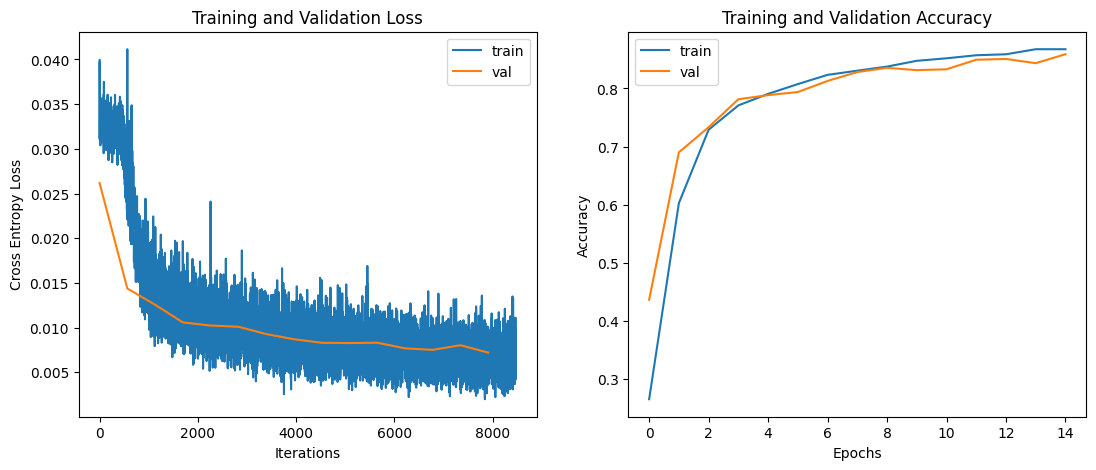

In [ ]:
plot_estop_eval(state_dict['epoch'], train_loader,
                state_dict['train_loss'],state_dict['val_loss'],
                state_dict['train_accuracy'], state_dict['val_accuracy'])

This model shows that it fits the data very well as both curves improve and follow closely. This is the best training path achieved in all of experiemnts conducted in the exercise so far.

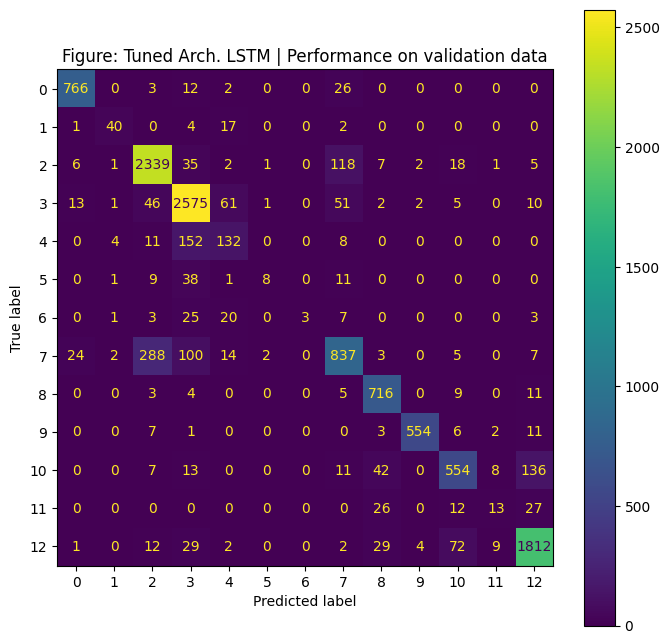

Loss: 0.4590, Accuracy: 85.91%


(0.4589659431947242, 85.90520461525692)

In [ ]:
#@title **Val Performance**
test_model(model_lstm_3, val_loader, loss_func, 'Figure: Tuned Arch. LSTM | Performance on validation data')

I choose to go with this for finetuning the training loop because even though validation accuracy is less than that obtained by basic LSTM (with 64 units and 1 hidden layer), the finetuned model (with 128 units and 1 hidden layer) gives better performance on some of classes like 1, 4 and 7 that were heavily misclassified in the baseline LSTM.

#### 3.3.3. Finetuning training loop

In [ ]:
def objective6(trial):
    params = {
        'optimizer':trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
        'batch_size': trial.suggest_categorical("batch_size", [32,64,128,256]),
        'lr': trial.suggest_float("lr",0.001,0.1,log=True),
        'epochs': trial.suggest_int("epochs", 10,80, step = 10),
        'patience': trial.suggest_int("patience", 5,20)
        }
    trial_number = trial.number
    # define the model with the given parameters, make predictions
    #input_size = num_features = 520, output_size = classes =13
    # num_layers=1, hidden_size = 128 - finetuned before
    model = LSTM(input_size=num_features_lstm, hidden_size=128, num_layers=1, output_size=num_classes)

    save_path = root + f'trial_{trial_number}' + 'best_LSTM_tuneloop.pth'
    train_loss,train_accuracy, val_loss, val_accuracy,e=mod2_train_and_validate(model, loss_func,
                                                                             splits, save_path,
                                                                             params) #loss_func, splits are global variables defined earlier
    return val_loss[-1]

In [ ]:
%%time
sampler = TPESampler(seed=123)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study6 = optuna.create_study(direction='minimize', sampler=sampler)
study6.optimize(objective6, n_trials=40)

[I 2024-01-07 09:43:24,473] A new study created in memory with name: no-name-db71164f-37d9-4eca-ab0c-d6c96a1e83e4


Epoch 1/60, Epoch validation loss: 0.0183, Train acc: 0.2002, Validation acc: 0.2104
Epoch 2/60, Epoch validation loss: 0.0186, Train acc: 0.2010, Validation acc: 0.2108
Epoch 3/60, Epoch validation loss: 0.0183, Train acc: 0.2015, Validation acc: 0.1104
Epoch 4/60, Epoch validation loss: 0.0190, Train acc: 0.2016, Validation acc: 0.2269
Epoch 5/60, Epoch validation loss: 0.0219, Train acc: 0.2054, Validation acc: 0.1642
Epoch 6/60, Epoch validation loss: 0.0178, Train acc: 0.2020, Validation acc: 0.2293
Epoch 7/60, Epoch validation loss: 0.0191, Train acc: 0.2023, Validation acc: 0.2110
Epoch 8/60, Epoch validation loss: 0.0199, Train acc: 0.2019, Validation acc: 0.1097
Epoch 9/60, Epoch validation loss: 0.0190, Train acc: 0.1991, Validation acc: 0.2106
Epoch 10/60, Epoch validation loss: 0.0185, Train acc: 0.2065, Validation acc: 0.2118
Epoch 11/60, Epoch validation loss: 0.0177, Train acc: 0.2070, Validation acc: 0.2186
Epoch 12/60, Epoch validation loss: 0.0172, Train acc: 0.2077, 

[I 2024-01-07 09:46:05,479] Trial 0 finished with value: 0.019696102831490567 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.09152261002780922, 'epochs': 60, 'patience': 12}. Best is trial 0 with value: 0.019696102831490567.


Epoch 17/60, Epoch validation loss: 0.0197, Train acc: 0.2095, Validation acc: 0.2118
Training finished.
Epoch 1/20, Epoch validation loss: 0.0456, Train acc: 0.3745, Validation acc: 0.5256
Epoch 2/20, Epoch validation loss: 0.0520, Train acc: 0.3984, Validation acc: 0.4091
Epoch 3/20, Epoch validation loss: 0.0370, Train acc: 0.5456, Validation acc: 0.6127
Epoch 4/20, Epoch validation loss: 0.0306, Train acc: 0.6458, Validation acc: 0.6844
Epoch 5/20, Epoch validation loss: 0.0289, Train acc: 0.6964, Validation acc: 0.7044
Epoch 6/20, Epoch validation loss: 0.0273, Train acc: 0.7110, Validation acc: 0.7186
Epoch 7/20, Epoch validation loss: 0.0668, Train acc: 0.3392, Validation acc: 0.2303
Epoch 8/20, Epoch validation loss: 0.0644, Train acc: 0.2501, Validation acc: 0.2830
Epoch 9/20, Epoch validation loss: 0.0655, Train acc: 0.2703, Validation acc: 0.2690
Epoch 10/20, Epoch validation loss: 0.0646, Train acc: 0.2435, Validation acc: 0.2943
Epoch 11/20, Epoch validation loss: 0.0631, 

[I 2024-01-07 09:50:26,556] Trial 1 finished with value: 0.06214717103525151 and parameters: {'optimizer': 'Adam', 'batch_size': 32, 'lr': 0.029922013287804083, 'epochs': 20, 'patience': 7}. Best is trial 0 with value: 0.019696102831490567.


Epoch 12/20, Epoch validation loss: 0.0621, Train acc: 0.2769, Validation acc: 0.3206
Training finished.
Epoch 1/30, Epoch validation loss: 0.0330, Train acc: 0.2267, Validation acc: 0.2297
Epoch 2/30, Epoch validation loss: 0.0327, Train acc: 0.2297, Validation acc: 0.2297
Epoch 3/30, Epoch validation loss: 0.0327, Train acc: 0.2296, Validation acc: 0.2297
Epoch 4/30, Epoch validation loss: 0.0327, Train acc: 0.2287, Validation acc: 0.2297
Epoch 5/30, Epoch validation loss: 0.0327, Train acc: 0.2295, Validation acc: 0.2297
Epoch 6/30, Epoch validation loss: 0.0327, Train acc: 0.2301, Validation acc: 0.2297
Epoch 7/30, Epoch validation loss: 0.0327, Train acc: 0.2300, Validation acc: 0.2312
Epoch 8/30, Epoch validation loss: 0.0327, Train acc: 0.2302, Validation acc: 0.2297
Epoch 9/30, Epoch validation loss: 0.0327, Train acc: 0.2296, Validation acc: 0.2297
Epoch 10/30, Epoch validation loss: 0.0327, Train acc: 0.2302, Validation acc: 0.2298
Epoch 11/30, Epoch validation loss: 0.0327, 

[I 2024-01-07 09:56:24,041] Trial 2 finished with value: 0.03263819678736314 and parameters: {'optimizer': 'SGD', 'batch_size': 64, 'lr': 0.02785394829873094, 'epochs': 30, 'patience': 10}. Best is trial 0 with value: 0.019696102831490567.


Epoch 28/30, Epoch validation loss: 0.0326, Train acc: 0.2307, Validation acc: 0.2300
Training finished.
Epoch 1/40, Epoch validation loss: 0.0663, Train acc: 0.2228, Validation acc: 0.2297
Epoch 2/40, Epoch validation loss: 0.0654, Train acc: 0.2295, Validation acc: 0.2297
Epoch 3/40, Epoch validation loss: 0.0653, Train acc: 0.2295, Validation acc: 0.2297
Epoch 4/40, Epoch validation loss: 0.0653, Train acc: 0.2297, Validation acc: 0.2297
Epoch 5/40, Epoch validation loss: 0.0653, Train acc: 0.2299, Validation acc: 0.2297
Epoch 6/40, Epoch validation loss: 0.0653, Train acc: 0.2297, Validation acc: 0.2297
Epoch 7/40, Epoch validation loss: 0.0653, Train acc: 0.2294, Validation acc: 0.2297
Epoch 8/40, Epoch validation loss: 0.0653, Train acc: 0.2297, Validation acc: 0.2297
Epoch 9/40, Epoch validation loss: 0.0653, Train acc: 0.2298, Validation acc: 0.2297
Epoch 10/40, Epoch validation loss: 0.0653, Train acc: 0.2299, Validation acc: 0.2297
Epoch 11/40, Epoch validation loss: 0.0653, 

[I 2024-01-07 10:08:17,256] Trial 3 finished with value: 0.06440297201136876 and parameters: {'optimizer': 'SGD', 'batch_size': 32, 'lr': 0.00971337588624665, 'epochs': 40, 'patience': 9}. Best is trial 0 with value: 0.019696102831490567.


Epoch 34/40, Epoch validation loss: 0.0644, Train acc: 0.2628, Validation acc: 0.2841
Training finished.
Epoch 1/40, Epoch validation loss: 0.0698, Train acc: 0.2128, Validation acc: 0.2297
Epoch 2/40, Epoch validation loss: 0.0667, Train acc: 0.2297, Validation acc: 0.2297
Epoch 3/40, Epoch validation loss: 0.0659, Train acc: 0.2297, Validation acc: 0.2297
Epoch 4/40, Epoch validation loss: 0.0655, Train acc: 0.2297, Validation acc: 0.2297
Epoch 5/40, Epoch validation loss: 0.0654, Train acc: 0.2297, Validation acc: 0.2297
Epoch 6/40, Epoch validation loss: 0.0654, Train acc: 0.2297, Validation acc: 0.2297
Epoch 7/40, Epoch validation loss: 0.0653, Train acc: 0.2297, Validation acc: 0.2297
Epoch 8/40, Epoch validation loss: 0.0653, Train acc: 0.2297, Validation acc: 0.2297
Epoch 9/40, Epoch validation loss: 0.0653, Train acc: 0.2297, Validation acc: 0.2297
Epoch 10/40, Epoch validation loss: 0.0653, Train acc: 0.2297, Validation acc: 0.2297
Epoch 11/40, Epoch validation loss: 0.0653, 

[I 2024-01-07 10:22:16,178] Trial 4 finished with value: 0.06522766765952093 and parameters: {'optimizer': 'SGD', 'batch_size': 32, 'lr': 0.004310929927682153, 'epochs': 40, 'patience': 18}. Best is trial 0 with value: 0.019696102831490567.


Epoch 40/40, Epoch validation loss: 0.0652, Train acc: 0.2296, Validation acc: 0.2302
Training finished.
Epoch 1/50, Epoch validation loss: 0.0653, Train acc: 0.2260, Validation acc: 0.2196
Epoch 2/50, Epoch validation loss: 0.0653, Train acc: 0.2276, Validation acc: 0.2297
Epoch 3/50, Epoch validation loss: 0.0653, Train acc: 0.2295, Validation acc: 0.2297
Epoch 4/50, Epoch validation loss: 0.0652, Train acc: 0.2311, Validation acc: 0.2320
Epoch 5/50, Epoch validation loss: 0.0651, Train acc: 0.2351, Validation acc: 0.2352
Epoch 6/50, Epoch validation loss: 0.0660, Train acc: 0.2556, Validation acc: 0.2316
Epoch 7/50, Epoch validation loss: 0.0622, Train acc: 0.2840, Validation acc: 0.3549
Epoch 8/50, Epoch validation loss: 0.0652, Train acc: 0.2932, Validation acc: 0.2297
Epoch 9/50, Epoch validation loss: 0.0632, Train acc: 0.2698, Validation acc: 0.2866
Epoch 10/50, Epoch validation loss: 0.0600, Train acc: 0.2635, Validation acc: 0.3496
Epoch 11/50, Epoch validation loss: 0.0648, 

[I 2024-01-07 10:32:24,153] Trial 5 finished with value: 0.021030662713257618 and parameters: {'optimizer': 'SGD', 'batch_size': 32, 'lr': 0.04494502237965996, 'epochs': 50, 'patience': 13}. Best is trial 0 with value: 0.019696102831490567.


Epoch 29/50, Epoch validation loss: 0.0210, Train acc: 0.7910, Validation acc: 0.7817
Training finished.
Epoch 1/50, Epoch validation loss: 0.0163, Train acc: 0.2320, Validation acc: 0.2618
Epoch 2/50, Epoch validation loss: 0.0133, Train acc: 0.3710, Validation acc: 0.4314
Epoch 3/50, Epoch validation loss: 0.0099, Train acc: 0.5002, Validation acc: 0.5754
Epoch 4/50, Epoch validation loss: 0.0082, Train acc: 0.6134, Validation acc: 0.6601
Epoch 5/50, Epoch validation loss: 0.0070, Train acc: 0.6842, Validation acc: 0.7100
Epoch 6/50, Epoch validation loss: 0.0063, Train acc: 0.7153, Validation acc: 0.7330
Epoch 7/50, Epoch validation loss: 0.0059, Train acc: 0.7444, Validation acc: 0.7549
Epoch 8/50, Epoch validation loss: 0.0057, Train acc: 0.7630, Validation acc: 0.7611
Epoch 9/50, Epoch validation loss: 0.0055, Train acc: 0.7760, Validation acc: 0.7772
Epoch 10/50, Epoch validation loss: 0.0052, Train acc: 0.7901, Validation acc: 0.7900
Epoch 11/50, Epoch validation loss: 0.0055, 

[I 2024-01-07 10:37:45,122] Trial 6 finished with value: 0.0036177450123248403 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.021808588898416352, 'epochs': 50, 'patience': 14}. Best is trial 6 with value: 0.0036177450123248403.


Epoch 34/50, Epoch validation loss: 0.0036, Train acc: 0.8771, Validation acc: 0.8585
Training finished.
Epoch 1/10, Epoch validation loss: 0.0338, Train acc: 0.2155, Validation acc: 0.2297
Epoch 2/10, Epoch validation loss: 0.0329, Train acc: 0.2297, Validation acc: 0.2297
Epoch 3/10, Epoch validation loss: 0.0328, Train acc: 0.2298, Validation acc: 0.2297
Epoch 4/10, Epoch validation loss: 0.0327, Train acc: 0.2297, Validation acc: 0.2297
Epoch 5/10, Epoch validation loss: 0.0327, Train acc: 0.2297, Validation acc: 0.2297
Epoch 6/10, Epoch validation loss: 0.0327, Train acc: 0.2297, Validation acc: 0.2297
Epoch 7/10, Epoch validation loss: 0.0327, Train acc: 0.2297, Validation acc: 0.2297
Epoch 8/10, Epoch validation loss: 0.0327, Train acc: 0.2297, Validation acc: 0.2297
Epoch 9/10, Epoch validation loss: 0.0327, Train acc: 0.2297, Validation acc: 0.2297


[I 2024-01-07 10:39:52,227] Trial 7 finished with value: 0.03271664958657871 and parameters: {'optimizer': 'SGD', 'batch_size': 64, 'lr': 0.013960916030347565, 'epochs': 10, 'patience': 19}. Best is trial 6 with value: 0.0036177450123248403.


Epoch 10/10, Epoch validation loss: 0.0327, Train acc: 0.2293, Validation acc: 0.2297
Training finished.
Epoch 1/60, Epoch validation loss: 0.0385, Train acc: 0.2297, Validation acc: 0.2297
Epoch 2/60, Epoch validation loss: 0.0371, Train acc: 0.2297, Validation acc: 0.2297
Epoch 3/60, Epoch validation loss: 0.0361, Train acc: 0.2297, Validation acc: 0.2297
Epoch 4/60, Epoch validation loss: 0.0352, Train acc: 0.2297, Validation acc: 0.2297
Epoch 5/60, Epoch validation loss: 0.0345, Train acc: 0.2297, Validation acc: 0.2297
Epoch 6/60, Epoch validation loss: 0.0341, Train acc: 0.2297, Validation acc: 0.2297
Epoch 7/60, Epoch validation loss: 0.0337, Train acc: 0.2297, Validation acc: 0.2297
Epoch 8/60, Epoch validation loss: 0.0335, Train acc: 0.2297, Validation acc: 0.2297
Epoch 9/60, Epoch validation loss: 0.0333, Train acc: 0.2297, Validation acc: 0.2297
Epoch 10/60, Epoch validation loss: 0.0332, Train acc: 0.2297, Validation acc: 0.2297
Epoch 11/60, Epoch validation loss: 0.0331, 

[I 2024-01-07 10:52:35,449] Trial 8 finished with value: 0.032713303643508836 and parameters: {'optimizer': 'SGD', 'batch_size': 64, 'lr': 0.0020236762287697604, 'epochs': 60, 'patience': 10}. Best is trial 6 with value: 0.0036177450123248403.


Epoch 60/60, Epoch validation loss: 0.0327, Train acc: 0.2297, Validation acc: 0.2297
Training finished.
Epoch 1/30, Epoch validation loss: 0.0327, Train acc: 0.2306, Validation acc: 0.2297
Epoch 2/30, Epoch validation loss: 0.0327, Train acc: 0.2498, Validation acc: 0.2297
Epoch 3/30, Epoch validation loss: 0.0318, Train acc: 0.2555, Validation acc: 0.2860
Epoch 4/30, Epoch validation loss: 0.0276, Train acc: 0.3702, Validation acc: 0.4426
Epoch 5/30, Epoch validation loss: 0.0190, Train acc: 0.5111, Validation acc: 0.6070
Epoch 6/30, Epoch validation loss: 0.0140, Train acc: 0.6575, Validation acc: 0.7106
Epoch 7/30, Epoch validation loss: 0.0134, Train acc: 0.7140, Validation acc: 0.7213
Epoch 8/30, Epoch validation loss: 0.0123, Train acc: 0.7384, Validation acc: 0.7379
Epoch 9/30, Epoch validation loss: 0.0112, Train acc: 0.7498, Validation acc: 0.7673
Epoch 10/30, Epoch validation loss: 0.0118, Train acc: 0.7623, Validation acc: 0.7514
Epoch 11/30, Epoch validation loss: 0.0111, 

[I 2024-01-07 10:59:10,459] Trial 9 finished with value: 0.007651556167233573 and parameters: {'optimizer': 'Adam', 'batch_size': 64, 'lr': 0.0012223143983508043, 'epochs': 30, 'patience': 11}. Best is trial 6 with value: 0.0036177450123248403.


Epoch 30/30, Epoch validation loss: 0.0077, Train acc: 0.8658, Validation acc: 0.8487
Training finished.
Epoch 1/80, Epoch validation loss: 0.0163, Train acc: 0.2298, Validation acc: 0.2298
Epoch 2/80, Epoch validation loss: 0.0142, Train acc: 0.3134, Validation acc: 0.4041
Epoch 3/80, Epoch validation loss: 0.0075, Train acc: 0.5782, Validation acc: 0.6832
Epoch 4/80, Epoch validation loss: 0.0070, Train acc: 0.7149, Validation acc: 0.7029
Epoch 5/80, Epoch validation loss: 0.0056, Train acc: 0.7559, Validation acc: 0.7677
Epoch 6/80, Epoch validation loss: 0.0051, Train acc: 0.7810, Validation acc: 0.7877
Epoch 7/80, Epoch validation loss: 0.0050, Train acc: 0.8006, Validation acc: 0.7997
Epoch 8/80, Epoch validation loss: 0.0045, Train acc: 0.8142, Validation acc: 0.8209
Epoch 9/80, Epoch validation loss: 0.0044, Train acc: 0.8258, Validation acc: 0.8218
Epoch 10/80, Epoch validation loss: 0.0043, Train acc: 0.8303, Validation acc: 0.8292
Epoch 11/80, Epoch validation loss: 0.0042, 

[I 2024-01-07 11:04:01,833] Trial 10 finished with value: 0.003816029425097252 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.0071138137416176484, 'epochs': 80, 'patience': 15}. Best is trial 6 with value: 0.0036177450123248403.


Epoch 31/80, Epoch validation loss: 0.0038, Train acc: 0.9001, Validation acc: 0.8595
Training finished.
Epoch 1/80, Epoch validation loss: 0.0163, Train acc: 0.2308, Validation acc: 0.2552
Epoch 2/80, Epoch validation loss: 0.0130, Train acc: 0.3741, Validation acc: 0.4587
Epoch 3/80, Epoch validation loss: 0.0157, Train acc: 0.3139, Validation acc: 0.3036
Epoch 4/80, Epoch validation loss: 0.0134, Train acc: 0.3853, Validation acc: 0.4374
Epoch 5/80, Epoch validation loss: 0.0100, Train acc: 0.4686, Validation acc: 0.5958
Epoch 6/80, Epoch validation loss: 0.0078, Train acc: 0.6396, Validation acc: 0.6651
Epoch 7/80, Epoch validation loss: 0.0065, Train acc: 0.7068, Validation acc: 0.7313
Epoch 8/80, Epoch validation loss: 0.0060, Train acc: 0.7429, Validation acc: 0.7551
Epoch 9/80, Epoch validation loss: 0.0056, Train acc: 0.7628, Validation acc: 0.7653
Epoch 10/80, Epoch validation loss: 0.0054, Train acc: 0.7732, Validation acc: 0.7725
Epoch 11/80, Epoch validation loss: 0.0051, 

[I 2024-01-07 11:09:40,398] Trial 11 finished with value: 0.00412976425362042 and parameters: {'optimizer': 'Adam', 'batch_size': 128, 'lr': 0.008220970626739807, 'epochs': 80, 'patience': 15}. Best is trial 6 with value: 0.0036177450123248403.


Epoch 36/80, Epoch validation loss: 0.0041, Train acc: 0.8808, Validation acc: 0.8458
Training finished.
Epoch 1/80, Epoch validation loss: 0.0083, Train acc: 0.2248, Validation acc: 0.2297
Epoch 2/80, Epoch validation loss: 0.0076, Train acc: 0.2649, Validation acc: 0.3413
Epoch 3/80, Epoch validation loss: 0.0070, Train acc: 0.3720, Validation acc: 0.3619
Epoch 4/80, Epoch validation loss: 0.0045, Train acc: 0.5258, Validation acc: 0.6202
Epoch 5/80, Epoch validation loss: 0.0040, Train acc: 0.6568, Validation acc: 0.6722
Epoch 6/80, Epoch validation loss: 0.0034, Train acc: 0.7118, Validation acc: 0.7128
Epoch 7/80, Epoch validation loss: 0.0033, Train acc: 0.7380, Validation acc: 0.7324
Epoch 8/80, Epoch validation loss: 0.0031, Train acc: 0.7572, Validation acc: 0.7413
Epoch 9/80, Epoch validation loss: 0.0029, Train acc: 0.7740, Validation acc: 0.7677
Epoch 10/80, Epoch validation loss: 0.0029, Train acc: 0.7834, Validation acc: 0.7586
Epoch 11/80, Epoch validation loss: 0.0025, 

[I 2024-01-07 11:15:05,623] Trial 12 finished with value: 0.001835440071613383 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.004237009662451938, 'epochs': 80, 'patience': 16}. Best is trial 12 with value: 0.001835440071613383.


Epoch 36/80, Epoch validation loss: 0.0018, Train acc: 0.8943, Validation acc: 0.8615
Training finished.
Epoch 1/70, Epoch validation loss: 0.0083, Train acc: 0.2258, Validation acc: 0.2104
Epoch 2/70, Epoch validation loss: 0.0081, Train acc: 0.2437, Validation acc: 0.2800
Epoch 3/70, Epoch validation loss: 0.0081, Train acc: 0.3183, Validation acc: 0.3442
Epoch 4/70, Epoch validation loss: 0.0067, Train acc: 0.3629, Validation acc: 0.4428
Epoch 5/70, Epoch validation loss: 0.0059, Train acc: 0.4738, Validation acc: 0.5073
Epoch 6/70, Epoch validation loss: 0.0056, Train acc: 0.5315, Validation acc: 0.5463
Epoch 7/70, Epoch validation loss: 0.0038, Train acc: 0.6318, Validation acc: 0.6887
Epoch 8/70, Epoch validation loss: 0.0036, Train acc: 0.7041, Validation acc: 0.7054
Epoch 9/70, Epoch validation loss: 0.0034, Train acc: 0.7215, Validation acc: 0.7174
Epoch 10/70, Epoch validation loss: 0.0030, Train acc: 0.7366, Validation acc: 0.7452
Epoch 11/70, Epoch validation loss: 0.0030, 

[I 2024-01-07 11:21:43,031] Trial 13 finished with value: 0.0019594499062505 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0031269712885472803, 'epochs': 70, 'patience': 16}. Best is trial 12 with value: 0.001835440071613383.


Epoch 44/70, Epoch validation loss: 0.0020, Train acc: 0.8937, Validation acc: 0.8537
Training finished.
Epoch 1/70, Epoch validation loss: 0.0083, Train acc: 0.2212, Validation acc: 0.2104
Epoch 2/70, Epoch validation loss: 0.0083, Train acc: 0.2368, Validation acc: 0.2471
Epoch 3/70, Epoch validation loss: 0.0077, Train acc: 0.2783, Validation acc: 0.3398
Epoch 4/70, Epoch validation loss: 0.0071, Train acc: 0.3903, Validation acc: 0.4110
Epoch 5/70, Epoch validation loss: 0.0053, Train acc: 0.5191, Validation acc: 0.5756
Epoch 6/70, Epoch validation loss: 0.0039, Train acc: 0.6280, Validation acc: 0.6764
Epoch 7/70, Epoch validation loss: 0.0034, Train acc: 0.7168, Validation acc: 0.7167
Epoch 8/70, Epoch validation loss: 0.0032, Train acc: 0.7420, Validation acc: 0.7293
Epoch 9/70, Epoch validation loss: 0.0031, Train acc: 0.7557, Validation acc: 0.7471
Epoch 10/70, Epoch validation loss: 0.0028, Train acc: 0.7706, Validation acc: 0.7683
Epoch 11/70, Epoch validation loss: 0.0027, 

[I 2024-01-07 11:28:12,850] Trial 14 finished with value: 0.0018214308623091052 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0034065952040606955, 'epochs': 70, 'patience': 17}. Best is trial 14 with value: 0.0018214308623091052.


Epoch 43/70, Epoch validation loss: 0.0018, Train acc: 0.8985, Validation acc: 0.8635
Training finished.
Epoch 1/70, Epoch validation loss: 0.0083, Train acc: 0.2213, Validation acc: 0.2294
Epoch 2/70, Epoch validation loss: 0.0083, Train acc: 0.2436, Validation acc: 0.2375
Epoch 3/70, Epoch validation loss: 0.0082, Train acc: 0.2495, Validation acc: 0.2331
Epoch 4/70, Epoch validation loss: 0.0078, Train acc: 0.2810, Validation acc: 0.3071
Epoch 5/70, Epoch validation loss: 0.0069, Train acc: 0.3750, Validation acc: 0.4138
Epoch 6/70, Epoch validation loss: 0.0062, Train acc: 0.4521, Validation acc: 0.4799
Epoch 7/70, Epoch validation loss: 0.0046, Train acc: 0.5686, Validation acc: 0.6186
Epoch 8/70, Epoch validation loss: 0.0041, Train acc: 0.6581, Validation acc: 0.6728
Epoch 9/70, Epoch validation loss: 0.0034, Train acc: 0.7092, Validation acc: 0.7236
Epoch 10/70, Epoch validation loss: 0.0037, Train acc: 0.7354, Validation acc: 0.6841
Epoch 11/70, Epoch validation loss: 0.0031, 

[I 2024-01-07 11:34:14,798] Trial 15 finished with value: 0.002240452205126767 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.003494169166890002, 'epochs': 70, 'patience': 18}. Best is trial 14 with value: 0.0018214308623091052.


Epoch 40/70, Epoch validation loss: 0.0022, Train acc: 0.8612, Validation acc: 0.8281
Training finished.
Epoch 1/70, Epoch validation loss: 0.0083, Train acc: 0.2199, Validation acc: 0.2298
Epoch 2/70, Epoch validation loss: 0.0083, Train acc: 0.2351, Validation acc: 0.2296
Epoch 3/70, Epoch validation loss: 0.0083, Train acc: 0.2695, Validation acc: 0.2298
Epoch 4/70, Epoch validation loss: 0.0083, Train acc: 0.2515, Validation acc: 0.2308
Epoch 5/70, Epoch validation loss: 0.0083, Train acc: 0.2749, Validation acc: 0.2104
Epoch 6/70, Epoch validation loss: 0.0083, Train acc: 0.2377, Validation acc: 0.2201
Epoch 7/70, Epoch validation loss: 0.0083, Train acc: 0.2955, Validation acc: 0.2103
Epoch 8/70, Epoch validation loss: 0.0082, Train acc: 0.2635, Validation acc: 0.2112
Epoch 9/70, Epoch validation loss: 0.0070, Train acc: 0.2685, Validation acc: 0.4065
Epoch 10/70, Epoch validation loss: 0.0084, Train acc: 0.3003, Validation acc: 0.2474
Epoch 11/70, Epoch validation loss: 0.0064, 

[I 2024-01-07 11:40:42,049] Trial 16 finished with value: 0.0022548901736142795 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.001789413025950541, 'epochs': 70, 'patience': 20}. Best is trial 14 with value: 0.0018214308623091052.


Epoch 43/70, Epoch validation loss: 0.0023, Train acc: 0.8384, Validation acc: 0.8169
Training finished.
Epoch 1/80, Epoch validation loss: 0.0083, Train acc: 0.2246, Validation acc: 0.2104
Epoch 2/80, Epoch validation loss: 0.0081, Train acc: 0.2441, Validation acc: 0.2651
Epoch 3/80, Epoch validation loss: 0.0065, Train acc: 0.3609, Validation acc: 0.4177
Epoch 4/80, Epoch validation loss: 0.0045, Train acc: 0.5479, Validation acc: 0.6207
Epoch 5/80, Epoch validation loss: 0.0036, Train acc: 0.6723, Validation acc: 0.7003
Epoch 6/80, Epoch validation loss: 0.0034, Train acc: 0.7076, Validation acc: 0.7184
Epoch 7/80, Epoch validation loss: 0.0033, Train acc: 0.7355, Validation acc: 0.7332
Epoch 8/80, Epoch validation loss: 0.0030, Train acc: 0.7543, Validation acc: 0.7410
Epoch 9/80, Epoch validation loss: 0.0028, Train acc: 0.7722, Validation acc: 0.7684
Epoch 10/80, Epoch validation loss: 0.0026, Train acc: 0.7855, Validation acc: 0.7935
Epoch 11/80, Epoch validation loss: 0.0026, 

[I 2024-01-07 11:46:32,776] Trial 17 finished with value: 0.002117684577688891 and parameters: {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0052971119649818784, 'epochs': 80, 'patience': 17}. Best is trial 14 with value: 0.0018214308623091052.


Epoch 39/80, Epoch validation loss: 0.0021, Train acc: 0.9064, Validation acc: 0.8535
Training finished.
Epoch 1/60, Epoch validation loss: 0.0083, Train acc: 0.2247, Validation acc: 0.2328
Epoch 2/60, Epoch validation loss: 0.0082, Train acc: 0.2342, Validation acc: 0.2433
Epoch 3/60, Epoch validation loss: 0.0077, Train acc: 0.2722, Validation acc: 0.3363
Epoch 4/60, Epoch validation loss: 0.0069, Train acc: 0.3793, Validation acc: 0.4485
Epoch 5/60, Epoch validation loss: 0.0064, Train acc: 0.4736, Validation acc: 0.4503
Epoch 6/60, Epoch validation loss: 0.0063, Train acc: 0.4593, Validation acc: 0.4878
Epoch 7/60, Epoch validation loss: 0.0044, Train acc: 0.5511, Validation acc: 0.6307
Epoch 8/60, Epoch validation loss: 0.0036, Train acc: 0.6698, Validation acc: 0.7035
Epoch 9/60, Epoch validation loss: 0.0035, Train acc: 0.7127, Validation acc: 0.7086
Epoch 10/60, Epoch validation loss: 0.0031, Train acc: 0.7340, Validation acc: 0.7455
Epoch 11/60, Epoch validation loss: 0.0030, 

In [ ]:
# # # for loading the study later
# save_study_ = root + 'optuna_study_best_LSTM_tunedloop.pkl'
# #joblib.dump(study6, save_study_)
study_6 = joblib.load(save_study_)
# study_6.best_trial, study_6.best_params

While running the above study, I exhausted the free compute units allotted by google and so session timed out. However, I made a note of the parameters of the trial found as the best trial before the session timeout. This was trial 14. Since my workflow saves the best epoch model corresponding to every trial, I was able to load it and use it after.

In [ ]:
# manual retrieval of best params based on log due to exhaustion of compute units
best_trial = 14
best_params= {'optimizer': 'Adam', 'batch_size': 256, 'lr': 0.0034065952040606955,
                        'epochs': 70, 'patience': 17}

In [ ]:
# reconstruct path of the best trial
# best trial - 14
path = root + 'trial_' + f'{best_trial}' + 'best_LSTM_tuneloop.pth'

model_lstm_4 = LSTM(input_size=num_features_lstm,output_size=num_classes, num_layers=1, hidden_size=128)
state_dict = torch.load(path)
model_lstm_4.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

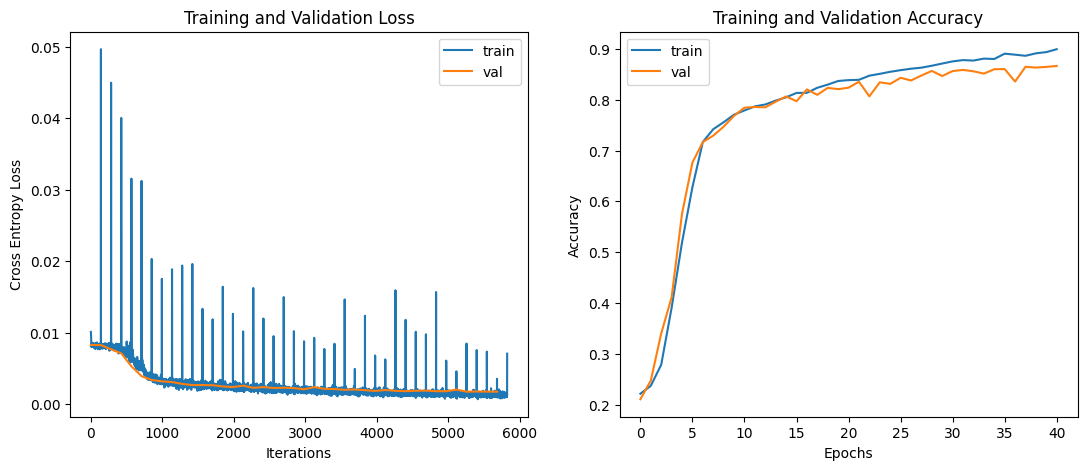

In [ ]:
# retrieve the optimal batch size and reload the corresponding data batches for plotting and testing
train_loader_tuned, val_loader_tuned, test_loader_tuned= generate_loaders(splits[0], splits[1], splits[2], batch_size=256)
plot_estop_eval(state_dict['epoch'],train_loader_tuned,
                state_dict['train_loss'],state_dict['val_loss'],
                state_dict['train_accuracy'], state_dict['val_accuracy'])

The close movement of train and validation accuracy and their improvement shows that the model is learning really well, however towards the end we can see that the model slows down learning.

In [ ]:
print(f"Optimizer suggested upon Bayesian finetuning: {best_params['optimizer']}")
print(f"Batch size suggested upon Bayesian finetuning: {best_params['batch_size']}")
print(f"Learning rate suggested upon Bayesian finetuning: {best_params['lr']:.4f}")
print(f"Number of epochs suggested upon Bayesian finetuning: {best_params['epochs']:.4f}")
print(f"Patience value suggested upon Bayesian finetuning: {best_params['patience']:.4f}")

print(f"\nBest validation epoch loss obtained by the finetuned model: {state_dict['e_loss']:.4f}")

Optimizer suggested upon Bayesian finetuning: Adam
Batch size suggested upon Bayesian finetuning: 256
Learning rate suggested upon Bayesian finetuning: 0.0034
Number of epochs suggested upon Bayesian finetuning: 70.0000
Patience value suggested upon Bayesian finetuning: 17.0000

Best validation epoch loss obtained by the finetuned model: 0.0018


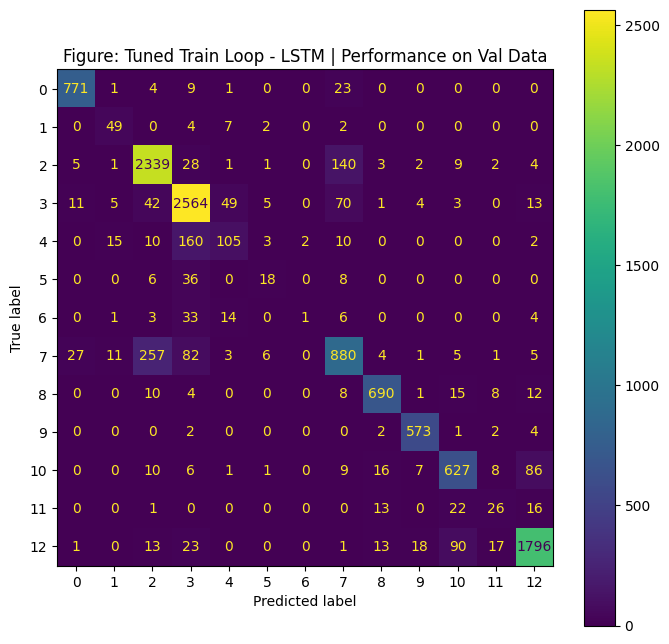

Loss: 0.4412, Accuracy: 86.65%


(0.4411907030554662, 86.65227857557898)

In [ ]:
#@title **Val Performance**
test_model(model_lstm_4, val_loader_tuned, loss_func, 'Figure: Tuned Train Loop - LSTM | Performance on Val Data')

The model achieved an 86.7% accuracy after tuning the training loop. Our Baseline LSTM gave 87% accuracy. The misclassifications persist in this model too.

## 4. Test Performance

The figures below are the test performances of all the models trained over the 8 experiments in the notebook. They are discussed in combination with the tables, towards the end of the section.

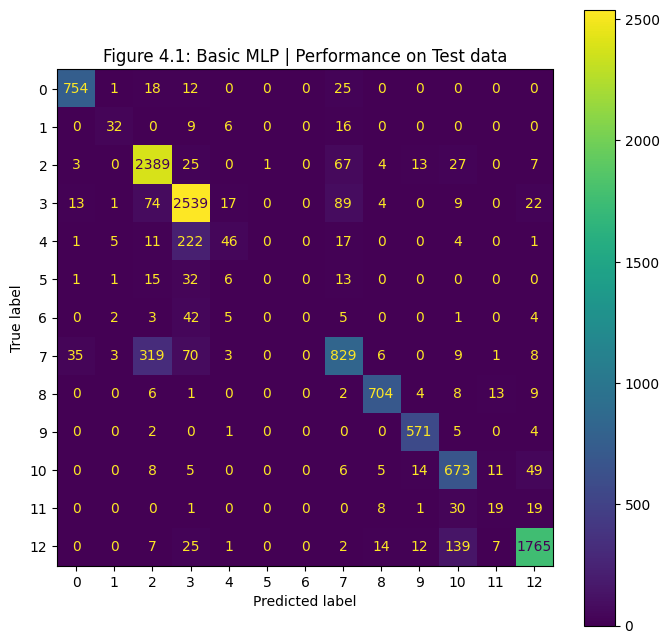

Loss: 0.4870, Accuracy: 85.67%


(0.48695267275476745, 85.6656706507304)

In [ ]:
# Baseline MLP
test_model(model_1, test_loader, loss_func, 'Figure 4.1: Basic MLP | Performance on Test data')

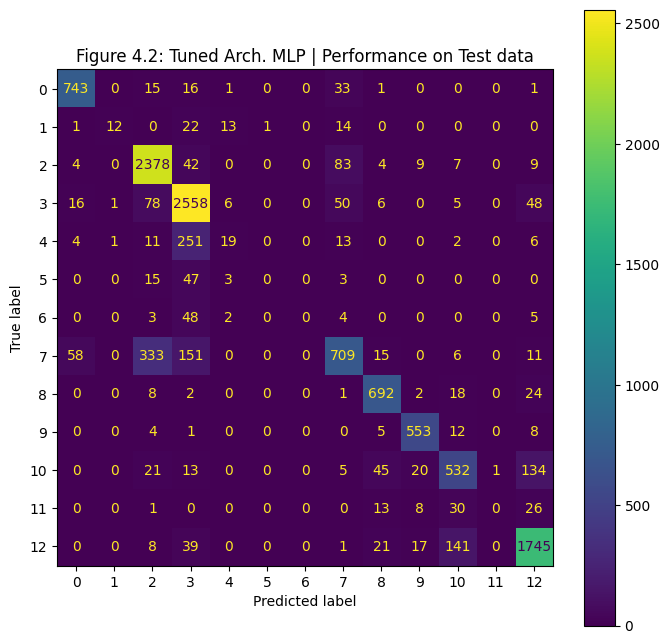

Loss: 0.5844, Accuracy: 82.51%


(0.5844203927066918, 82.51162018592298)

In [ ]:
# MLP - after tuning architecture
test_model(model_2, test_loader, loss_func, 'Figure 4.2: Tuned Arch. MLP | Performance on Test data')

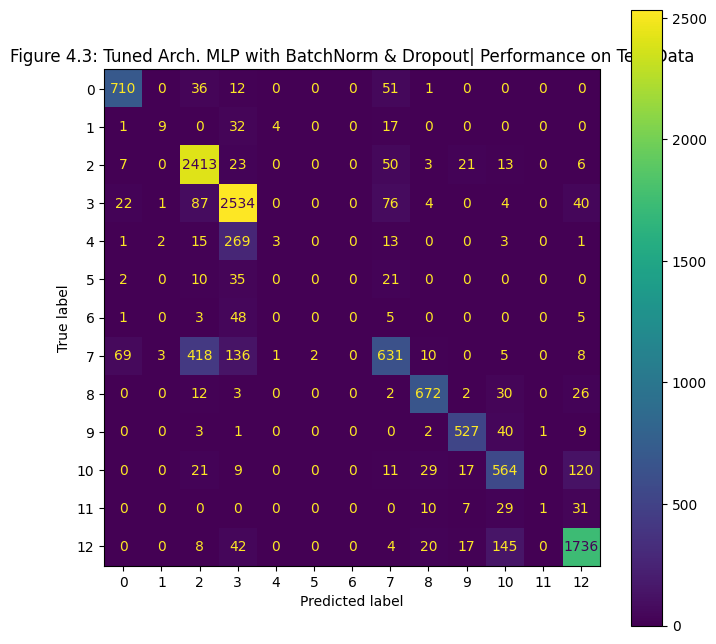

Loss: 0.6170, Accuracy: 81.34%


(0.6169589780098583, 81.34130146082337)

In [ ]:
# MLP - after batch Normalisation and dropout
# note- these techniques are applied on the baseline MLP because tuned architecture didn't give val acc
test_model(model_3, test_loader,loss_func, 'Figure 4.3: Tuned Arch. MLP with BatchNorm & Dropout| Performance on Test Data')

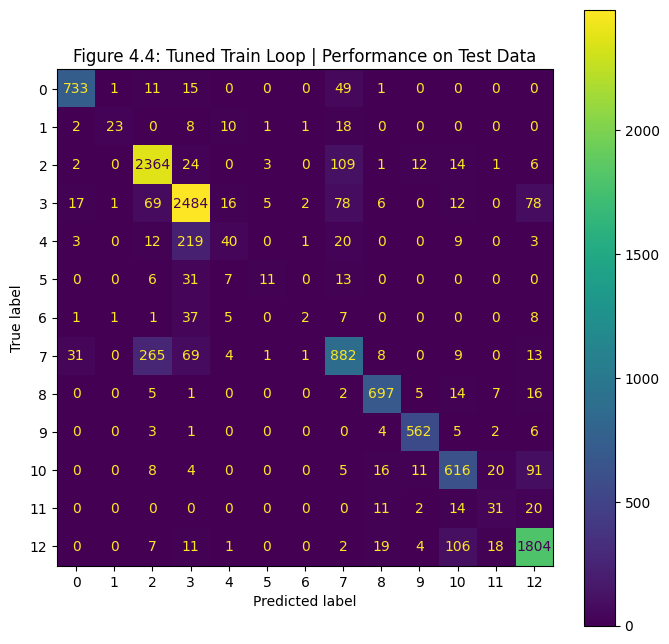

Loss: 0.4814, Accuracy: 85.07%


(0.4814323375765715, 85.06806108897742)

In [ ]:
# MLP - after finetuning training loop: (lr, batch_size, optimiser, epochs and patience)
test_model(model_4, test_loader_tuned, loss_func,'Figure 4.4: Tuned Train Loop | Performance on Test Data')

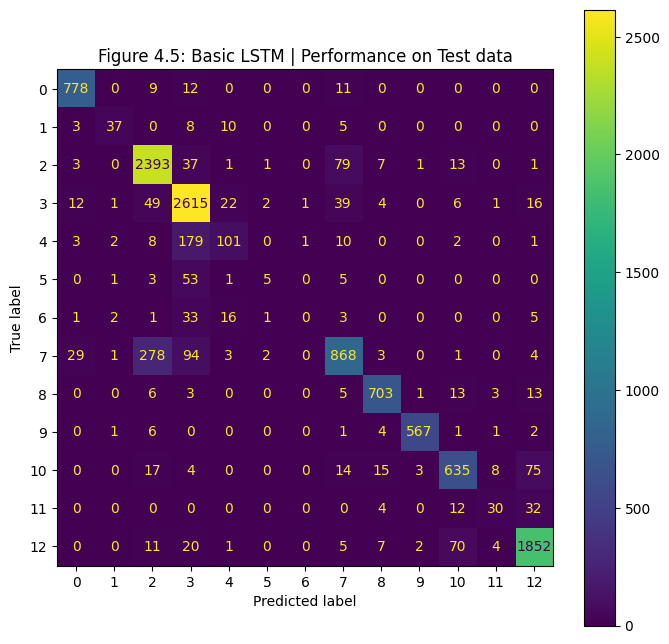

Loss: 0.4091, Accuracy: 87.85%


(0.40907356992043187, 87.84860557768924)

In [ ]:
# Baseline LSTM
test_model(model_lstm_1, test_loader, loss_func, 'Figure 4.5: Basic LSTM | Performance on Test data')

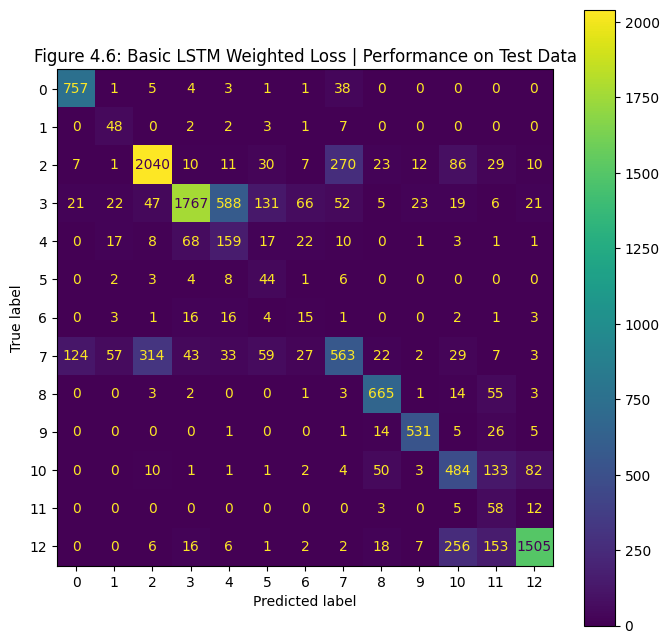

Loss: 0.8274, Accuracy: 71.68%


(0.8274442043169277, 71.67994687915007)

In [ ]:
# LSTM - with weighted loss
test_model(model_lstm_2,test_loader, loss_func, 'Figure 4.6: Basic LSTM Weighted Loss | Performance on Test Data')

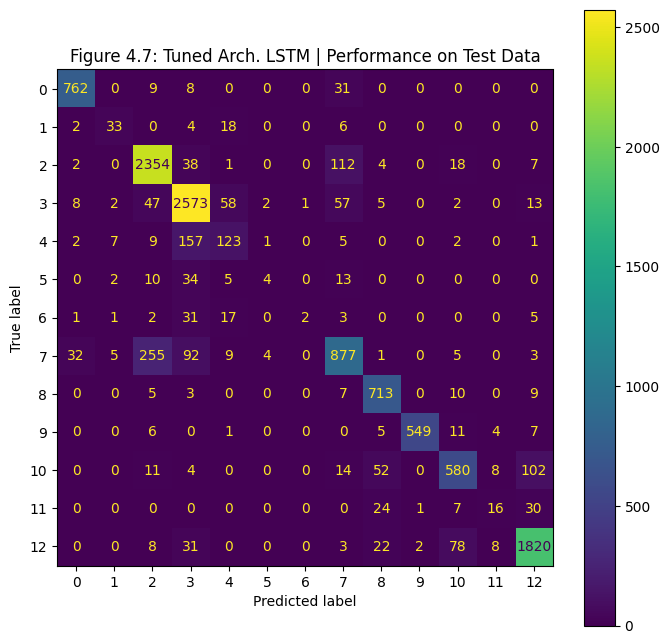

Loss: 0.4438, Accuracy: 86.37%


(0.443811768357494, 86.37118193891102)

In [ ]:
# LSTM - after finetuning architecture
test_model(model_lstm_3, test_loader, loss_func, 'Figure 4.7: Tuned Arch. LSTM | Performance on Test Data')

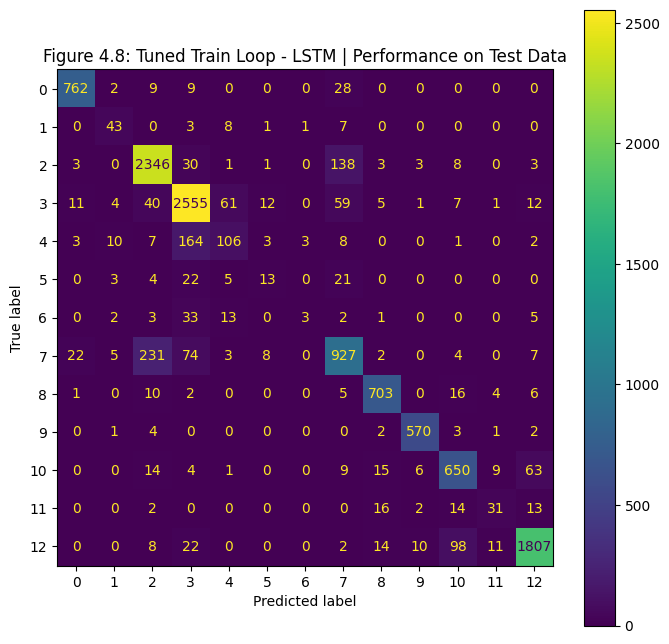

Loss: 0.4178, Accuracy: 87.28%


(0.41776313795201386, 87.28419654714476)

In [ ]:
# LSTM - after finetuning training loop with the tuned architecture
test_model(model_lstm_4, test_loader_tuned, loss_func, 'Figure 4.8: Tuned Train Loop - LSTM | Performance on Test Data')

**Table 1: Test loss and accuracy of each model**

| Model | Validation Loss | Validation Accuracy | Test Accuracy |
|-----|-------|----|--|
| MLP-1 (Baseline) | 0.51 | 85.29%|85.67% |
| MLP-2 (Tuned Architecture)| 0.60 | 81.90% | 82.51%|
| MLP-3 (BatchNorm & Dropout) | 0.63 |80.91 |81.34% |
| MLP-4 (Tuned Train Loop) | 0.48 | 85.33%| 85.07%|
| LSTM-1 (Baseline) | 0.43 | 87.00%| 87.85%|
| LSTM-2 (Weighted Class Loss) |0.83|71.47% | 71.68%|
| LSTM-3 (Finetuning Architecture) |0.46 | 85.91%| 86.37%|
| LSTM-4 (Tuned Train Loop) | 0.44| 86.65% | 87.28

The table above and the figures show that the highest accuracy is achieved by the LSTM - Baseline architecture with one hidden layer and 64 hidden units. However, in confusion matrices we see that minority class performance improves when weighted class loss is used.

The table below further corroborates that  - while LSTM models generally perform well on  most classes, LSTM -2 shows the best result consistently for all minority classes.

This is a great piece of information for future experiments while working with class-imbalanced datasets.



**Table 2: Best performing model for each class (descending order of class distribution in the sample)**

| Class Index | Percentage Distribution | Best Performing Model | MLP-1 (Baseline) | MLP-2 (Tuned Architecture) | MLP-3 (BatchNorm & Dropout) | MLP-4 (Tuned Train Loop) | LSTM-1 (Baseline) | LSTM-2 (Weighted Class Loss) | LSTM-3 (Finetuning Architecture) | LSTM-4 (Tuned Train Loop) |
|-------------|-------------------------|-----------------------|------------------|-----------------------------|-------------------------------|-------------------------|------------------|-----------------------------|--------------------------------|---------------------------|
| 3           | 22.97%                  |  LSTM-1 (Baseline)              | 2539             | 2558                        | 2534                          | 2484                    | 2615             | 1767                        | 2573                            | 2555                     |
| 2           | 21.04%                  |MLP-3 (BatchNorm & Dropout)                | 2389             | 2378                        | 2413                          | 2364                    | 2393             | 2040                        | 2354                           | 2346                     |
| 12          | 16.36%                  |  LSTM-1 (Baseline)               | 1765             | 1745                        | 1736                          | 1804                    | 1852             | 1505                        | 1820                           | 1807                     |
| 7           | 10.64%                  | LSTM-4 (Tuned Train Loop)              | 829              | 709                         | 631                           | 882                     | 868              | 563                         | 877                            | 927                      |
| 8           | 6.20%                   |LSTM-3 (Finetuning Architecture)              | 704              | 692                         | 672                           | 697                     | 703              | 665                         | 713                            | 703                      |
| 10          | 6.40%                   | MLP-1 (Baseline)              | 673              | 532                         | 564                           | 616                     | 635              | 484                         | 580                            | 650                      |
| 0           | 6.72%                   |  LSTM-1 (Baseline)               | 754              | 743                         | 710                           | 733                     | 778              | 757                         | 762                            | 762                       |
| 9           | 4.80%                   | MLP-1 (Baseline)       | 571              | 553                         | 527                           | 562                     | 567              | 531                         | 549                            | 570                      |
| 4           | 2.54%                   | LSTM-2 (Weighted Class Loss)               | 46               | 19                          | 3                             | 40                      | 101              | 159                         | 123                            | 106                      |
| 1           | 0.53%                   | LSTM-2 (Weighted Class Loss)              | 32               | 12                          | 9                             | 23                      | 37               | 48                          | 33                             | 43                        |
| 11          | 0.65%                   | LSTM-2 (Weighted Class Loss)               | 19               | 0                           | 1                             | 31                      | 30               | 58                          | 16                             | 31                       |
| 5           | 0.56%                   | LSTM-2 (Weighted Class Loss)              | 0                | 0                           | 0                             | 11                      | 5                | 44                          | 4                              | 13                       |
| 6           | 0.52%                   | LSTM-2 (Weighted Class Loss)               | 0                | 0                           | 0                             | 2                       | 0                | 15                          | 2                              | 3                        |


## 5. Conclusion


* The best model in terms of highest accuracy achieved is the LSTM-Baseline (87.85%) with one hidden layer and 6 units. That is the recommended architecture from this set of experiments. However, if minority class classification is to be prioritised, it might be useful to further looking into tuning the models using weighted class loss.

* The best training path is shown by the LSTM 4 - with finetuned architecture model (accuracy - 86.37%) as both training and validation curves improve together and relatively smoothly compared to the rest of the training paths observed in the rest of the 7 experiments.

* The models do not overfit in almost any of the experiments, so batch normalisation and dropout might not be necessary or relevant for this task

* Finetuning the training loop and implementing early stopping improves the result, however the baselines (MLP-85.29%, LSTM-87.85%) prove to be the best performing. This might need me to revisit my experiments and see if there's some way I can improve the performance.

* **For future experiments**:

  * Useful to look into other loss functions that allow class weighted losses. F1 score might also be a useful metric to look at as it also weights based on class.
  * **Merging** the minority classes and treating them all as a single class might be a useful way to handle the class imbalance problem. However, this depends upon the implementation scenario of the models as well - for eg, if a minority's class prediction is more relevant than the grouped/merged class prediction.
  * Using different learning rates for different classes during the training process. Allowing minority classes to train for longer.

## 7. References

Resources shared by Prof Charlotte Pelletier, Prof Nicolas Courty during the practice lab sessions

Adjust size of ConfusionMatrixDisplay (ScikitLearn). (n.d.). Stack Overflow. https://stackoverflow.com/questions/66483409/adjust-size-of-confusionmatrixdisplay-scikitlearn

Azman, S. K. (2021, December 10). Building efficient custom datasets in PyTorch - towards data science. Medium. https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f

Brownlee, J. (2019, August 6). How to use Learning Curves to Diagnose Machine Learning Model Performance. MachineLearningMastery.com. https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

Custom dataset for time-series data for an LSTM model. (2021, October 14). PyTorch Forums. https://discuss.pytorch.org/t/custom-dataset-for-time-series-data-for-an-lstm-model/134275

Datasets & DataLoaders — PyTorch Tutorials 2.2.0+cu121 documentation. (n.d.). https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

Kezmann, J. M. (2023, April 18). All 8 types of Time Series Classification Methods - MLearning.ai - medium. Medium. https://medium.com/mlearning-ai/all-8-types-of-time-series-classification-methods-2c8e4b323ea2#2fe7

optuna.samplers.TPESampler — Optuna 3.5.0 documentation. (n.d.). https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html

optuna.study.Study — Optuna 3.5.0 documentation. (n.d.). https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html
ptrblck. (n.d.). PyTorch Forums. https://discuss.pytorch.org/u/ptrblck/summary

sklearn.metrics.ConfusionMatrixDisplay. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

Srivastava, N. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. https://jmlr.org/papers/v15/srivastava14a.html

UNIGE 14X050 Deep Learning. (n.d.). https://fleuret.org/dlc/

Vectorized relabeling of NumPy array to consecutive numbers and retrieving back. (n.d.). Stack Overflow. https://stackoverflow.com/questions/41714987/vectorized-relabeling-of-numpy-array-to-consecutive-numbers-and-retrieving-back

Writing Custom Datasets, DataLoaders and Transforms — PyTorch Tutorials 2.2.0+cu121 documentation. (n.d.). https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=Dataset%20is%20an%20abstract%20class,to%20get%20ith%20sample.

Yashwanth, N. (2021, December 15). What is batch normalization? - Towards Data Science. Medium. https://towardsdatascience.com/what-is-batch-normalization-46058b4f583#:~:text=The%20batch%20normalization%20can%20be,applied%20before%20the%20activation%20function.


AI tools - ChatGPT was used as helping tool for code improvement and debugging. However, no content was directly taken from this source.